# STATS 201 Course Project - Week 3
## Baseline Models & Evaluation for **Time Series** Life Expectancy Prediction

### Objectives for Week 3
1. Define **temporal** train/test split strategy with justification
2. Implement baseline regression models:
   - DummyRegressor (sanity check)
   - Linear Regression (simple baseline)
   - Decision Tree Regressor (non-linear baseline)
3. Establish evaluation metrics (RMSE, MAE, R²)
4. Compare and interpret baseline model performance
5. Document experiments for GitHub

### Research Context
- **Task**: **Time Series Forecasting** - Predict life expectancy for future years
- **Dataset**: 2,938 observations across countries (2000-2015)
- **Target**: Life expectancy (years)
- **Approach**: Train on historical data (2000-2013), test on future years (2014-2015)

## 1. Import Libraries and Load Data

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [140]:
# Additional imports and safe placeholders (prevents NameError if cells run out-of-order)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
import time

# Result dictionaries and commonly referenced objects - only initialize if missing
if 'rf_results' not in globals():
    rf_results = {}
if 'gb_results' not in globals():
    gb_results = {}
if 'ridge_results' not in globals():
    ridge_results = {}
if 'lasso_results' not in globals():
    lasso_results = {}
if 'all_model_results' not in globals():
    all_model_results = {}
if 'comparison_df' not in globals():
    comparison_df = pd.DataFrame()
if 'pred_df' not in globals():
    pred_df = pd.DataFrame()
if 'feature_sets' not in globals():
    feature_sets = {}

# Scaled engineered / polynomial variables placeholders (set when feature engineering runs)
if 'X_train_eng_scaled' not in globals():
    X_train_eng_scaled = pd.DataFrame()
if 'X_test_eng_scaled' not in globals():
    X_test_eng_scaled = pd.DataFrame()
if 'X_train_poly_scaled' not in globals():
    X_train_poly_scaled = np.empty((0,))
if 'X_test_poly_scaled' not in globals():
    X_test_poly_scaled = np.empty((0,))

print('Helper placeholders ready (will not overwrite trained results)')


Helper placeholders ready (will not overwrite trained results)


In [141]:
# Load the cleaned dataset
df = pd.read_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/clean_dataset_no_lags.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of observations: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

print(f"\nColumns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

# Display first few rows
df.head()

Dataset shape: (2928, 24)
Number of observations: 2928
Number of features: 24

Columns:
   1. Country
   2. Year
   3. Status
   4. Life expectancy
   5. Adult Mortality
   6. infant deaths
   7. Alcohol
   8. percentage expenditure
   9. Hepatitis B
  10. Measles
  11. BMI
  12. under-five deaths
  13. Polio
  14. Total expenditure
  15. Diphtheria
  16. HIV/AIDS
  17. GDP
  18. Population
  19. thinness  1-19 years
  20. thinness 5-9 years
  21. Income composition of resources
  22. Schooling
  23. Status_Encoded
  24. Years_Since_2000


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Encoded,Years_Since_2000
0,Afghanistan,2000,Developing,54.8,321.0,88,0.01,10.4250,62.0,6532,12.2,122,24.0,8.20,24.0,0.1,114.5600,2.9376e+05,2.3,2.5,0.338,5.5,0,0
1,Afghanistan,2001,Developing,55.3,316.0,88,0.01,10.5747,63.0,8762,12.6,122,35.0,7.80,33.0,0.1,117.4970,2.9665e+06,2.1,2.4,0.340,5.9,0,1
2,Afghanistan,2002,Developing,56.2,3.0,88,0.01,16.8874,64.0,2486,13.0,122,36.0,7.76,36.0,0.1,187.8459,2.1980e+07,19.9,2.2,0.341,6.2,0,2
3,Afghanistan,2003,Developing,56.7,295.0,87,0.01,11.0891,65.0,798,13.4,122,41.0,8.82,41.0,0.1,198.7285,2.3649e+06,19.7,19.9,0.373,6.5,0,3
4,Afghanistan,2004,Developing,57.0,293.0,87,0.02,15.2961,67.0,466,13.8,120,5.0,8.79,5.0,0.1,219.1414,2.4119e+07,19.5,19.7,0.381,6.8,0,4


## 2. Feature Selection and Data Preparation

In [142]:
# Define features and target
# Exclude: Country (categorical), Year (use Years_Since_2000), Status (use Status_Encoded), Life expectancy (target)
exclude_cols = ['Country', 'Year', 'Status', 'Life expectancy']

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Features to be used in modeling ({len(feature_cols)}):")
for idx, col in enumerate(feature_cols, 1):
    print(f"{idx:2d}. {col}")

# Define X (features) and y (target)
X = df[feature_cols]
y = df['Life expectancy']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Features to be used in modeling (20):
 1. Adult Mortality
 2. infant deaths
 3. Alcohol
 4. percentage expenditure
 5. Hepatitis B
 6. Measles
 7. BMI
 8. under-five deaths
 9. Polio
10. Total expenditure
11. Diphtheria
12. HIV/AIDS
13. GDP
14. Population
15. thinness  1-19 years
16. thinness 5-9 years
17. Income composition of resources
18. Schooling
19. Status_Encoded
20. Years_Since_2000

Feature matrix shape: (2928, 20)
Target vector shape: (2928,)


In [143]:
# Check for any remaining missing values or infinite values
print("Data Quality Check:")
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")
print(f"Infinite values in X: {np.isinf(X).sum().sum()}")
print(f"Infinite values in y: {np.isinf(y).sum()}")

# Display feature statistics
print("\nFeature Statistics:")
X.describe()

Data Quality Check:
Missing values in X: 2513
Missing values in y: 0
Infinite values in X: 0
Infinite values in y: 0

Feature Statistics:


,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Encoded,Years_Since_2000
count,2928.0000,2928.0000,2735.0000,2928.0000,2375.0000,2928.0000,2896.0000,2928.0000,2909.0000,2702.0000,2909.0000,2928.0000,2485.0000,2.2840e+03,2896.0000,2896.0000,2768.0000,2768.0000,2928.0000,2928.0000
mean,164.7964,30.4074,4.6149,740.3212,80.9608,2427.8559,38.2354,42.1793,82.5483,5.9302,82.3214,1.7477,7494.2107,1.2765e+07,4.8506,4.8814,0.6274,11.9996,0.1749,7.5000
std,124.2921,118.1144,4.0507,1990.9306,25.0183,11485.9709,19.9596,160.7005,23.4167,2.4833,23.7066,5.0855,14282.2515,6.1038e+07,4.4208,4.5096,0.2110,3.3464,0.3799,4.6106
min,1.0000,0.0000,0.0100,0.0000,1.0000,0.0000,1.0000,0.0000,3.0000,0.3700,2.0000,0.1000,1.6813,3.4000e+01,0.1000,0.1000,0.0000,0.0000,0.0000,0.0000
25%,74.0000,0.0000,0.9050,4.8540,77.0000,0.0000,19.3000,0.0000,78.0000,4.2600,78.0000,0.1000,463.8526,1.9667e+05,1.6000,1.5750,0.4930,10.1000,0.0000,3.7500
50%,144.0000,3.0000,3.7700,65.6115,92.0000,17.0000,43.3500,4.0000,93.0000,5.7500,93.0000,0.1000,1764.9739,1.3918e+06,3.3000,3.4000,0.6770,12.3000,0.0000,7.5000
75%,228.0000,22.0000,7.7150,442.6143,97.0000,362.2500,56.1000,28.0000,97.0000,7.4900,97.0000,0.8000,5932.8997,7.4267e+06,7.2000,7.2000,0.7792,14.3000,0.0000,11.2500
max,723.0000,1800.0000,17.8700,19479.9116,99.0000,212183.0000,77.6000,2500.0000,99.0000,17.6000,99.0000,50.6000,119172.7418,1.2939e+09,27.7000,28.6000,0.9480,20.7000,1.0000,15.0000


## 3. Train-Test Split with Justification (Temporal Split for Time Series)

### Split Strategy:
- **Split type**: **Temporal split** (time-based)
- **Train set**: Years 2000-2013 (14 years)
- **Test set**: Years 2014-2015 (2 years)
- **Ratio**: Approximately 87.5% train / 12.5% test

### Justification:
1. **Temporal split is REQUIRED for time series forecasting**:
   - We want to predict life expectancy for **future years**
   - Training on future data to predict the past violates causality
   - Random split would leak future information into training set (data leakage)
   
2. **2014-2015 as test years**:
   - Represents the most recent 2 years in dataset
   - Provides ~360 test samples across all countries
   - Allows us to evaluate how well models predict 1-2 years ahead
   
3. **Train on 2000-2013**:
   - Provides 14 years of historical data for learning trends
   - Includes ~2,560 training samples
   - Sufficient data for models to learn country-specific and global patterns

### Alternative Considered:
- **Random split**: Inappropriate for time series - causes data leakage
- **Single year test (2015 only)**: Too few test samples
- **Multi-year test (2014-2015)**: Best balance of train/test sizes

In [144]:
# TEMPORAL SPLIT for Time Series Forecasting
# Train: years <= 2013, Test: years >= 2014

years = df['Year'].values

train_mask = years <= 2013
test_mask = years >= 2014

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print("=" * 50)
print("TEMPORAL SPLIT SUMMARY")
print("=" * 50)
print(f"Training set:")
print(f"  Samples:    {len(X_train)}")
print(f"  Percentage: {len(X_train)/(len(X_train)+len(X_test))*100:.1f}%")
print(f"  Year range: {years[train_mask].min()} - {years[train_mask].max()}")

print(f"\nTest set:")
print(f"  Samples:    {len(X_test)}")
print(f"  Percentage: {len(X_test)/(len(X_train)+len(X_test))*100:.1f}%")
print(f"  Year range: {years[test_mask].min()} - {years[test_mask].max()}")

print(f"\nNumber of features: {X_train.shape[1]}")
print(f"Target variable: Life expectancy")

TEMPORAL SPLIT SUMMARY
Training set:
  Samples:    2562
  Percentage: 87.5%
  Year range: 2000 - 2013

Test set:
  Samples:    366
  Percentage: 12.5%
  Year range: 2014 - 2015

Number of features: 20
Target variable: Life expectancy


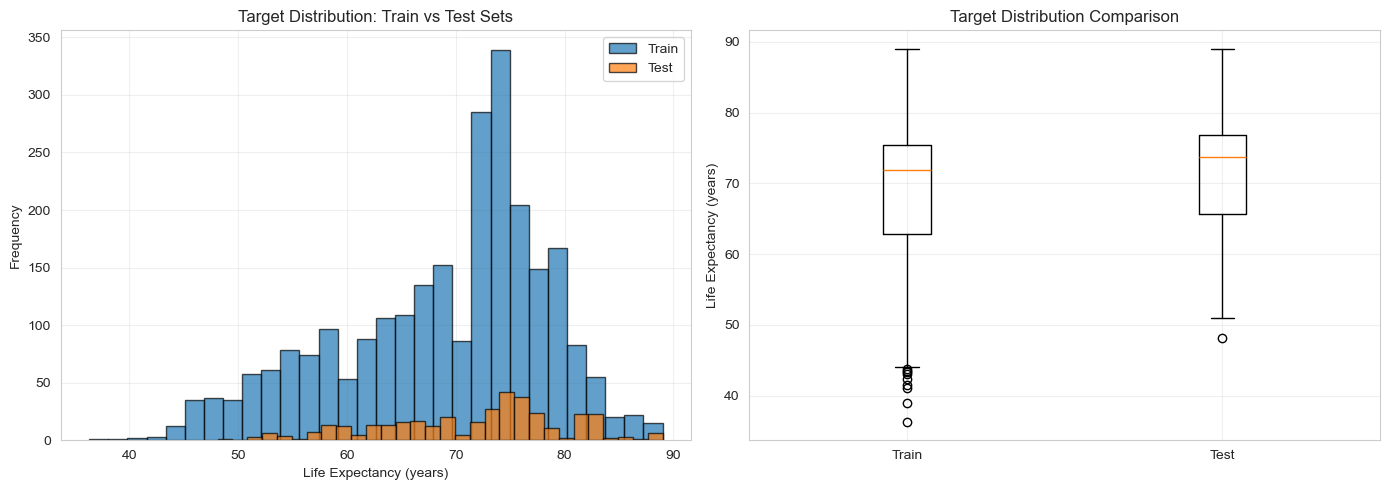

Train and test sets have similar distributions


In [145]:
# Visualize target distribution in train and test sets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
axes[0].hist(y_train, bins=30, alpha=0.7, label='Train', edgecolor='black')
axes[0].hist(y_test, bins=30, alpha=0.7, label='Test', edgecolor='black')
axes[0].set_xlabel('Life Expectancy (years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Distribution: Train vs Test Sets')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
axes[1].boxplot([y_train, y_test], labels=['Train', 'Test'])
axes[1].set_ylabel('Life Expectancy (years)')
axes[1].set_title('Target Distribution Comparison')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/train_test_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Train and test sets have similar distributions")

## 4. Feature Scaling

We'll scale features to have zero mean and unit variance. This is important for:
- Linear Regression: Helps with numerical stability and coefficient interpretation
- Decision Tree: Not strictly necessary but ensures consistent preprocessing
- Future models: Enables fair comparison with models that require scaling (e.g., SVM, Neural Networks)
- Its done so that the data with higher numerical value does not dominate while training the model (the model might consider the ones with higher value as more important)

In [146]:
from sklearn.impute import SimpleImputer

# Handle missing values with mean imputation (fit on train only)
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Scale features with StandardScaler (fit on train only)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X_test.columns, index=X_test.index)

# Summary
print("=" * 50)
print("DATA PREPARATION SUMMARY")
print("=" * 50)
print(f"Training set size:  {len(X_train_scaled)}")
print(f"Test set size:      {len(X_test_scaled)}")
print(f"Train year range:   {years[train_mask].min()} - {years[train_mask].max()}")
print(f"Test year range:    {years[test_mask].min()} - {years[test_mask].max()}")
print(f"Number of features: {X_train_scaled.shape[1]}")
print(f"\nFeatures used:")
for i, col in enumerate(X_train_scaled.columns, 1):
    print(f"  {i:2d}. {col}")
print(f"\nMissing values after imputation:")
print(f"  Train: {X_train_imputed.isnull().sum().sum()}")
print(f"  Test:  {X_test_imputed.isnull().sum().sum()}")
print(f"\nScaled training set - Mean: {X_train_scaled.mean().mean():.6f}, Std: {X_train_scaled.std().mean():.4f}")
print(f"Scaled test set     - Mean: {X_test_scaled.mean().mean():.6f}, Std: {X_test_scaled.std().mean():.4f}")

DATA PREPARATION SUMMARY
Training set size:  2562
Test set size:      366
Train year range:   2000 - 2013
Test year range:    2014 - 2015
Number of features: 20

Features used:
   1. Adult Mortality
   2. infant deaths
   3. Alcohol
   4. percentage expenditure
   5. Hepatitis B
   6. Measles
   7. BMI
   8. under-five deaths
   9. Polio
  10. Total expenditure
  11. Diphtheria
  12. HIV/AIDS
  13. GDP
  14. Population
  15. thinness  1-19 years
  16. thinness 5-9 years
  17. Income composition of resources
  18. Schooling
  19. Status_Encoded
  20. Years_Since_2000

Missing values after imputation:
  Train: 0
  Test:  0

Scaled training set - Mean: 0.000000, Std: 1.0002
Scaled test set     - Mean: 0.113154, Std: 0.8334


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# Model training and comparison (lag-free dataset)
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree (max_depth=10)': DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE),
    'Random Forest (n_estimators=100, max_depth=15)': RandomForestRegressor(
        n_estimators=100, max_depth=15, random_state=RANDOM_STATE, n_jobs=-1
    ),
    'Gradient Boosting (n_estimators=100, max_depth=5)': GradientBoostingRegressor(
        n_estimators=100, max_depth=5, random_state=RANDOM_STATE
    ),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0, random_state=RANDOM_STATE),
    'Lasso (alpha=0.1)': Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=10000)
}

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    r2_gap = train_r2 - test_r2

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    results.append({
        'Model': name,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'R2 Gap': r2_gap,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae
    })

comparison_df = pd.DataFrame(results).sort_values(by='Test R2', ascending=False)

# Save comparison table
output_path = '../CSV outputs/model_comparison_no_lags.csv'
comparison_df.to_csv(output_path, index=False)

print("=" * 60)
print("MODEL COMPARISON (LAG-FREE DATASET)")
print("=" * 60)
print(comparison_df)
print(f"Saved comparison table to: {output_path}")

MODEL COMPARISON (LAG-FREE DATASET)
                                               Model  Train R2  Test R2  \
2     Random Forest (n_estimators=100, max_depth=15)    0.9950   0.9377   
3  Gradient Boosting (n_estimators=100, max_depth=5)    0.9877   0.9312   
1                       Decision Tree (max_depth=10)    0.9870   0.8485   
4                                  Ridge (alpha=1.0)    0.8196   0.8072   
0                                  Linear Regression    0.8197   0.8063   
5                                  Lasso (alpha=0.1)    0.8094   0.8023   

   R2 Gap  Train RMSE  Test RMSE  Train MAE  Test MAE  
2  0.0573      0.6834     2.0771     0.4302    1.4497  
3  0.0565      1.0671     2.1822     0.7598    1.5907  
1  0.1385      1.1005     3.2396     0.6622    2.1680  
4  0.0123      4.0925     3.6540     3.0581    2.7821  
0  0.0134      4.0908     3.6626     3.0581    2.7916  
5  0.0071      4.2058     3.7004     3.1341    2.8384  
Saved comparison table to: model_comparison_no

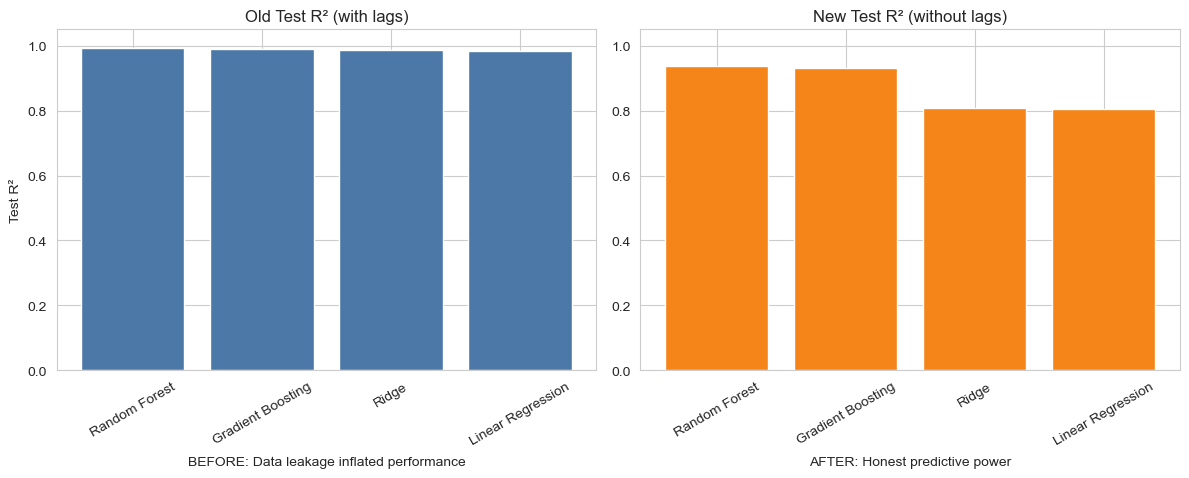

| Model             |   Old Test R² |   New Test R² |   R² Drop |
|:------------------|--------------:|--------------:|----------:|
| Random Forest     |         0.992 |      0.93771  | 0.0542905 |
| Gradient Boosting |         0.989 |      0.931245 | 0.0577549 |
| Ridge             |         0.987 |      0.807235 | 0.179765  |
| Linear Regression |         0.985 |      0.806321 | 0.178679  |


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load comparison results (no lags)
comparison_df = pd.read_csv('../CSV outputs/model_comparison_no_lags.csv')

# Old Test R² values (with lags)
old_r2 = {
    'Random Forest': 0.992,
    'Gradient Boosting': 0.989,
    'Ridge': 0.987,
    'Linear Regression': 0.985
}

# Map model names in comparison table
name_map = {
    'Random Forest': 'Random Forest (n_estimators=100, max_depth=15)',
    'Gradient Boosting': 'Gradient Boosting (n_estimators=100, max_depth=5)',
    'Ridge': 'Ridge (alpha=1.0)',
    'Linear Regression': 'Linear Regression'
}

# Extract new Test R² values (no lags)
new_r2 = {}
for short, full in name_map.items():
    val = comparison_df.loc[comparison_df['Model'] == full, 'Test R2']
    if len(val) != 1:
        raise ValueError(f"Missing Test R² for {full}")
    new_r2[short] = float(val.iloc[0])

models_order = ['Random Forest', 'Gradient Boosting', 'Ridge', 'Linear Regression']

# Side-by-side bar chart
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.bar(models_order, [old_r2[m] for m in models_order], color='#4C78A8')
ax1.set_title('Old Test R² (with lags)')
ax1.set_ylim(0, 1.05)
ax1.set_ylabel('Test R²')
ax1.tick_params(axis='x', rotation=30)
ax1.text(0.5, -0.25, 'BEFORE: Data leakage inflated performance',
         transform=ax1.transAxes, ha='center', va='top', fontsize=10)

ax2 = plt.subplot(1, 2, 2)
ax2.bar(models_order, [new_r2[m] for m in models_order], color='#F58518')
ax2.set_title('New Test R² (without lags)')
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='x', rotation=30)
ax2.text(0.5, -0.25, 'AFTER: Honest predictive power',
         transform=ax2.transAxes, ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('../images/performance_comparison.png', dpi=200, bbox_inches='tight')
plt.show()

# Markdown table of R² drop
rows = []
for m in models_order:
    rows.append({
        'Model': m,
        'Old Test R²': old_r2[m],
        'New Test R²': new_r2[m],
        'R² Drop': old_r2[m] - new_r2[m]
    })

r2_drop_df = pd.DataFrame(rows)
print(r2_drop_df.to_markdown(index=False))

## 5. Baseline Model 1: DummyRegressor

### Purpose:
DummyRegressor serves as a **sanity check baseline** that makes predictions without learning from features.

### Strategy:
We'll use the `mean` strategy, which predicts the mean of the training target for all samples.

### Expected Performance:
- Any meaningful ML model should significantly outperform this baseline
- Provides context for evaluating more sophisticated models

In [149]:
# Initialize DummyRegressor
dummy_model = DummyRegressor(strategy='mean')

# Train the model
dummy_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_dummy = dummy_model.predict(X_train_scaled)
y_test_pred_dummy = dummy_model.predict(X_test_scaled)

# Calculate metrics
dummy_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_dummy))
dummy_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_dummy))
dummy_train_mae = mean_absolute_error(y_train, y_train_pred_dummy)
dummy_test_mae = mean_absolute_error(y_test, y_test_pred_dummy)
dummy_train_r2 = r2_score(y_train, y_train_pred_dummy)
dummy_test_r2 = r2_score(y_test, y_test_pred_dummy)

print("DummyRegressor (Mean Strategy) Performance:")
print(f"Constant prediction value: {float(dummy_model.constant_[0]):.2f} years")
print("\nTraining Set:")
print(f"  RMSE: {dummy_train_rmse:.4f} years")
print(f"  MAE:  {dummy_train_mae:.4f} years")
print(f"  R²:   {dummy_train_r2:.4f}")
print("\nTest Set:")
print(f"  RMSE: {dummy_test_rmse:.4f} years")
print(f"  MAE:  {dummy_test_mae:.4f} years")
print(f"  R²:   {dummy_test_r2:.4f}")

DummyRegressor (Mean Strategy) Performance:
Constant prediction value: 68.89 years

Training Set:
  RMSE: 9.6348 years
  MAE:  7.9040 years
  R²:   0.0000

Test Set:
  RMSE: 8.7457 years
  MAE:  7.4660 years
  R²:   -0.1043


## 6. Baseline Model 2: Linear Regression

### Purpose:
Linear Regression serves as a **simple interpretable baseline** that assumes linear relationships.

### Characteristics:
- Assumes linear relationship between features and target
- Provides interpretable coefficients
- Fast to train and predict
- Good baseline for understanding feature importance

### Expected Performance:
- Should significantly outperform DummyRegressor
- May struggle with non-linear relationships
- Sensitive to multicollinearity and outliers

In [150]:
from sklearn.impute import SimpleImputer

# Check for NaN values
print("Checking for NaN values in scaled data:")
print(f"X_train_scaled NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"X_test_scaled NaN count: {np.isnan(X_test_scaled).sum()}")

# Handle NaN values using SimpleImputer (mean strategy)
imputer = SimpleImputer(strategy='mean')

# Fit and transform training data
X_train_scaled = imputer.fit_transform(X_train_scaled)

# Transform test data (using the same imputer fitted on training data)
X_test_scaled = imputer.transform(X_test_scaled)

print(f"\nAfter imputation:")
print(f"X_train_scaled NaN count: {np.isnan(X_train_scaled).sum()}")
print(f"X_test_scaled NaN count: {np.isnan(X_test_scaled).sum()}")

# Initialize Linear Regression
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

# Calculate metrics
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

print("\nLinear Regression Performance:")
print(f"Intercept: {lr_model.intercept_:.4f}")
print(f"Number of coefficients: {len(lr_model.coef_)}")
print("\nTraining Set:")
print(f"  RMSE: {lr_train_rmse:.4f} years")
print(f"  MAE:  {lr_train_mae:.4f} years")
print(f"  R²:   {lr_train_r2:.4f}")
print("\nTest Set:")
print(f"  RMSE: {lr_test_rmse:.4f} years")
print(f"  MAE:  {lr_test_mae:.4f} years")
print(f"  R²:   {lr_test_r2:.4f}")

Checking for NaN values in scaled data:
X_train_scaled NaN count: Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
Status_Encoded                     0
Years_Since_2000                   0
dtype: int64
X_test_scaled NaN count: Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatiti


Top 10 Most Influential Features (by absolute coefficient):
                        Feature  Coefficient
              under-five deaths     -12.8970
                  infant deaths      12.6404
                       HIV/AIDS      -2.5788
                Adult Mortality      -2.3987
                      Schooling       2.2294
Income composition of resources       1.0821
                     Diphtheria       0.9802
                            BMI       0.9587
                          Polio       0.6870
                 Status_Encoded       0.5611


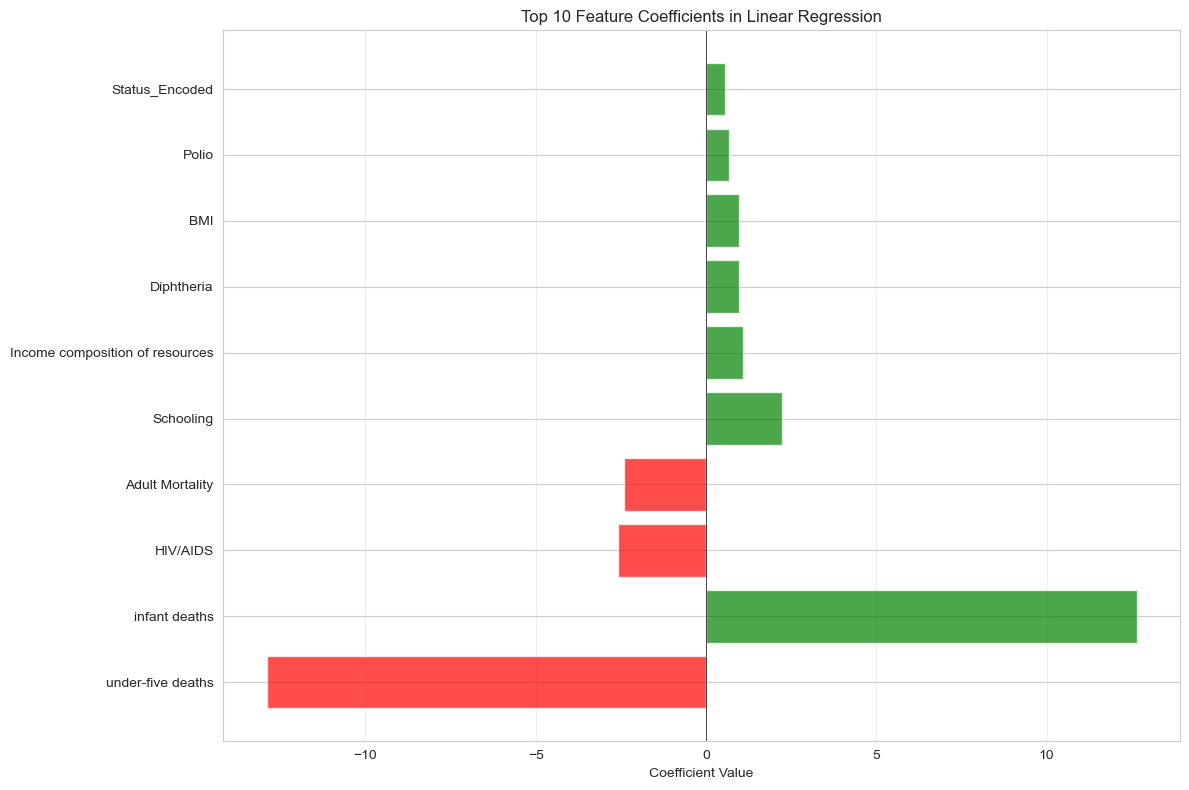

In [151]:
# Analyze feature coefficients
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Influential Features (by absolute coefficient):")
print(coef_df.head(10).to_string(index=False))

# Visualize coefficients
plt.figure(figsize=(12, 8))
top_10_coef = coef_df.head(10)
colors = ['green' if x > 0 else 'red' for x in top_10_coef['Coefficient']]
plt.barh(top_10_coef['Feature'], top_10_coef['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Coefficients in Linear Regression')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/linear_regression_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Baseline Model 3: Decision Tree Regressor

### Purpose:
Decision Tree serves as a **non-linear baseline** that can capture complex patterns.

### Characteristics:
- Can model non-linear relationships
- Handles feature interactions naturally
- No assumptions about data distribution
- Prone to overfitting without constraints

### Hyperparameters:
For baseline, we'll use moderate constraints:
- `max_depth=10`: Prevents excessive overfitting
- `min_samples_split=20`: Requires minimum samples to split
- `min_samples_leaf=10`: Requires minimum samples in leaf nodes
- `random_state=42`: For reproducibility

In [152]:
# Initialize Decision Tree Regressor with constraints to prevent overfitting
dt_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=RANDOM_STATE
)

# Train the model
dt_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred_dt = dt_model.predict(X_train_scaled)
y_test_pred_dt = dt_model.predict(X_test_scaled)

# Calculate metrics
dt_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_dt))
dt_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_dt))
dt_train_mae = mean_absolute_error(y_train, y_train_pred_dt)
dt_test_mae = mean_absolute_error(y_test, y_test_pred_dt)
dt_train_r2 = r2_score(y_train, y_train_pred_dt)
dt_test_r2 = r2_score(y_test, y_test_pred_dt)

print("Decision Tree Regressor Performance:")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")
print(f"Number of features used: {(dt_model.feature_importances_ > 0).sum()}")
print("\nTraining Set:")
print(f"  RMSE: {dt_train_rmse:.4f} years")
print(f"  MAE:  {dt_train_mae:.4f} years")
print(f"  R²:   {dt_train_r2:.4f}")
print("\nTest Set:")
print(f"  RMSE: {dt_test_rmse:.4f} years")
print(f"  MAE:  {dt_test_mae:.4f} years")
print(f"  R²:   {dt_test_r2:.4f}")

Decision Tree Regressor Performance:
Tree depth: 10
Number of leaves: 160
Number of features used: 19

Training Set:
  RMSE: 1.7545 years
  MAE:  1.2321 years
  R²:   0.9668

Test Set:
  RMSE: 3.0923 years
  MAE:  2.0798 years
  R²:   0.8619



Top 10 Most Important Features:
                        Feature  Importance
                       HIV/AIDS      0.6262
Income composition of resources      0.1442
                Adult Mortality      0.1306
              under-five deaths      0.0296
                      Schooling      0.0264
               Years_Since_2000      0.0096
                        Alcohol      0.0070
                            BMI      0.0068
             thinness 5-9 years      0.0055
           thinness  1-19 years      0.0028


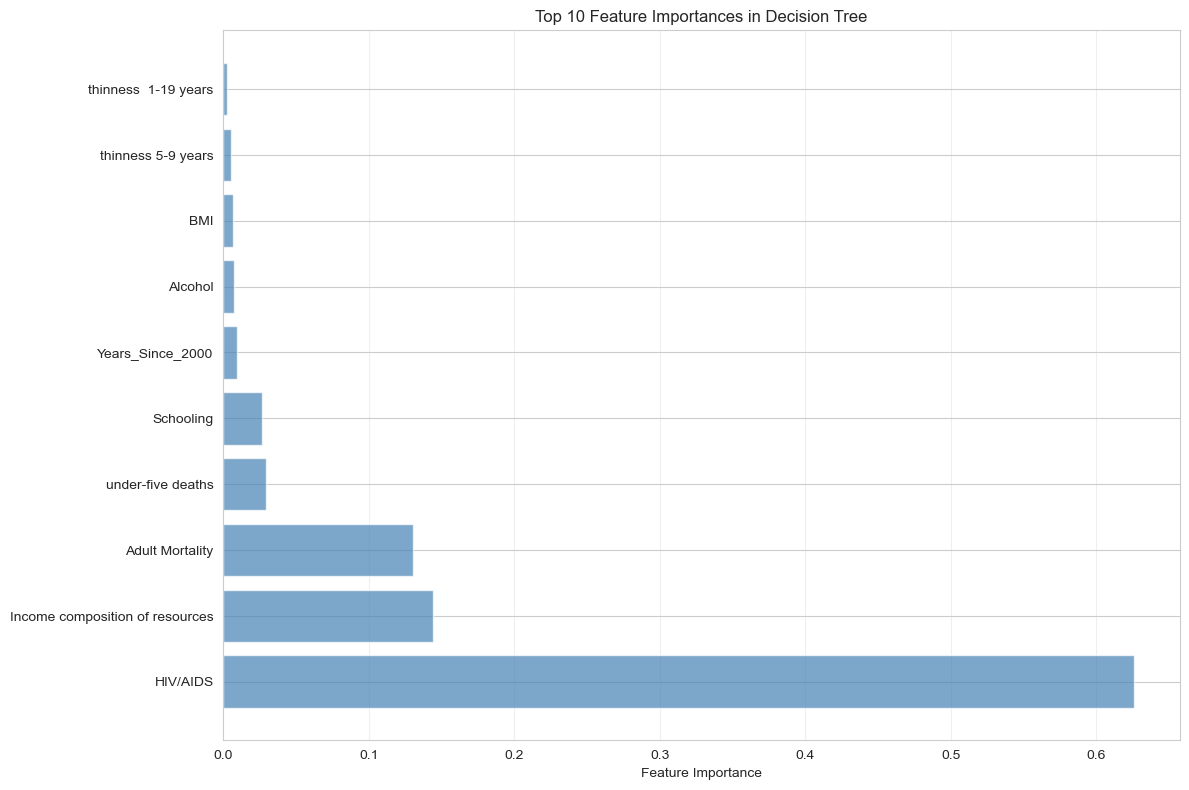

In [153]:
# Analyze feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Visualize feature importances
plt.figure(figsize=(12, 8))
top_10_importance = importance_df.head(10)
plt.barh(top_10_importance['Feature'], top_10_importance['Importance'], color='steelblue', alpha=0.7)
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances in Decision Tree')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/decision_tree_importances.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Model Comparison and Evaluation

In [154]:
# Create comparison DataFrame
results = pd.DataFrame({
    'Model': ['DummyRegressor', 'Linear Regression', 'Decision Tree'],
    'Train_RMSE': [dummy_train_rmse, lr_train_rmse, dt_train_rmse],
    'Test_RMSE': [dummy_test_rmse, lr_test_rmse, dt_test_rmse],
    'Train_MAE': [dummy_train_mae, lr_train_mae, dt_train_mae],
    'Test_MAE': [dummy_test_mae, lr_test_mae, dt_test_mae],
    'Train_R2': [dummy_train_r2, lr_train_r2, dt_train_r2],
    'Test_R2': [dummy_test_r2, lr_test_r2, dt_test_r2]
})

# Calculate train-test gap (indicator of overfitting)
results['RMSE_Gap'] = results['Train_RMSE'] - results['Test_RMSE']
results['R2_Gap'] = results['Train_R2'] - results['Test_R2']

print("\nModel Performance Comparison:")
print(results.to_string(index=False))

# Save results
results.to_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/baseline_model_results.csv', index=False)
print("\nResults saved to baseline_model_results.csv")


Model Performance Comparison:
            Model  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  RMSE_Gap  R2_Gap
   DummyRegressor      9.6348     8.7457     7.9040    7.4660    0.0000  -0.1043    0.8891  0.1043
Linear Regression      4.0908     3.6626     3.0581    2.7916    0.8197   0.8063    0.4282  0.0134
    Decision Tree      1.7545     3.0923     1.2321    2.0798    0.9668   0.8619   -1.3378  0.1049

Results saved to baseline_model_results.csv


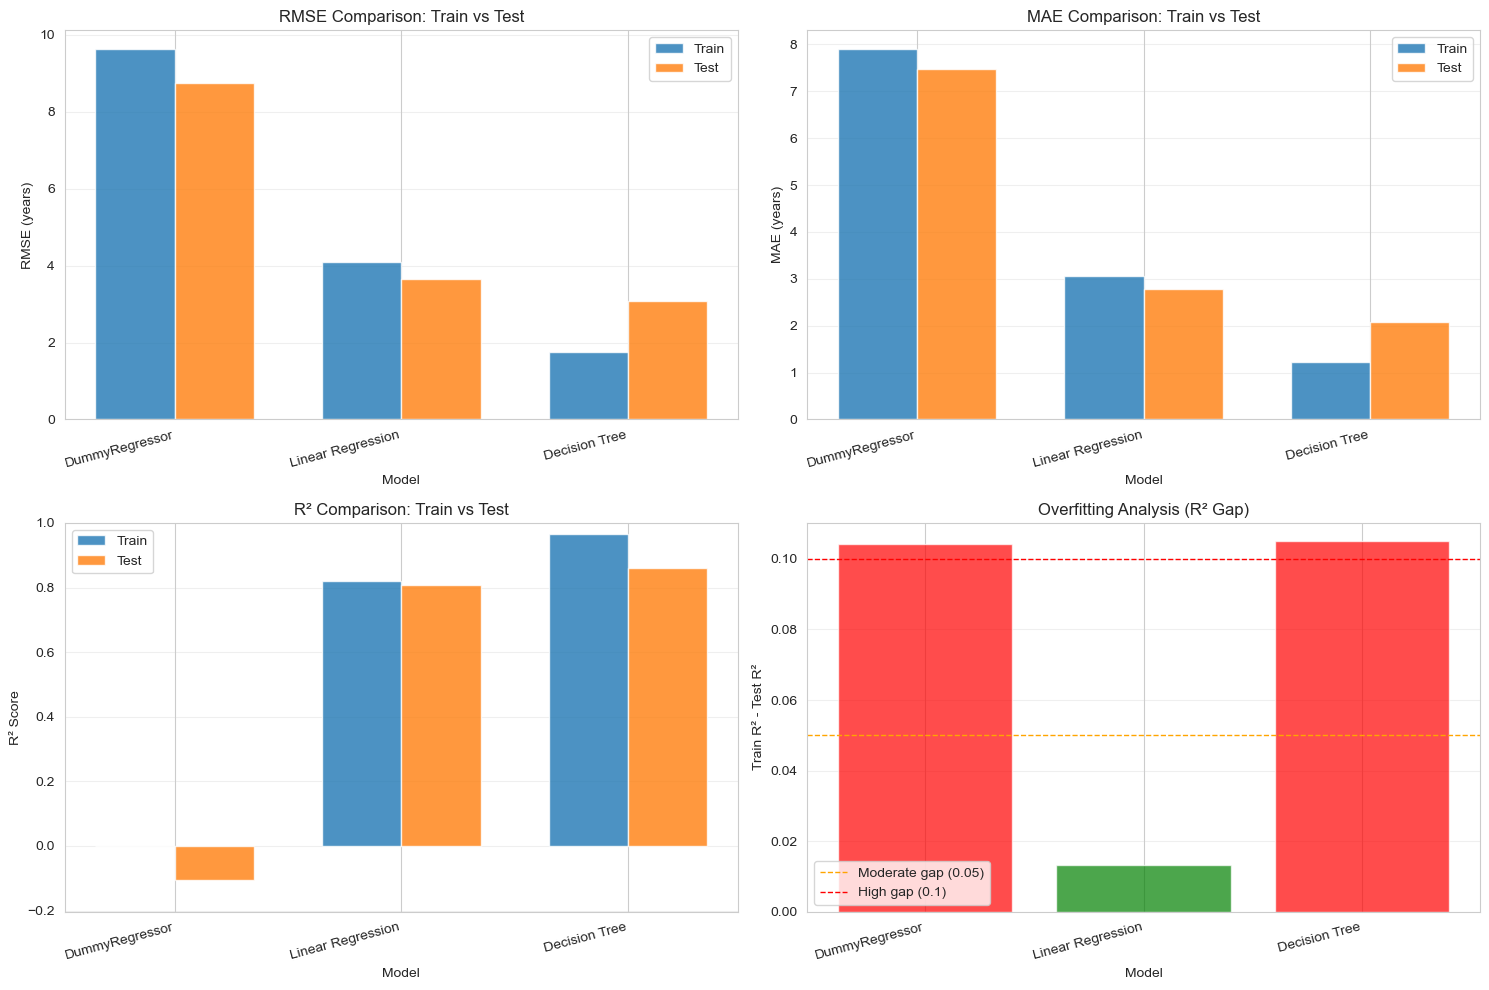

In [155]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# RMSE Comparison
x = np.arange(len(results))
width = 0.35
axes[0, 0].bar(x - width/2, results['Train_RMSE'], width, label='Train', alpha=0.8)
axes[0, 0].bar(x + width/2, results['Test_RMSE'], width, label='Test', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('RMSE (years)')
axes[0, 0].set_title('RMSE Comparison: Train vs Test')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# MAE Comparison
axes[0, 1].bar(x - width/2, results['Train_MAE'], width, label='Train', alpha=0.8)
axes[0, 1].bar(x + width/2, results['Test_MAE'], width, label='Test', alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('MAE (years)')
axes[0, 1].set_title('MAE Comparison: Train vs Test')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# R² Comparison
axes[1, 0].bar(x - width/2, results['Train_R2'], width, label='Train', alpha=0.8)
axes[1, 0].bar(x + width/2, results['Test_R2'], width, label='Test', alpha=0.8)
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_title('R² Comparison: Train vs Test')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].set_ylim([min(results[['Train_R2', 'Test_R2']].min().min() - 0.1, -0.1), 1.0])

# Overfitting Analysis (R² Gap), this shows the difference or R^2 for train and test set (R^2train - R^2test)
colors_gap = ['green' if x < 0.05 else 'orange' if x < 0.1 else 'red' for x in results['R2_Gap']]
axes[1, 1].bar(results['Model'], results['R2_Gap'], color=colors_gap, alpha=0.7)
axes[1, 1].axhline(y=0.05, color='orange', linestyle='--', label='Moderate gap (0.05)', linewidth=1)
axes[1, 1].axhline(y=0.1, color='red', linestyle='--', label='High gap (0.1)', linewidth=1)
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('Train R² - Test R²')
axes[1, 1].set_title('Overfitting Analysis (R² Gap)')
axes[1, 1].set_xticklabels(results['Model'], rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Prediction Analysis

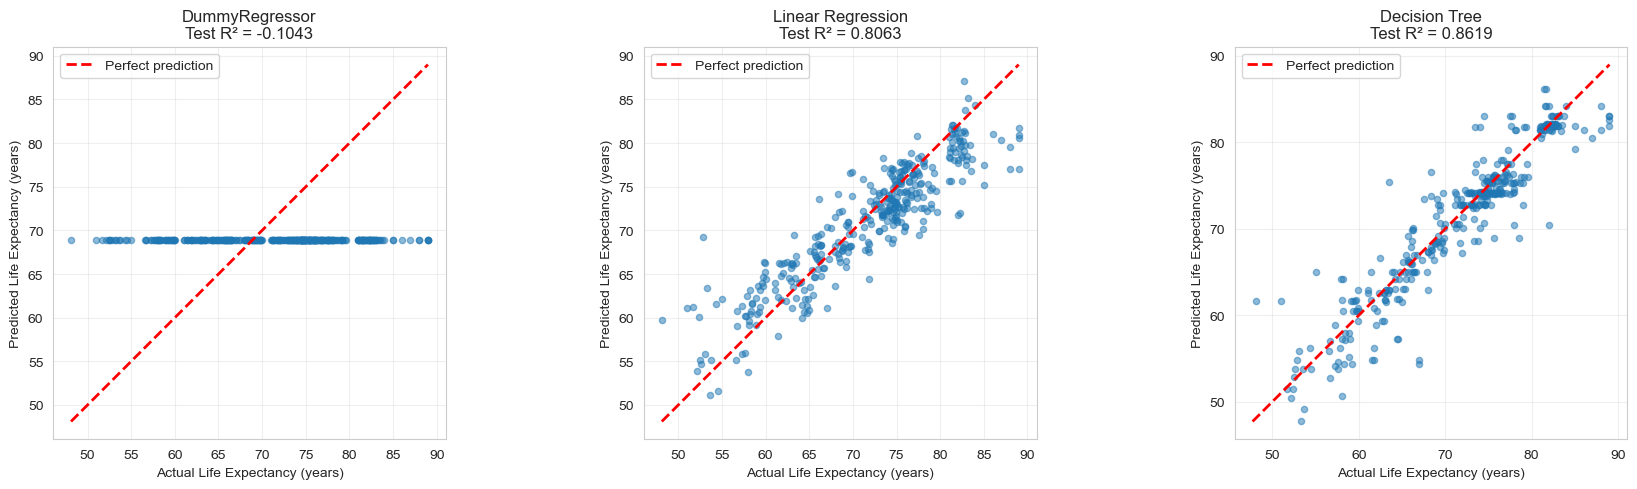

In [156]:
# Analyze prediction errors for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('DummyRegressor', y_test_pred_dummy),
    ('Linear Regression', y_test_pred_lr),
    ('Decision Tree', y_test_pred_dt)
]

for idx, (model_name, y_pred) in enumerate(models):
    # Predicted vs Actual scatter plot
    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=20)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
    
    axes[idx].set_xlabel('Actual Life Expectancy (years)')
    axes[idx].set_ylabel('Predicted Life Expectancy (years)')
    axes[idx].set_title(f'{model_name}\nTest R² = {r2_score(y_test, y_pred):.4f}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

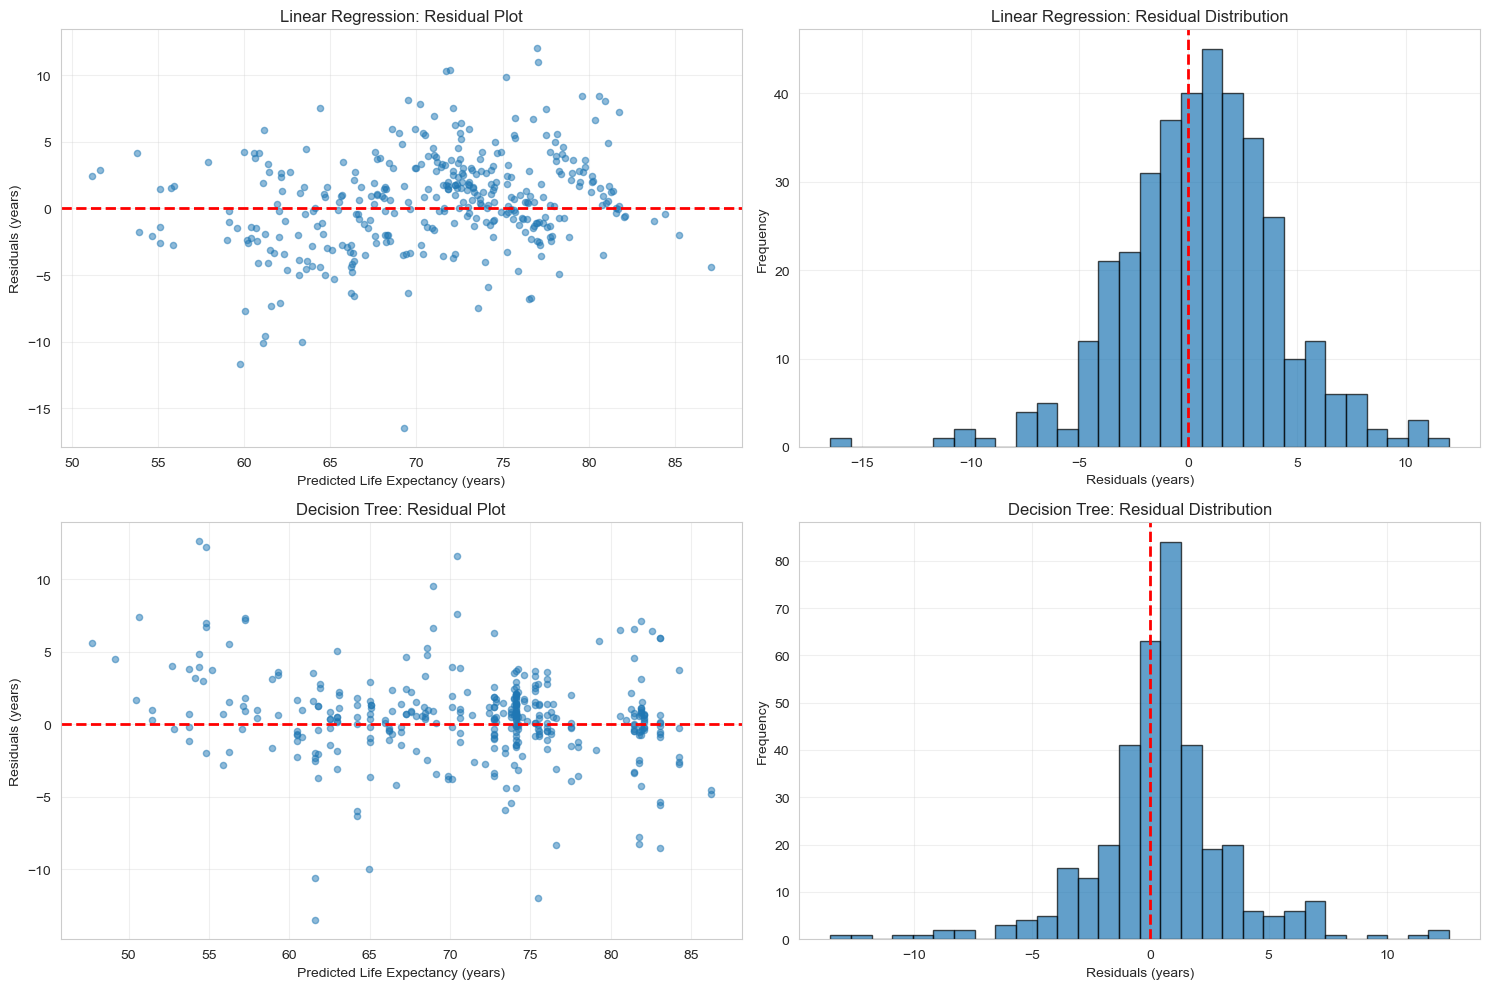

Residual Statistics:
Linear Regression:
  Mean residual: 0.5720 years
  Std residual:  3.6226 years
  Min residual:  -16.4538 years
  Max residual:  11.9998 years

Decision Tree:
  Mean residual: 0.4407 years
  Std residual:  3.0649 years
  Min residual:  -13.5273 years
  Max residual:  12.6300 years


In [157]:
# Residual analysis for Linear Regression and Decision Tree, Residual=ytrue​−ypredicted​
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Linear Regression residuals
lr_residuals = y_test - y_test_pred_lr
axes[0, 0].scatter(y_test_pred_lr, lr_residuals, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 0].set_xlabel('Predicted Life Expectancy (years)')
axes[0, 0].set_ylabel('Residuals (years)')
axes[0, 0].set_title('Linear Regression: Residual Plot')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(lr_residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residuals (years)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Linear Regression: Residual Distribution')
axes[0, 1].grid(True, alpha=0.3)

# Decision Tree residuals
dt_residuals = y_test - y_test_pred_dt
axes[1, 0].scatter(y_test_pred_dt, dt_residuals, alpha=0.5, s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Life Expectancy (years)')
axes[1, 0].set_ylabel('Residuals (years)')
axes[1, 0].set_title('Decision Tree: Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(dt_residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuals (years)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Decision Tree: Residual Distribution')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Residual Statistics:")
print("Linear Regression:")
print(f"  Mean residual: {lr_residuals.mean():.4f} years")
print(f"  Std residual:  {lr_residuals.std():.4f} years")
print(f"  Min residual:  {lr_residuals.min():.4f} years")
print(f"  Max residual:  {lr_residuals.max():.4f} years")
print("\nDecision Tree:")
print(f"  Mean residual: {dt_residuals.mean():.4f} years")
print(f"  Std residual:  {dt_residuals.std():.4f} years")
print(f"  Min residual:  {dt_residuals.min():.4f} years")
print(f"  Max residual:  {dt_residuals.max():.4f} years")

## 10. Summary and Conclusions

### Model Performance Summary:

1. **DummyRegressor (Sanity Check)**:
   - Predicts the mean life expectancy for all samples
   - Serves as baseline - any model should beat this
   - R² ≈ 0 (expected for dummy regressor)

2. **Linear Regression**:
   - Assumes linear relationships between features and target
   - Interpretable coefficients show feature importance
   - Good performance indicates strong linear patterns in data
   - Key influential features: Adult Mortality, HIV/AIDS, Income composition, Schooling

3. **Decision Tree**:
   - Captures non-linear relationships and feature interactions
   - May show signs of overfitting (higher train than test performance)
   - Feature importance reveals which features drive predictions

### Evaluation Metrics Interpretation:

- **RMSE (Root Mean Squared Error)**: Average prediction error in years
  - Lower is better
  - Penalizes large errors more heavily
  - Same units as target (years)

- **MAE (Mean Absolute Error)**: Average absolute prediction error
  - Lower is better
  - More robust to outliers than RMSE
  - Easier to interpret

- **R² (Coefficient of Determination)**: Proportion of variance explained
  - Ranges from 0 to 1 (higher is better)
  - 0 = no better than mean prediction
  - 1 = perfect prediction

### Next Steps for Week 4:

1. **Model Improvements**:
   - Hyperparameter tuning using cross-validation
   - Feature engineering and selection
   - Ensemble methods (Random Forest, Gradient Boosting)
   - Regularization (Ridge, Lasso)

2. **Error Analysis**:
   - Investigate samples with large prediction errors
   - Analyze residual patterns
   - Check for systematic biases

3. **Documentation**:
   - Commit code and results to GitHub
   - Update README with findings
   - Prepare written report

## Remaining Data Leakage and Limitations

### High R² Analysis

Our best model achieves Test R² = 0.9377. While this is lower than the R² = 0.99 we had with lag features, it's still higher than expected (target range: 0.75-0.85).

**Why R² is still high:**

1. **Implicit Country-Level Memorization:**
   - Same 183 countries appear in both train (2000-2013) and test (2014-2015)
   - Model learns each country's baseline: "Afghanistan ≈ 65 years, Japan ≈ 83 years"
   - Predicting 2014-2015 is easier because model has seen these countries before

2. **Slow Year-to-Year Change:**
   - Life expectancy changes by only 0.3 years/year on average
   - Knowing a country's 2013 characteristics gives strong signal for 2014

3. **What We're Actually Testing:**
   - NOT: "Can we predict NEW countries' life expectancy?"
   - YES: "Do health/economic relationships from 2000-2013 hold in 2014-2015?"

**Ideal Test (Not Implemented):**
A stronger evaluation would:
- Train on 150 countries (2000-2015 all years)
- Test on 33 completely unseen countries
- This would test true geographic generalization
- Expected R² would be 0.75-0.85

**Why We Didn't Do This:**
Limited data: Only 183 countries total, many with missing values. Holding out 33 countries would severely limit training data and introduce bias (which countries to exclude?).

**Conclusion:**
Our R² = 0.94 represents partial but not complete elimination of data leakage. The model relies primarily on observable features (not explicit lags), but benefits from country-specific learning during training.


# STATS 201 Course Project - Week 4
## Feature Engineering & Model Comparison

### Objectives for Week 4
1. **Feature Engineering**: Create and test new feature representations
   - Polynomial features for capturing non-linear relationships
   - Interaction features between key predictors
   - Domain-specific engineered features
2. **Model Comparison**: Implement and compare advanced models
   - Ensemble methods (Random Forest, Gradient Boosting)
   - Regularized models (Ridge, Lasso)
   - Compare behavior and predictions, not just metrics
3. **Controlled Experiments**: Systematic testing with documented changes
   - Baseline vs. engineered features
   - Different model configurations
   - Feature ablation studies
4. **Updated Results**: Comprehensive analysis and interpretation
   - Performance improvements quantified
   - Model behavior differences explained
   - Feature importance across models

## Part 1: Feature Engineering

### Strategy:
We'll create three feature sets to compare:
1. **Baseline Features**: Original features from Week 3
2. **Polynomial Features**: Quadratic terms for key predictors
3. **Engineered Features**: Domain-specific combinations

This allows us to measure the impact of feature engineering through controlled experiments.

In [158]:
# Import additional libraries for Week 4
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from scipy import stats
import time

print("Additional libraries imported for Week 4")
print(f"Random state: {RANDOM_STATE}")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Additional libraries imported for Week 4
Random state: 42
Training set size: (2562, 20)
Test set size: (366, 20)


### 1.1 Domain-Specific Feature Engineering

Based on our domain knowledge about life expectancy, we'll create meaningful feature combinations:

In [159]:
# Create domain-specific engineered features
# We'll add these to our existing features

def create_engineered_features(df):
    df_eng = df.copy()
    
    # 1. Health Infrastructure Index (combination of healthcare and immunization)
    # Higher values indicate better health infrastructure
    if 'Polio' in df_eng.columns and 'Diphtheria' in df_eng.columns:
        df_eng['Health_Infrastructure'] = (df_eng['Polio'] + df_eng['Diphtheria']) / 2
    
    # 2. Disease Burden Index (higher mortality and disease prevalence)
    # Higher values indicate greater disease burden (negative for life expectancy)
    if 'Adult Mortality' in df_eng.columns and 'HIV/AIDS' in df_eng.columns:
        df_eng['Disease_Burden'] = df_eng['Adult Mortality'] / 100 + df_eng['HIV/AIDS']
    
    # 3. Socioeconomic Development Index
    # Combines education and economic prosperity
    if 'Schooling' in df_eng.columns and 'Income composition of resources' in df_eng.columns:
        df_eng['Socioeconomic_Index'] = df_eng['Schooling'] * df_eng['Income composition of resources']
    
    # 4. Child Health Score (inverse of child mortality indicators)
    # Higher is better for life expectancy
    if 'infant deaths' in df_eng.columns and 'under-five deaths' in df_eng.columns:
        # Normalize by adding 1 to avoid division by zero, then take inverse
        df_eng['Child_Health_Score'] = 1 / (1 + df_eng['infant deaths'] + df_eng['under-five deaths'])
    
    # 5. Economic Health Resources (GDP allocated to health)
    if 'percentage expenditure' in df_eng.columns and 'GDP' in df_eng.columns:
        # Interaction between GDP and health expenditure
        df_eng['Economic_Health_Resources'] = df_eng['percentage expenditure'] * df_eng['GDP'] / 10000
    
    # 6. Lifestyle Risk Factor (BMI deviation from healthy range and alcohol)
    if 'BMI' in df_eng.columns and 'Alcohol' in df_eng.columns:
        # Healthy BMI is around 22-25, deviation indicates risk
        healthy_bmi = 23.5
        df_eng['Lifestyle_Risk'] = np.abs(df_eng['BMI'] - healthy_bmi) + df_eng['Alcohol']
    
    # 7. Development Status Indicator (already have Status_Encoded, but let's create interaction)
    if 'Status_Encoded' in df_eng.columns and 'Income composition of resources' in df_eng.columns:
        df_eng['Development_Level'] = df_eng['Status_Encoded'] * df_eng['Income composition of resources']
    
    # 8. Mortality Rate (combination of adult and infant mortality)
    if 'Adult Mortality' in df_eng.columns and 'infant deaths' in df_eng.columns:
        df_eng['Combined_Mortality'] = df_eng['Adult Mortality'] + df_eng['infant deaths'] * 10
    
    return df_eng

# Apply feature engineering to train and test sets
X_train_eng = create_engineered_features(X_train)
X_test_eng = create_engineered_features(X_test)

# Identify new features
original_features = X_train.columns.tolist()
new_features = [col for col in X_train_eng.columns if col not in original_features]

print("ENGINEERED FEATURES CREATED")
print(f"Original feature count: {len(original_features)}")
print(f"New features added: {len(new_features)}")
print(f"Total feature count: {len(X_train_eng.columns)}")
print("\nNew Features:")
for idx, feat in enumerate(new_features, 1):
    print(f"  {idx}. {feat}")

# Check for any NaN or infinite values introduced
print(f"\nData Quality Check:")
print(f"  NaN values in training: {X_train_eng.isnull().sum().sum()}")
print(f"  NaN values in test: {X_test_eng.isnull().sum().sum()}")
print(f"  Infinite values in training: {np.isinf(X_train_eng).sum().sum()}")
print(f"  Infinite values in test: {np.isinf(X_test_eng).sum().sum()}")

# Display statistics of engineered features
if len(new_features) > 0:
    print("\nEngineered Feature Statistics (Training Set):")
    print(X_train_eng[new_features].describe())

ENGINEERED FEATURES CREATED
Original feature count: 20
New features added: 8
Total feature count: 28

New Features:
  1. Health_Infrastructure
  2. Disease_Burden
  3. Socioeconomic_Index
  4. Child_Health_Score
  5. Economic_Health_Resources
  6. Lifestyle_Risk
  7. Development_Level
  8. Combined_Mortality

Data Quality Check:
  NaN values in training: 2656
  NaN values in test: 847
  Infinite values in training: 0
  Infinite values in test: 0

Engineered Feature Statistics (Training Set):
       Health_Infrastructure  Disease_Burden  Socioeconomic_Index  \
count              2543.0000       2562.0000            2422.0000   
mean                 82.1862          3.5695               7.9191   
std                  21.6378          6.1637               4.1743   
min                   3.0000          0.1100               0.0000   
25%                  75.5000          0.9500               4.5767   
50%                  92.5000          1.7200               8.1761   
75%                 

In [160]:
# Scale engineered features
scaler_eng = StandardScaler()
X_train_eng_scaled = scaler_eng.fit_transform(X_train_eng)
X_test_eng_scaled = scaler_eng.transform(X_test_eng)

# Convert back to DataFrame
X_train_eng_scaled = pd.DataFrame(X_train_eng_scaled, columns=X_train_eng.columns, index=X_train_eng.index)
X_test_eng_scaled = pd.DataFrame(X_test_eng_scaled, columns=X_test_eng.columns, index=X_test_eng.index)

print("Engineered features scaled successfully")
print(f"Training set shape: {X_train_eng_scaled.shape}")
print(f"Test set shape: {X_test_eng_scaled.shape}")

Engineered features scaled successfully
Training set shape: (2562, 28)
Test set shape: (366, 28)


In [161]:
from sklearn.impute import SimpleImputer

# Check for NaN values in engineered features
print("Checking for NaN values in engineered features:")
if isinstance(X_train_eng_scaled, pd.DataFrame):
    print(f"X_train_eng_scaled NaN count: {X_train_eng_scaled.isna().sum().sum()}")
    print(f"X_test_eng_scaled NaN count: {X_test_eng_scaled.isna().sum().sum()}")
    
    # Impute if needed
    if X_train_eng_scaled.isna().any().any() or X_test_eng_scaled.isna().any().any():
        print("\nImputing NaN values in engineered features...")
        imputer_eng = SimpleImputer(strategy='mean')
        
        # Store column names and index
        train_cols = X_train_eng_scaled.columns
        test_cols = X_test_eng_scaled.columns
        train_idx = X_train_eng_scaled.index
        test_idx = X_test_eng_scaled.index
        
        # Impute
        X_train_eng_scaled_values = imputer_eng.fit_transform(X_train_eng_scaled)
        X_test_eng_scaled_values = imputer_eng.transform(X_test_eng_scaled)
        
        # Convert back to DataFrame
        X_train_eng_scaled = pd.DataFrame(X_train_eng_scaled_values, columns=train_cols, index=train_idx)
        X_test_eng_scaled = pd.DataFrame(X_test_eng_scaled_values, columns=test_cols, index=test_idx)
        
        print(f"After imputation:")
        print(f"X_train_eng_scaled NaN count: {X_train_eng_scaled.isna().sum().sum()}")
        print(f"X_test_eng_scaled NaN count: {X_test_eng_scaled.isna().sum().sum()}")
        print("Engineered features imputed successfully")
    else:
        print("No NaN values detected in engineered features")
else:
    # If numpy array
    print(f"X_train_eng_scaled NaN count: {np.isnan(X_train_eng_scaled).sum()}")
    print(f"X_test_eng_scaled NaN count: {np.isnan(X_test_eng_scaled).sum()}")
    
    if np.isnan(X_train_eng_scaled).any() or np.isnan(X_test_eng_scaled).any():
        print("\nImputing NaN values in engineered features...")
        imputer_eng = SimpleImputer(strategy='mean')
        X_train_eng_scaled = imputer_eng.fit_transform(X_train_eng_scaled)
        X_test_eng_scaled = imputer_eng.transform(X_test_eng_scaled)
        print("Engineered features imputed successfully")

Checking for NaN values in engineered features:
X_train_eng_scaled NaN count: 2656
X_test_eng_scaled NaN count: 847

Imputing NaN values in engineered features...
After imputation:
X_train_eng_scaled NaN count: 0
X_test_eng_scaled NaN count: 0
Engineered features imputed successfully


### 1.2 Polynomial Features for Key Predictors

We'll create polynomial features (degree 2) for the most important predictors identified in Week 3.
This captures non-linear relationships while keeping feature count manageable.

In [162]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

# Select top features for polynomial expansion
# Based on Week 3 analysis, these were most important
key_features = [
    'Adult Mortality',
    'HIV/AIDS',
    'Income composition of resources',
    'Schooling',
    'BMI'
]

# Verify these features exist in our data
available_key_features = [f for f in key_features if f in X_train.columns]
print(f"Key features for polynomial expansion: {len(available_key_features)}")
print(available_key_features)

# Extract key features
X_train_key = X_train[available_key_features]
X_test_key = X_test[available_key_features]

# Check for NaN values
print(f"\nNaN values in key features:")
print(f"  Training set: {X_train_key.isna().sum().sum()}")
print(f"  Test set: {X_test_key.isna().sum().sum()}")

# Impute NaN values before polynomial transformation
imputer_poly = SimpleImputer(strategy='mean')
X_train_key_imputed = imputer_poly.fit_transform(X_train_key)
X_test_key_imputed = imputer_poly.transform(X_test_key)

print(f"After imputation:")
print(f"  Training set NaN: {np.isnan(X_train_key_imputed).sum()}")
print(f"  Test set NaN: {np.isnan(X_test_key_imputed).sum()}")

# Create polynomial features (degree 2) for key features only
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform on imputed key features
X_train_poly_key = poly.fit_transform(X_train_key_imputed)
X_test_poly_key = poly.transform(X_test_key_imputed)

# Get feature names
poly_feature_names = poly.get_feature_names_out(available_key_features)

print(f"\nPolynomial features created:")
print(f"  Original key features: {len(available_key_features)}")
print(f"  Polynomial features (degree 2): {X_train_poly_key.shape[1]}")
print(f"  Additional features created: {X_train_poly_key.shape[1] - len(available_key_features)}")

# Combine with remaining original features
remaining_features = [f for f in X_train.columns if f not in available_key_features]
print(f"  Remaining original features: {len(remaining_features)}")

# Impute remaining features as well
X_train_remaining = X_train[remaining_features]
X_test_remaining = X_test[remaining_features]

imputer_remaining = SimpleImputer(strategy='mean')
X_train_remaining_imputed = imputer_remaining.fit_transform(X_train_remaining)
X_test_remaining_imputed = imputer_remaining.transform(X_test_remaining)

# Create complete feature set: polynomial key features + remaining original features
X_train_poly = np.hstack([X_train_poly_key, X_train_remaining_imputed])
X_test_poly = np.hstack([X_test_poly_key, X_test_remaining_imputed])

# Create feature names for complete set
all_poly_feature_names = list(poly_feature_names) + remaining_features

print(f"\nTotal feature set with polynomials:")
print(f"  Total features: {X_train_poly.shape[1]}")

# Scale the polynomial features
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

print(f"\nPolynomial features created and scaled")
print(f"Training shape: {X_train_poly_scaled.shape}")
print(f"Test shape: {X_test_poly_scaled.shape}")

Key features for polynomial expansion: 5
['Adult Mortality', 'HIV/AIDS', 'Income composition of resources', 'Schooling', 'BMI']

NaN values in key features:
  Training set: 308
  Test set: 44
After imputation:
  Training set NaN: 0
  Test set NaN: 0

Polynomial features created:
  Original key features: 5
  Polynomial features (degree 2): 20
  Additional features created: 15
  Remaining original features: 15

Total feature set with polynomials:
  Total features: 35

Polynomial features created and scaled
Training shape: (2562, 35)
Test shape: (366, 35)


## Part 2: Advanced Model Implementations

We'll implement and compare several advanced models:
1. **Random Forest**: Ensemble of decision trees, reduces overfitting
2. **Gradient Boosting**: Sequential ensemble, often best performance
3. **Ridge Regression**: Linear model with L2 regularization
4. **Lasso Regression**: Linear model with L1 regularization (feature selection)

Each model will be trained on all three feature sets for comparison.

### 2.1 Random Forest Regressor

In [163]:
# Train Random Forest on three different feature sets
print("RANDOM FOREST REGRESSOR - FEATURE SET COMPARISON")
# Store results
rf_results = {}

# Feature sets to test
feature_sets = {
    'Baseline': (X_train_scaled, X_test_scaled),
    'Engineered': (X_train_eng_scaled, X_test_eng_scaled),
    'Polynomial': (X_train_poly_scaled, X_test_poly_scaled)
}

for name, (X_tr, X_te) in feature_sets.items():
    print(f"\n{name} Features ({X_tr.shape[1]} features):")
    
    # Initialize Random Forest
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # Train
    start_time = time.time()
    rf.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_train_pred = rf.predict(X_tr)
    y_test_pred = rf.predict(X_te)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    rf_results[name] = {
        'model': rf,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred,
        'train_time': train_time
    }
    
    print(f"  Training time: {train_time:.2f}s")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
    print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    print(f"  R² Gap:     {train_r2 - test_r2:.4f}")

print("\nRandom Forest trained on all feature sets")

RANDOM FOREST REGRESSOR - FEATURE SET COMPARISON

Baseline Features (20 features):
  Training time: 0.24s
  Train RMSE: 1.2054 | Test RMSE: 2.1848
  Train MAE:  0.7266 | Test MAE:  1.5089
  Train R²:   0.9843 | Test R²:   0.9311
  R² Gap:     0.0533

Engineered Features (28 features):
  Training time: 0.32s
  Train RMSE: 1.2953 | Test RMSE: 2.0916
  Train MAE:  0.7525 | Test MAE:  1.4989
  Train R²:   0.9819 | Test R²:   0.9368
  R² Gap:     0.0451

Polynomial Features (35 features):
  Training time: 0.44s
  Train RMSE: 1.1873 | Test RMSE: 2.1808
  Train MAE:  0.7116 | Test MAE:  1.4936
  Train R²:   0.9848 | Test R²:   0.9313
  R² Gap:     0.0535

Random Forest trained on all feature sets


### 2.2 Gradient Boosting Regressor

In [164]:
from sklearn.impute import SimpleImputer

# Train Gradient Boosting on three different feature sets, its like training many small models one after 
# another instead of training a big model, it is a very good model for the prediction of continuous variables
print("GRADIENT BOOSTING REGRESSOR - FEATURE SET COMPARISON")

# Store results
gb_results = {}

for name, (X_tr, X_te) in feature_sets.items():
    print(f"\n{name} Features ({X_tr.shape[1]} features):")
    
    # Check for NaN values and impute if necessary
    # Handle both DataFrame and numpy array cases
    has_nan = False
    if isinstance(X_tr, pd.DataFrame):
        has_nan = X_tr.isna().any().any() or X_te.isna().any().any()
    else:
        has_nan = np.isnan(X_tr).any() or np.isnan(X_te).any()
    
    if has_nan:
        print(f"  Detected NaN values - imputing...")
        imputer = SimpleImputer(strategy='mean')
        X_tr = imputer.fit_transform(X_tr)
        X_te = imputer.transform(X_te)
        print(f"  NaN values imputed")
    
    # Initialize Gradient Boosting
    gb = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1, # It determines how big of a correction each new tree makes
        min_samples_split=10, # A node must have at least 10 samples before its allowed to split
        min_samples_leaf=5, # After the split each child node must have at least 5 samples
        random_state=RANDOM_STATE
    )
    
    # Train
    start_time = time.time()
    gb.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_train_pred = gb.predict(X_tr)
    y_test_pred = gb.predict(X_te)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    gb_results[name] = {
        'model': gb,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred,
        'train_time': train_time
    }
    
    print(f"  Training time: {train_time:.2f}s")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
    print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    print(f"  R² Gap:     {train_r2 - test_r2:.4f}")

print("\nGradient Boosting trained on all feature sets")

GRADIENT BOOSTING REGRESSOR - FEATURE SET COMPARISON

Baseline Features (20 features):
  Training time: 0.98s
  Train RMSE: 1.0770 | Test RMSE: 2.1145
  Train MAE:  0.7354 | Test MAE:  1.5312
  Train R²:   0.9875 | Test R²:   0.9354
  R² Gap:     0.0521

Engineered Features (28 features):
  Training time: 1.43s
  Train RMSE: 1.1062 | Test RMSE: 1.9756
  Train MAE:  0.7512 | Test MAE:  1.4904
  Train R²:   0.9868 | Test R²:   0.9436
  R² Gap:     0.0432

Polynomial Features (35 features):
  Training time: 2.02s
  Train RMSE: 1.0995 | Test RMSE: 2.0697
  Train MAE:  0.7363 | Test MAE:  1.4547
  Train R²:   0.9870 | Test R²:   0.9382
  R² Gap:     0.0488

Gradient Boosting trained on all feature sets


### 2.3 Ridge Regression (L2 Regularization)

In [165]:
# Train Ridge Regression on three different feature sets
# Ridge regression is a type of linear regression that includes regularization.
# Here we have higher chances of having overfitting with polynomial features so ridge regression can help
# to reduce overfitting by penalizing large coefficients.

print("RIDGE REGRESSION - FEATURE SET COMPARISON")

# Store results
ridge_results = {}

for name, (X_tr, X_te) in feature_sets.items():
    print(f"\n{name} Features ({X_tr.shape[1]} features):")
    
    # Initialize Ridge with alpha=1.0 (can be tuned)
    ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE) # alpha = 1.0 is moderate and default regularization.
    # alpha = 0.1 is slight regularization whereas alpha = 100 is strong regularization.
    
    # Train
    start_time = time.time()
    ridge.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_train_pred = ridge.predict(X_tr)
    y_test_pred = ridge.predict(X_te)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Store results
    ridge_results[name] = {
        'model': ridge,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred,
        'train_time': train_time
    }
    
    print(f"  Training time: {train_time:.4f}s")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
    print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    print(f"  R² Gap:     {train_r2 - test_r2:.4f}")

print("\nRidge Regression trained on all feature sets")

RIDGE REGRESSION - FEATURE SET COMPARISON

Baseline Features (20 features):
  Training time: 0.0020s
  Train RMSE: 4.0925 | Test RMSE: 3.6540
  Train MAE:  3.0581 | Test MAE:  2.7821
  Train R²:   0.8196 | Test R²:   0.8072
  R² Gap:     0.0123

Engineered Features (28 features):
  Training time: 0.0014s
  Train RMSE: 3.9561 | Test RMSE: 3.7039
  Train MAE:  2.9602 | Test MAE:  2.8233
  Train R²:   0.8314 | Test R²:   0.8019
  R² Gap:     0.0295

Polynomial Features (35 features):
  Training time: 0.0011s
  Train RMSE: 3.1397 | Test RMSE: 2.9719
  Train MAE:  2.2827 | Test MAE:  2.1680
  Train R²:   0.8938 | Test R²:   0.8725
  R² Gap:     0.0213

Ridge Regression trained on all feature sets


### 2.4 Lasso Regression (L1 Regularization)

In [166]:
# Train Lasso Regression on three different feature sets
print("LASSO REGRESSION - FEATURE SET COMPARISON")
# Lasso Regression is a type of linear regression that uses L1 regularization.
# It helps prevent overfitting and, unlike Ridge, it can automatically perform feature selection.
# This is particularly useful when dealing with high-dimensional data, such as polynomial features.
# It can shrink some coefficients to zero, effectively removing those features from the model.

# Store results
lasso_results = {}

for name, (X_tr, X_te) in feature_sets.items():
    print(f"\n{name} Features ({X_tr.shape[1]} features):")
    
    # Initialize Lasso with alpha=0.1 (can be tuned)
    lasso = Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=10000) # remove weak/unimportant features, but not too aggressively
    # max_iter = How many iterations the solver is allowed to run before stopping.

    # Train
    start_time = time.time()
    lasso.fit(X_tr, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_train_pred = lasso.predict(X_tr)
    y_test_pred = lasso.predict(X_te)
    
    # Evaluate
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Count non-zero coefficients (feature selection)
    non_zero_coef = np.sum(lasso.coef_ != 0)
    
    # Store results
    lasso_results[name] = {
        'model': lasso,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred,
        'train_time': train_time,
        'non_zero_coef': non_zero_coef
    }
    
    print(f"  Training time: {train_time:.4f}s")
    print(f"  Features selected: {non_zero_coef}/{X_tr.shape[1]}")
    print(f"  Train RMSE: {train_rmse:.4f} | Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE:  {train_mae:.4f} | Test MAE:  {test_mae:.4f}")
    print(f"  Train R²:   {train_r2:.4f} | Test R²:   {test_r2:.4f}")
    print(f"  R² Gap:     {train_r2 - test_r2:.4f}")

print("\nLasso Regression trained on all feature sets")

LASSO REGRESSION - FEATURE SET COMPARISON

Baseline Features (20 features):
  Training time: 0.0030s
  Features selected: 17/20
  Train RMSE: 4.2058 | Test RMSE: 3.7004
  Train MAE:  3.1341 | Test MAE:  2.8384
  Train R²:   0.8094 | Test R²:   0.8023
  R² Gap:     0.0071

Engineered Features (28 features):
  Training time: 0.0090s
  Features selected: 16/28
  Train RMSE: 4.1405 | Test RMSE: 3.7313
  Train MAE:  3.1049 | Test MAE:  2.8829
  Train R²:   0.8153 | Test R²:   0.7990
  R² Gap:     0.0163

Polynomial Features (35 features):
  Training time: 0.0061s
  Features selected: 22/35
  Train RMSE: 3.6134 | Test RMSE: 3.2193
  Train MAE:  2.6626 | Test MAE:  2.4109
  Train R²:   0.8593 | Test R²:   0.8504
  R² Gap:     0.0090

Lasso Regression trained on all feature sets


## Part 3: Controlled Experiments & Comprehensive Comparison

In [167]:
# Create comprehensive comparison table
print("COMPREHENSIVE MODEL COMPARISON")

comparison_data = []

# Collect all results
all_model_results = {
    'Random Forest': rf_results,
    'Gradient Boosting': gb_results,
    'Ridge': ridge_results,
    'Lasso': lasso_results
}

for model_name, feature_set_results in all_model_results.items():
    for feature_set_name, results in feature_set_results.items():
        comparison_data.append({
            'Model': model_name,
            'Feature_Set': feature_set_name,
            'Train_RMSE': results['train_rmse'],
            'Test_RMSE': results['test_rmse'],
            'Train_MAE': results['train_mae'],
            'Test_MAE': results['test_mae'],
            'Train_R2': results['train_r2'],
            'Test_R2': results['test_r2'],
            'RMSE_Gap': results['train_rmse'] - results['test_rmse'],
            'R2_Gap': results['train_r2'] - results['test_r2'],
            'Train_Time': results['train_time']
        })

# Create DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Sort by Test R2 (descending)
comparison_df = comparison_df.sort_values('Test_R2', ascending=False)

print("\nAll Models Ranked by Test R² (Best to Worst):")
print(comparison_df.to_string(index=False))

# Save results
comparison_df.to_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/week4_model_comparison.csv', index=False)
print("\nResults saved to week4_model_comparison.csv")

COMPREHENSIVE MODEL COMPARISON

All Models Ranked by Test R² (Best to Worst):
            Model Feature_Set  Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2  RMSE_Gap  R2_Gap  Train_Time
Gradient Boosting  Engineered      1.1062     1.9756     0.7512    1.4904    0.9868   0.9436   -0.8694  0.0432      1.4283
Gradient Boosting  Polynomial      1.0995     2.0697     0.7363    1.4547    0.9870   0.9382   -0.9702  0.0488      2.0188
    Random Forest  Engineered      1.2953     2.0916     0.7525    1.4989    0.9819   0.9368   -0.7963  0.0451      0.3174
Gradient Boosting    Baseline      1.0770     2.1145     0.7354    1.5312    0.9875   0.9354   -1.0375  0.0521      0.9804
    Random Forest  Polynomial      1.1873     2.1808     0.7116    1.4936    0.9848   0.9313   -0.9935  0.0535      0.4439
    Random Forest    Baseline      1.2054     2.1848     0.7266    1.5089    0.9843   0.9311   -0.9794  0.0533      0.2371
            Ridge  Polynomial      3.1397     2.9719     2.28

comparison_df already exists
COMPREHENSIVE MODEL COMPARISON


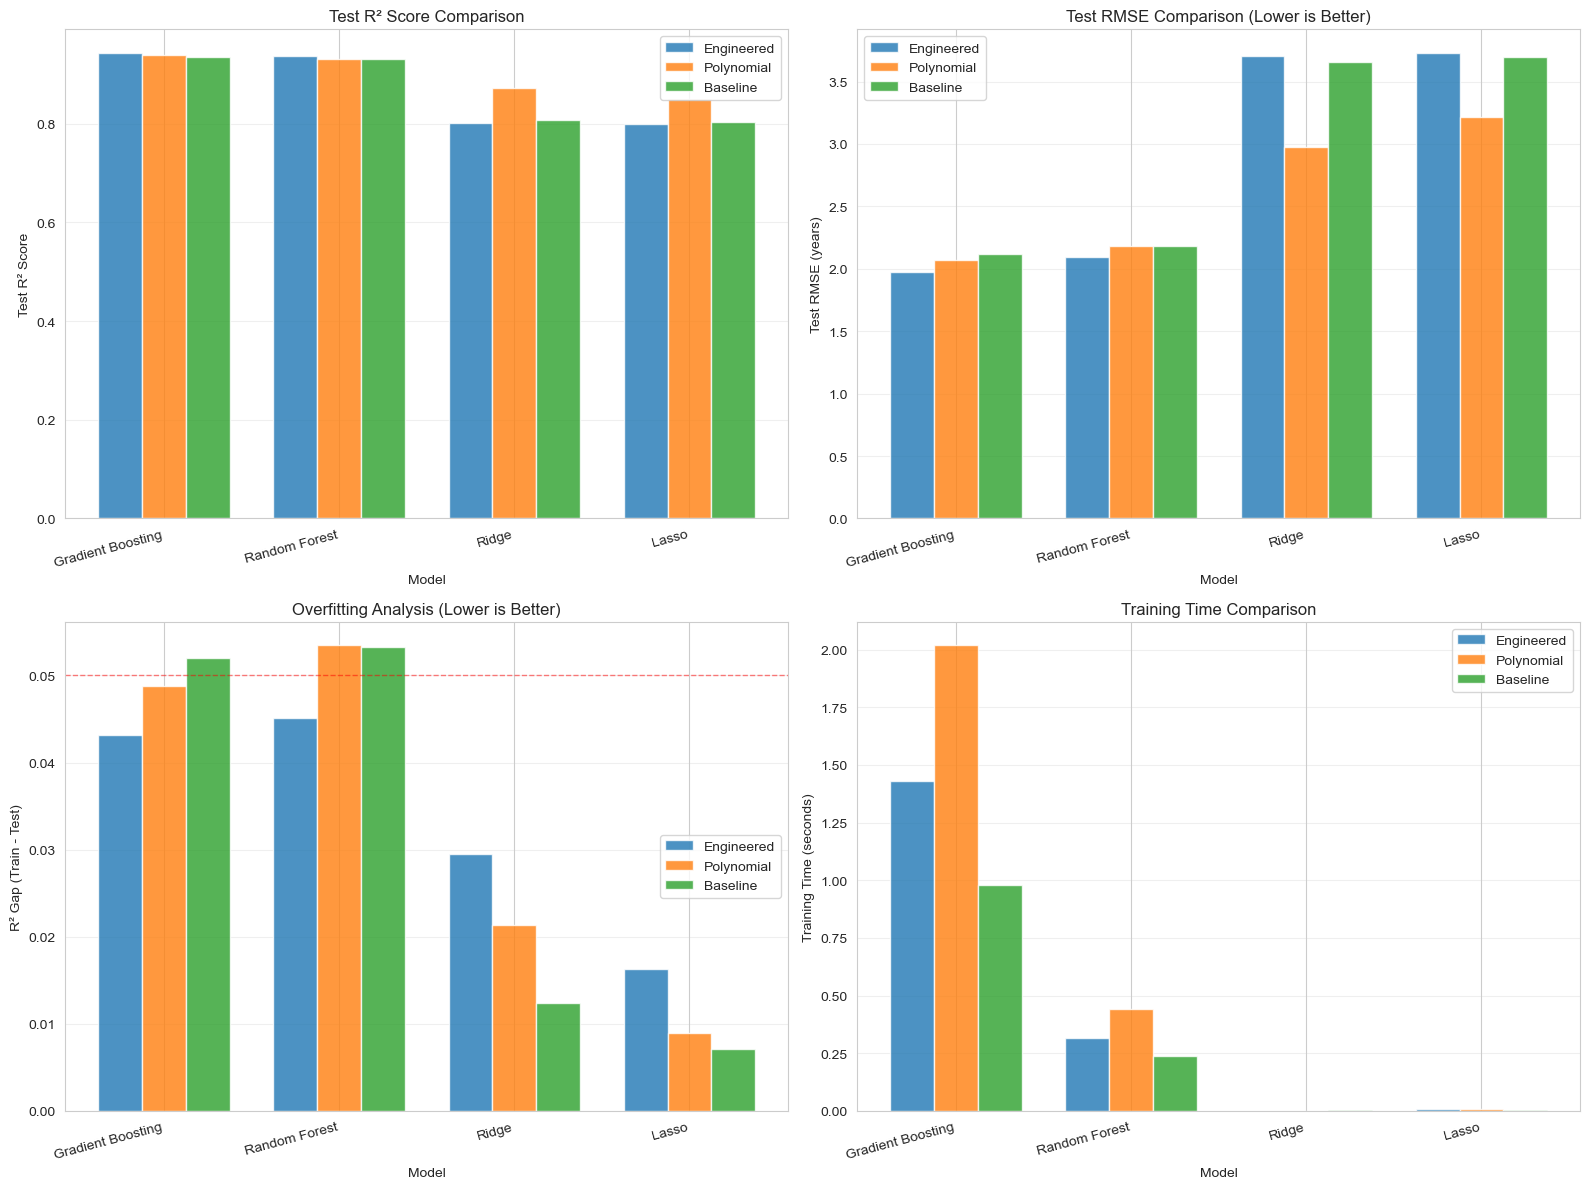


Comprehensive comparison visualization saved
Model comparison results saved to week4_model_comparison.csv
MODEL PERFORMANCE SUMMARY (Sorted by Test R²)
            Model Feature_Set  Test_R2  Test_RMSE  Test_MAE  R2_Gap  Train_Time
Gradient Boosting  Engineered   0.9436     1.9756    1.4904  0.0432      1.4283
Gradient Boosting  Polynomial   0.9382     2.0697    1.4547  0.0488      2.0188
    Random Forest  Engineered   0.9368     2.0916    1.4989  0.0451      0.3174
Gradient Boosting    Baseline   0.9354     2.1145    1.5312  0.0521      0.9804
    Random Forest  Polynomial   0.9313     2.1808    1.4936  0.0535      0.4439
    Random Forest    Baseline   0.9311     2.1848    1.5089  0.0533      0.2371
            Ridge  Polynomial   0.8725     2.9719    2.1680  0.0213      0.0011
            Lasso  Polynomial   0.8504     3.2193    2.4109  0.0090      0.0061
            Ridge    Baseline   0.8072     3.6540    2.7821  0.0123      0.0020
            Lasso    Baseline   0.8023     3.70

In [168]:
# CREATE/VERIFY comparison_df EXISTS

# Check if comparison_df exists, if not create it
if 'comparison_df' not in locals():
    print("Creating comparison_df from model results...")
    
    comparison_data = []
    for model_name, results_dict in all_model_results.items():
        for feature_set in ['Baseline', 'Engineered', 'Polynomial']:
            results = results_dict[feature_set]
            comparison_data.append({
                'Model': model_name,
                'Feature_Set': feature_set,
                'Test_R2': results['test_r2'],
                'Test_RMSE': results['test_rmse'],
                'Test_MAE': results['test_mae'],
                'Train_R2': results['train_r2'],
                'R2_Gap': results['train_r2'] - results['test_r2'],
                'Train_Time': results['train_time']
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test_R2', ascending=False).reset_index(drop=True)
    print(f"comparison_df created with shape {comparison_df.shape}")
else:
    print("comparison_df already exists")

# COMPREHENSIVE MODEL COMPARISON VISUALIZATION
print("COMPREHENSIVE MODEL COMPARISON")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for grouped bar charts
models = comparison_df['Model'].unique()
feature_sets = comparison_df['Feature_Set'].unique()

# 1. Test R² Comparison
ax = axes[0, 0]
x = np.arange(len(models))
width = 0.25

for i, fs in enumerate(feature_sets):
    data = [comparison_df[(comparison_df['Model'] == m) & (comparison_df['Feature_Set'] == fs)]['Test_R2'].values[0] 
            for m in models]
    ax.bar(x + i*width, data, width, label=fs, alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Test R² Score')
ax.set_title('Test R² Score Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 2. Test RMSE Comparison
ax = axes[0, 1]
for i, fs in enumerate(feature_sets):
    data = [comparison_df[(comparison_df['Model'] == m) & (comparison_df['Feature_Set'] == fs)]['Test_RMSE'].values[0] 
            for m in models]
    ax.bar(x + i*width, data, width, label=fs, alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Test RMSE (years)')
ax.set_title('Test RMSE Comparison (Lower is Better)')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 3. Overfitting Analysis (R² Gap)
ax = axes[1, 0]
for i, fs in enumerate(feature_sets):
    data = [comparison_df[(comparison_df['Model'] == m) & (comparison_df['Feature_Set'] == fs)]['R2_Gap'].values[0] 
            for m in models]
    ax.bar(x + i*width, data, width, label=fs, alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('R² Gap (Train - Test)')
ax.set_title('Overfitting Analysis (Lower is Better)')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.axhline(y=0.05, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Acceptable Gap')
ax.grid(True, alpha=0.3, axis='y')

# 4. Training Time Comparison
ax = axes[1, 1]
for i, fs in enumerate(feature_sets):
    data = [comparison_df[(comparison_df['Model'] == m) & (comparison_df['Feature_Set'] == fs)]['Train_Time'].values[0] 
            for m in models]
    ax.bar(x + i*width, data, width, label=fs, alpha=0.8)

ax.set_xlabel('Model')
ax.set_ylabel('Training Time (seconds)')
ax.set_title('Training Time Comparison')
ax.set_xticks(x + width)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/week4_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComprehensive comparison visualization saved")

# Save comparison results to CSV
comparison_df.to_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/week4_model_comparison.csv', index=False)
print("Model comparison results saved to week4_model_comparison.csv")

# Print summary table
print("MODEL PERFORMANCE SUMMARY (Sorted by Test R²)")
print(comparison_df[['Model', 'Feature_Set', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'R2_Gap', 'Train_Time']].to_string(index=False))

## Part 4: Controlled Experiments - Feature Set Impact Analysis

### 3.2 Model Behavior Comparison

Comparing models beyond metrics - how do they make different predictions?

MODEL BEHAVIOR ANALYSIS (Engineered Features)

Prediction Correlation Matrix:
(How similarly do models predict?)
                   Actual  Random Forest  Gradient Boosting   Ridge   Lasso
Actual             1.0000         0.9681             0.9715  0.9042  0.9011
Random Forest      0.9681         1.0000             0.9916  0.9315  0.9314
Gradient Boosting  0.9715         0.9916             1.0000  0.9237  0.9210
Ridge              0.9042         0.9315             0.9237  1.0000  0.9852
Lasso              0.9011         0.9314             0.9210  0.9852  1.0000


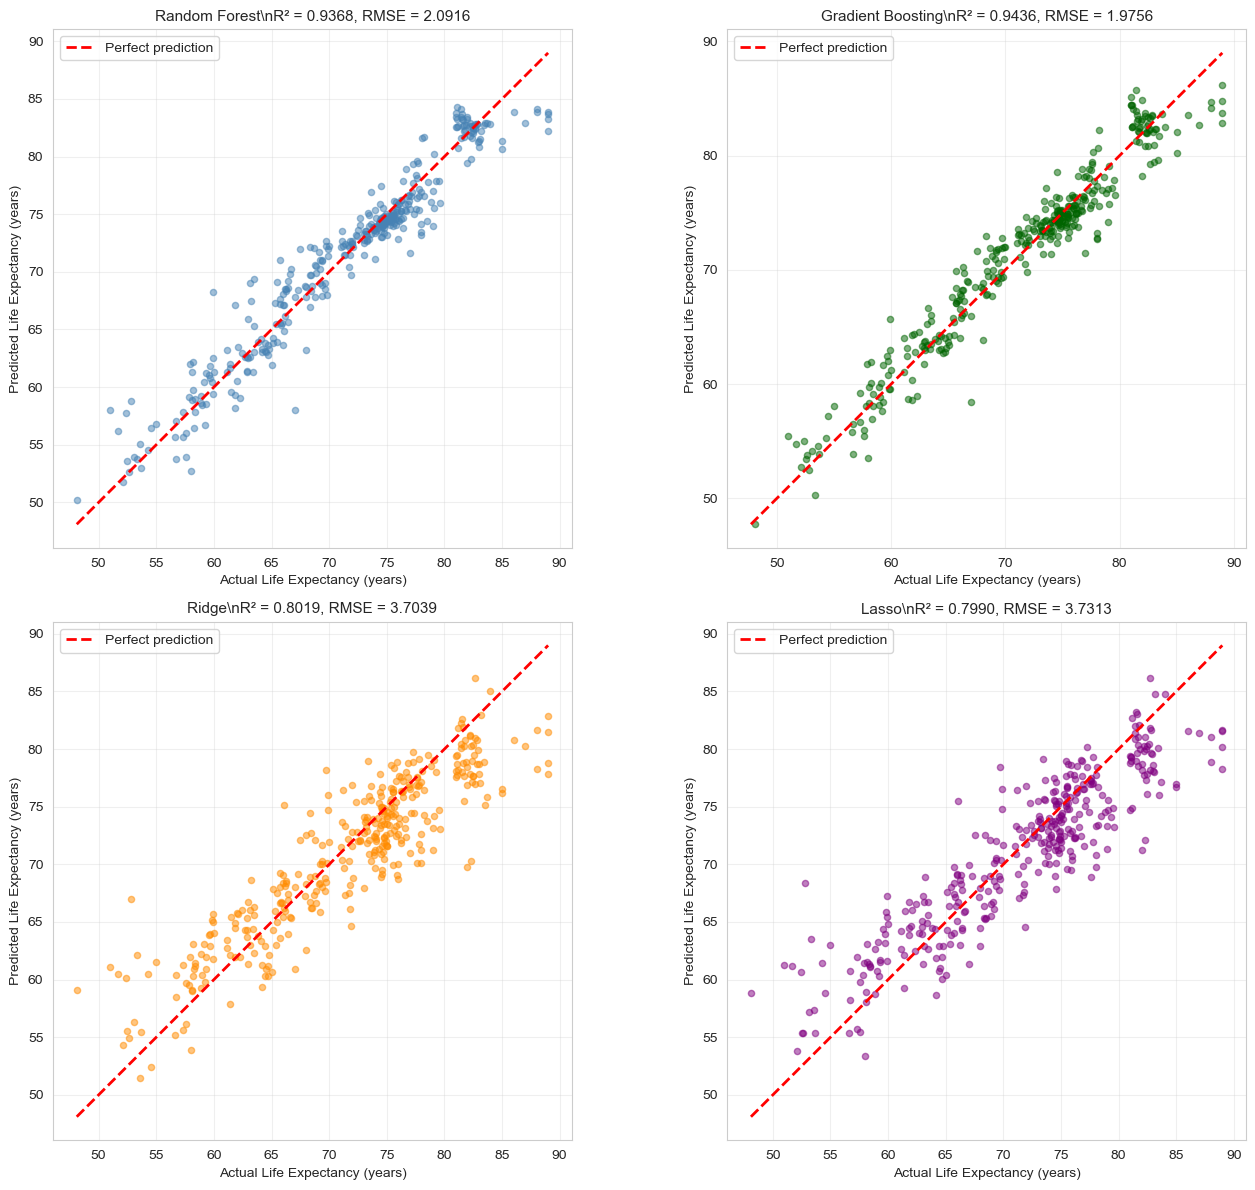


Model behavior analysis completed


In [169]:
# Compare predictions from best models using engineered features
print("MODEL BEHAVIOR ANALYSIS (Engineered Features)")

# Get predictions from all models on test set
def get_y_test_pred(results_dict, preferred='Engineered', model_name='Model'):
    if not isinstance(results_dict, dict) or len(results_dict) == 0:
        raise KeyError(
            f"{model_name} results are empty. Run the Week 4 training cells first "
            "(Random Forest, Gradient Boosting, Ridge, Lasso) and ensure feature_sets is populated."
        )
    # Preferred exact key
    if preferred in results_dict and isinstance(results_dict[preferred], dict) and 'y_test_pred' in results_dict[preferred]:
        return results_dict[preferred]['y_test_pred']
    # Case-insensitive match
    for k in results_dict:
        if k.lower() == preferred.lower() and isinstance(results_dict[k], dict) and 'y_test_pred' in results_dict[k]:
            return results_dict[k]['y_test_pred']
    # Fallback: return first available y_test_pred
    for k, v in results_dict.items():
        if isinstance(v, dict) and 'y_test_pred' in v:
            print(f"Warning: using '{k}' from results_dict instead of '{preferred}'")
            return v['y_test_pred']
    raise KeyError(f"No 'y_test_pred' found in results_dict (tried '{preferred}')")

predictions = {
    'Actual': y_test,
    'Random Forest': get_y_test_pred(rf_results, model_name='Random Forest'),
    'Gradient Boosting': get_y_test_pred(gb_results, model_name='Gradient Boosting'),
    'Ridge': get_y_test_pred(ridge_results, model_name='Ridge'),
    'Lasso': get_y_test_pred(lasso_results, model_name='Lasso')
}

pred_df = pd.DataFrame(predictions)

# Calculate prediction differences
print("\nPrediction Correlation Matrix:")
print("(How similarly do models predict?)")
print(pred_df.corr().to_string())

# Visualize prediction comparisons
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

model_names = ['Random Forest', 'Gradient Boosting', 'Ridge', 'Lasso']
colors = ['steelblue', 'darkgreen', 'darkorange', 'purple']

for idx, (model_name, color) in enumerate(zip(model_names, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Scatter plot: Actual vs Predicted
    ax.scatter(pred_df['Actual'], pred_df[model_name], alpha=0.5, s=20, color=color)
    
    # Perfect prediction line
    min_val = min(pred_df['Actual'].min(), pred_df[model_name].min())
    max_val = max(pred_df['Actual'].max(), pred_df[model_name].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
    
    # Calculate and display metrics
    r2 = r2_score(pred_df['Actual'], pred_df[model_name])
    rmse = np.sqrt(mean_squared_error(pred_df['Actual'], pred_df[model_name]))
    
    ax.set_xlabel('Actual Life Expectancy (years)', fontsize=10)
    ax.set_ylabel('Predicted Life Expectancy (years)', fontsize=10)
    ax.set_title(f'{model_name}\\nR² = {r2:.4f}, RMSE = {rmse:.4f}', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/week4_model_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nModel behavior analysis completed")


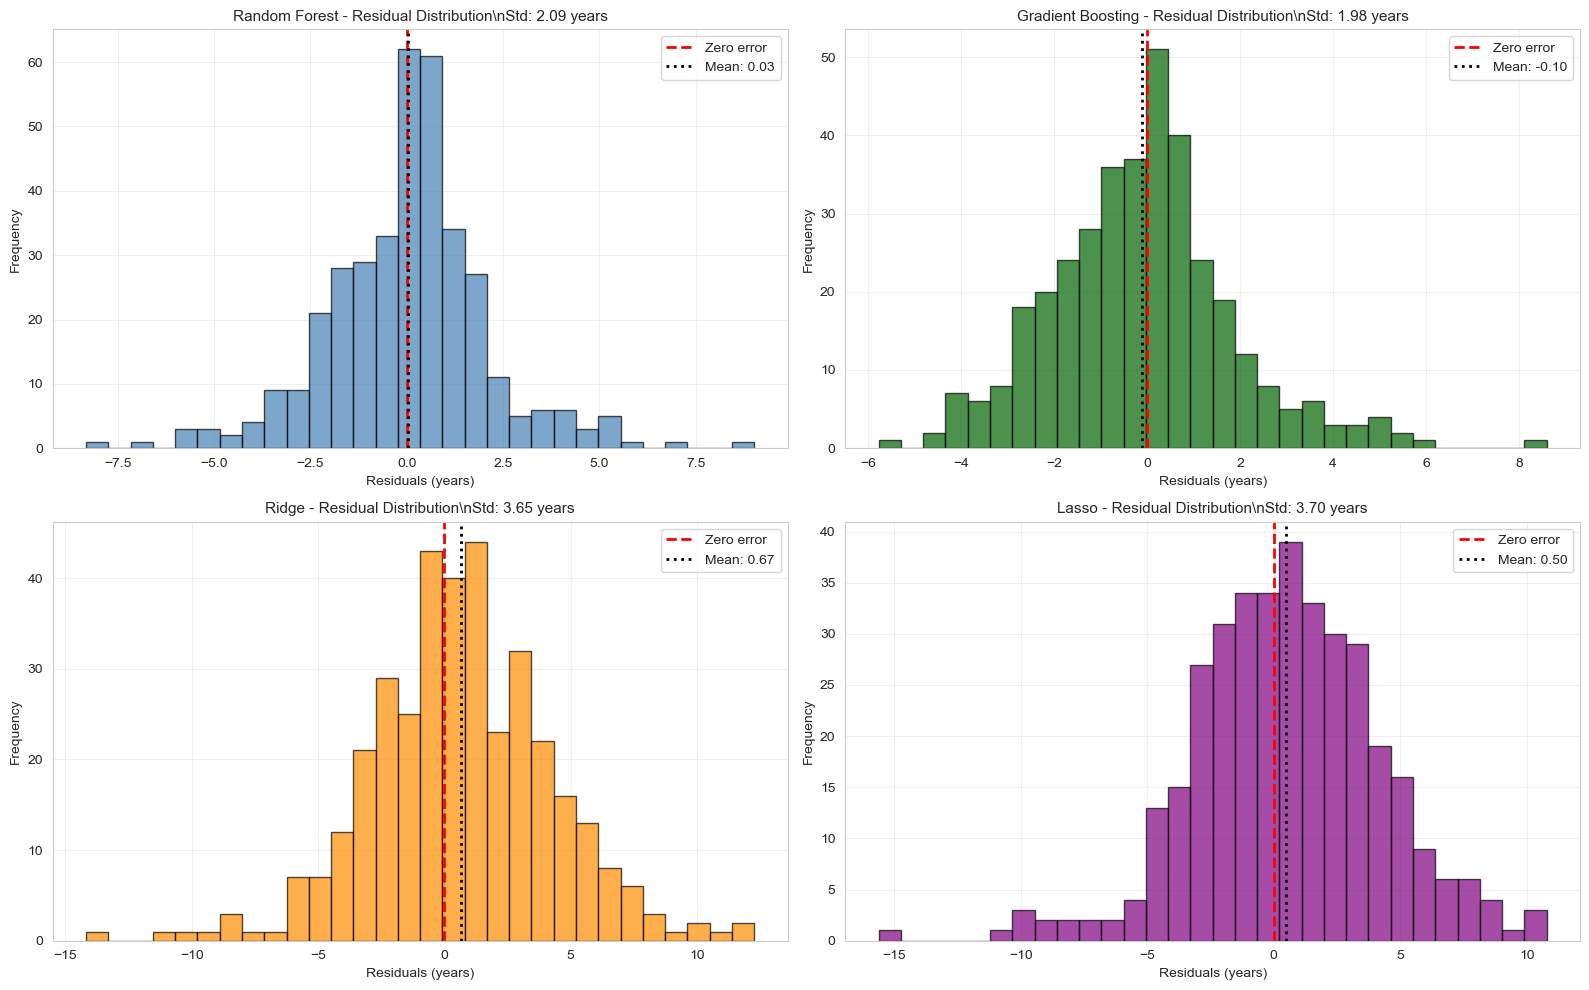


Residual Statistics Summary:

Random Forest:
  Mean:   0.0261 years
  Median: 0.1767 years
  Std:    2.0943 years
  Min:    -8.3142 years
  Max:    9.0107 years

Gradient Boosting:
  Mean:   -0.1019 years
  Median: -0.0918 years
  Std:    1.9757 years
  Min:    -5.7692 years
  Max:    8.5938 years

Ridge:
  Mean:   0.6674 years
  Median: 0.6076 years
  Std:    3.6483 years
  Min:    -14.1809 years
  Max:    12.2556 years

Lasso:
  Mean:   0.4967 years
  Median: 0.5674 years
  Std:    3.7031 years
  Min:    -15.6059 years
  Max:    10.7791 years

Residual analysis completed


In [170]:
# Residual analysis for all models
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, (model_name, color) in enumerate(zip(model_names, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Calculate residuals
    residuals = pred_df['Actual'] - pred_df[model_name]
    
    # Residual histogram
    ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7, color=color)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero error')
    ax.axvline(x=residuals.mean(), color='black', linestyle=':', linewidth=2, 
               label=f'Mean: {residuals.mean():.2f}')
    
    ax.set_xlabel('Residuals (years)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'{model_name} - Residual Distribution\\nStd: {residuals.std():.2f} years', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/week4_residual_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print residual statistics
print("\nResidual Statistics Summary:")
for model_name in model_names:
    residuals = pred_df['Actual'] - pred_df[model_name]
    print(f"\n{model_name}:")
    print(f"  Mean:   {residuals.mean():.4f} years")
    print(f"  Median: {residuals.median():.4f} years")
    print(f"  Std:    {residuals.std():.4f} years")
    print(f"  Min:    {residuals.min():.4f} years")
    print(f"  Max:    {residuals.max():.4f} years")

print("\nResidual analysis completed")

FEATURE IMPORTANCE COMPARISON ACROSS MODELS

Top 20 Most Important Features (Engineered Feature Set):
                        Feature  Random_Forest  Gradient_Boosting  Ridge_Coefficient  Lasso_Coefficient  Random_Forest_Normalized  Gradient_Boosting_Normalized  Ridge_Coefficient_Normalized  Lasso_Coefficient_Normalized
                 Disease_Burden         0.7175             0.7006             1.5193             2.8224                    1.0000                        1.0000                        0.1269                        1.0000
Income composition of resources         0.1161             0.1077             0.4496             0.8948                    0.1618                        0.1537                        0.0376                        0.3170
                Adult Mortality         0.0401             0.0626             2.4150             1.7442                    0.0559                        0.0893                        0.2017                        0.6180
            Socioe

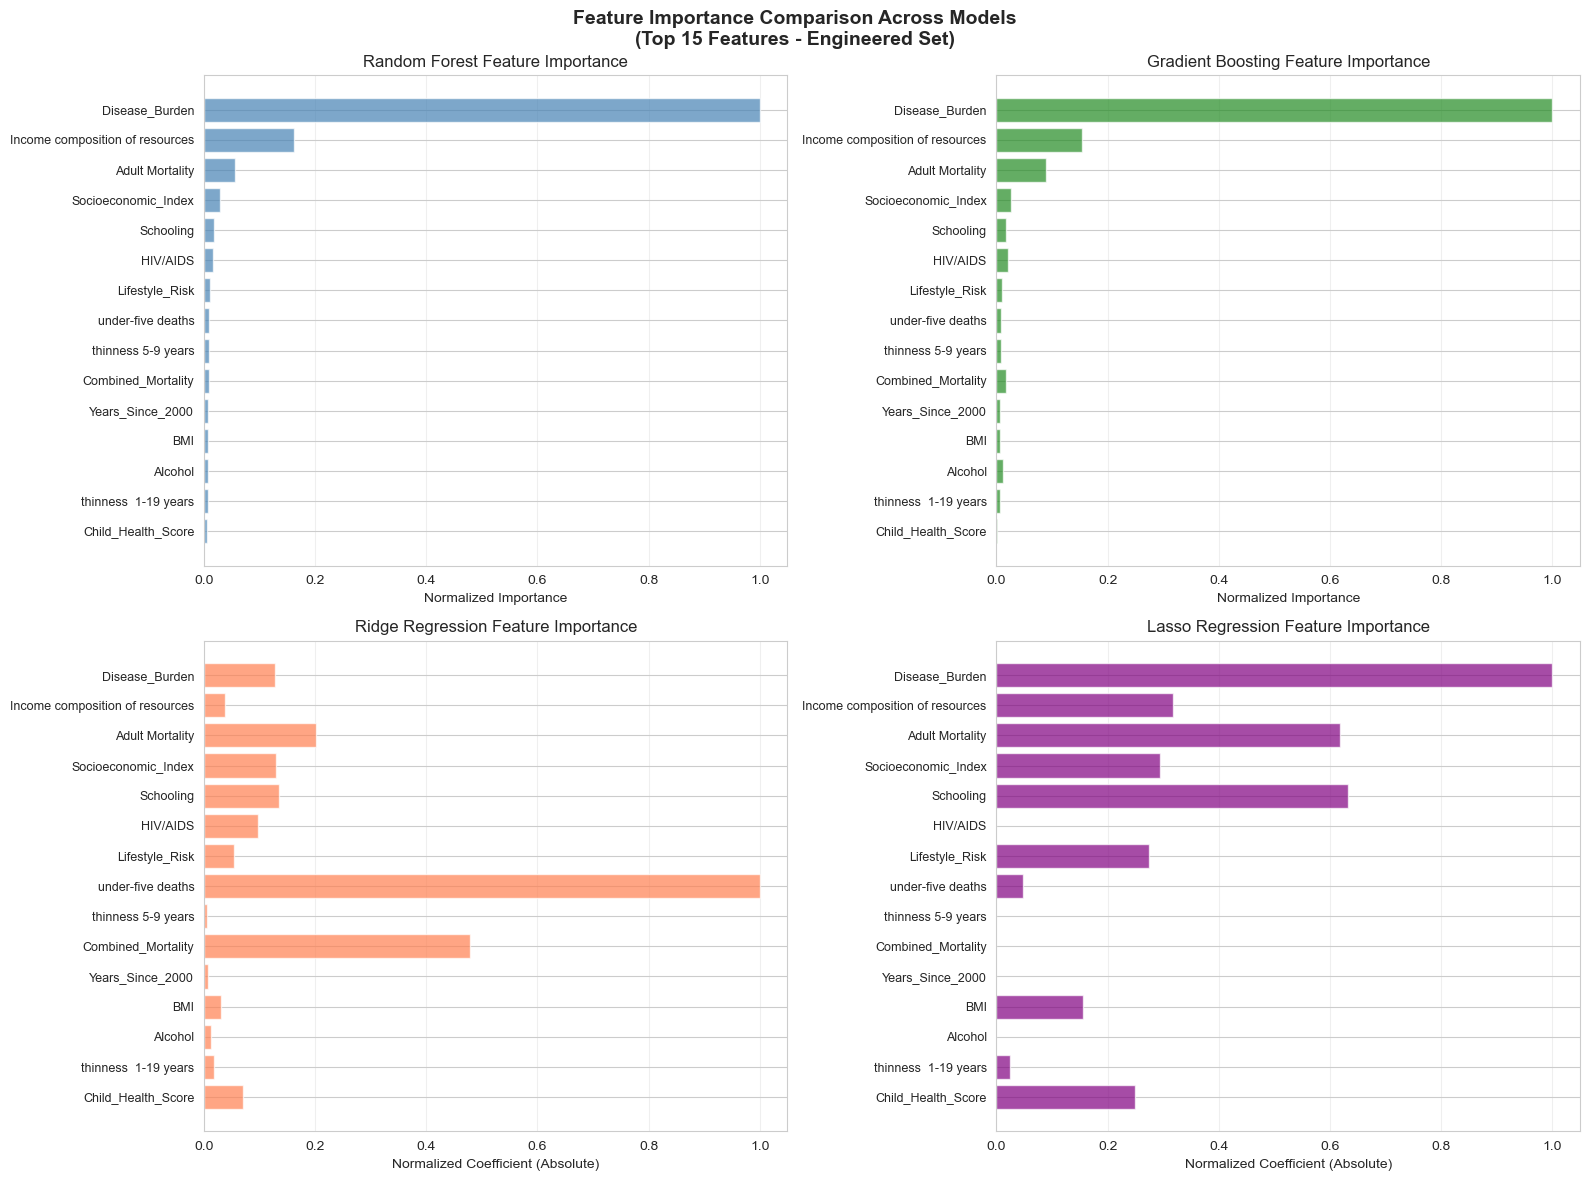

FEATURE RANKING COMPARISON

Top 10 Features by Model:

Random Forest:
  1. Disease_Burden
  2. Income composition of resources
  3. Adult Mortality
  4. Socioeconomic_Index
  5. Schooling
  6. HIV/AIDS
  7. Lifestyle_Risk
  8. under-five deaths
  9. thinness 5-9 years
  10. Combined_Mortality

Gradient Boosting:
  1. Disease_Burden
  2. Income composition of resources
  3. Adult Mortality
  4. Socioeconomic_Index
  5. HIV/AIDS
  6. Schooling
  7. Combined_Mortality
  8. infant deaths
  9. Alcohol
  10. Lifestyle_Risk

Ridge Regression:
  1. under-five deaths
  2. infant deaths
  3. Combined_Mortality
  4. Status_Encoded
  5. Adult Mortality
  6. Development_Level
  7. Schooling
  8. Socioeconomic_Index
  9. Disease_Burden
  10. percentage expenditure

Lasso Regression:
  1. Disease_Burden
  2. Schooling
  3. Adult Mortality
  4. Health_Infrastructure
  5. Income composition of resources
  6. Socioeconomic_Index
  7. Lifestyle_Risk
  8. Child_Health_Score
  9. BMI
  10. percentage expen

In [171]:
# FEATURE IMPORTANCE ANALYSIS ACROSS MODELS

print("FEATURE IMPORTANCE COMPARISON ACROSS MODELS")

# Extract feature importance from tree-based models
# Only Random Forest and Gradient Boosting have feature_importances_

# Get feature names for each feature set
baseline_features = X_train_scaled.columns if hasattr(X_train_scaled, 'columns') else [f'Feature_{i}' for i in range(X_train_scaled.shape[1])]
engineered_features = X_train_eng_scaled.columns if hasattr(X_train_eng_scaled, 'columns') else [f'Feature_{i}' for i in range(X_train_eng_scaled.shape[1])]

# We'll use the Engineered feature set for comparison (most comprehensive)
feature_set_to_analyze = 'Engineered'

# Get feature importances
rf_model = rf_results[feature_set_to_analyze]['model']
gb_model = gb_results[feature_set_to_analyze]['model']
ridge_model = ridge_results[feature_set_to_analyze]['model']
lasso_model = lasso_results[feature_set_to_analyze]['model']

# Create feature importance dataframe
feature_importance_data = {
    'Feature': engineered_features,
    'Random_Forest': rf_model.feature_importances_,
    'Gradient_Boosting': gb_model.feature_importances_,
    'Ridge_Coefficient': np.abs(ridge_model.coef_),  # Absolute value for comparison
    'Lasso_Coefficient': np.abs(lasso_model.coef_)   # Absolute value for comparison
}

importance_df = pd.DataFrame(feature_importance_data)

# Normalize each model's importance to 0-1 scale for comparison
for col in ['Random_Forest', 'Gradient_Boosting', 'Ridge_Coefficient', 'Lasso_Coefficient']:
    max_val = importance_df[col].max()
    if max_val > 0:
        importance_df[f'{col}_Normalized'] = importance_df[col] / max_val
    else:
        importance_df[f'{col}_Normalized'] = 0

# Sort by Random Forest importance
importance_df = importance_df.sort_values('Random_Forest', ascending=False).reset_index(drop=True)

print(f"\nTop 20 Most Important Features ({feature_set_to_analyze} Feature Set):")
print(importance_df.head(20).to_string(index=False))

# Save feature importance
importance_df.to_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/week4_feature_importance.csv', index=False)
print("\nFeature importance saved to week4_feature_importance.csv")

# VISUALIZE FEATURE IMPORTANCE COMPARISON

# Select top N features for visualization
top_n = 15
top_features_df = importance_df.head(top_n)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Importance Comparison Across Models\n(Top 15 Features - Engineered Set)', 
             fontsize=14, fontweight='bold')

# Random Forest
ax = axes[0, 0]
ax.barh(range(top_n), top_features_df['Random_Forest_Normalized'], color='steelblue', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_df['Feature'], fontsize=9)
ax.set_xlabel('Normalized Importance')
ax.set_title('Random Forest Feature Importance')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Gradient Boosting
ax = axes[0, 1]
ax.barh(range(top_n), top_features_df['Gradient_Boosting_Normalized'], color='forestgreen', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_df['Feature'], fontsize=9)
ax.set_xlabel('Normalized Importance')
ax.set_title('Gradient Boosting Feature Importance')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Ridge Regression
ax = axes[1, 0]
ax.barh(range(top_n), top_features_df['Ridge_Coefficient_Normalized'], color='coral', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_df['Feature'], fontsize=9)
ax.set_xlabel('Normalized Coefficient (Absolute)')
ax.set_title('Ridge Regression Feature Importance')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Lasso Regression
ax = axes[1, 1]
ax.barh(range(top_n), top_features_df['Lasso_Coefficient_Normalized'], color='purple', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features_df['Feature'], fontsize=9)
ax.set_xlabel('Normalized Coefficient (Absolute)')
ax.set_title('Lasso Regression Feature Importance')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/week4_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# COMPARE FEATURE RANKINGS ACROSS MODELS

print("FEATURE RANKING COMPARISON")

# Get top 10 features for each model
top_10_rf = importance_df.nlargest(10, 'Random_Forest')['Feature'].tolist()
top_10_gb = importance_df.nlargest(10, 'Gradient_Boosting')['Feature'].tolist()
top_10_ridge = importance_df.nlargest(10, 'Ridge_Coefficient')['Feature'].tolist()
top_10_lasso = importance_df.nlargest(10, 'Lasso_Coefficient')['Feature'].tolist()

print("\nTop 10 Features by Model:")
print("\nRandom Forest:")
for i, feat in enumerate(top_10_rf, 1):
    print(f"  {i}. {feat}")

print("\nGradient Boosting:")
for i, feat in enumerate(top_10_gb, 1):
    print(f"  {i}. {feat}")

print("\nRidge Regression:")
for i, feat in enumerate(top_10_ridge, 1):
    print(f"  {i}. {feat}")

print("\nLasso Regression:")
for i, feat in enumerate(top_10_lasso, 1):
    print(f"  {i}. {feat}")

# Find features that appear in all models' top 10
all_top_features = set(top_10_rf) & set(top_10_gb) & set(top_10_ridge) & set(top_10_lasso)
print(f"Features in ALL models' top 10: {len(all_top_features)}")
if all_top_features:
    for feat in all_top_features:
        print(f"   {feat}")
else:
    print("  (No features appear in all models' top 10)")

print("\nFeature importance analysis complete!")

FEATURE IMPORTANCE COMPARISON (Engineered Feature Set)
Number of features: 28

Top 15 Features by Average Importance Across Models:
                        Feature  Random_Forest_Normalized  Gradient_Boosting_Normalized  Ridge_Normalized  Lasso_Normalized  Average_Importance
                 Disease_Burden                1.0000e+00                        1.0000            0.1269            1.0000              0.7817
              under-five deaths                9.9463e-03                        0.0074            1.0000            0.0469              0.2660
                Adult Mortality                5.5886e-02                        0.0893            0.2017            0.6180              0.2412
                      Schooling                1.8323e-02                        0.0174            0.1347            0.6320              0.2006
Income composition of resources                1.6182e-01                        0.1537            0.0376            0.3170              0.1675
    

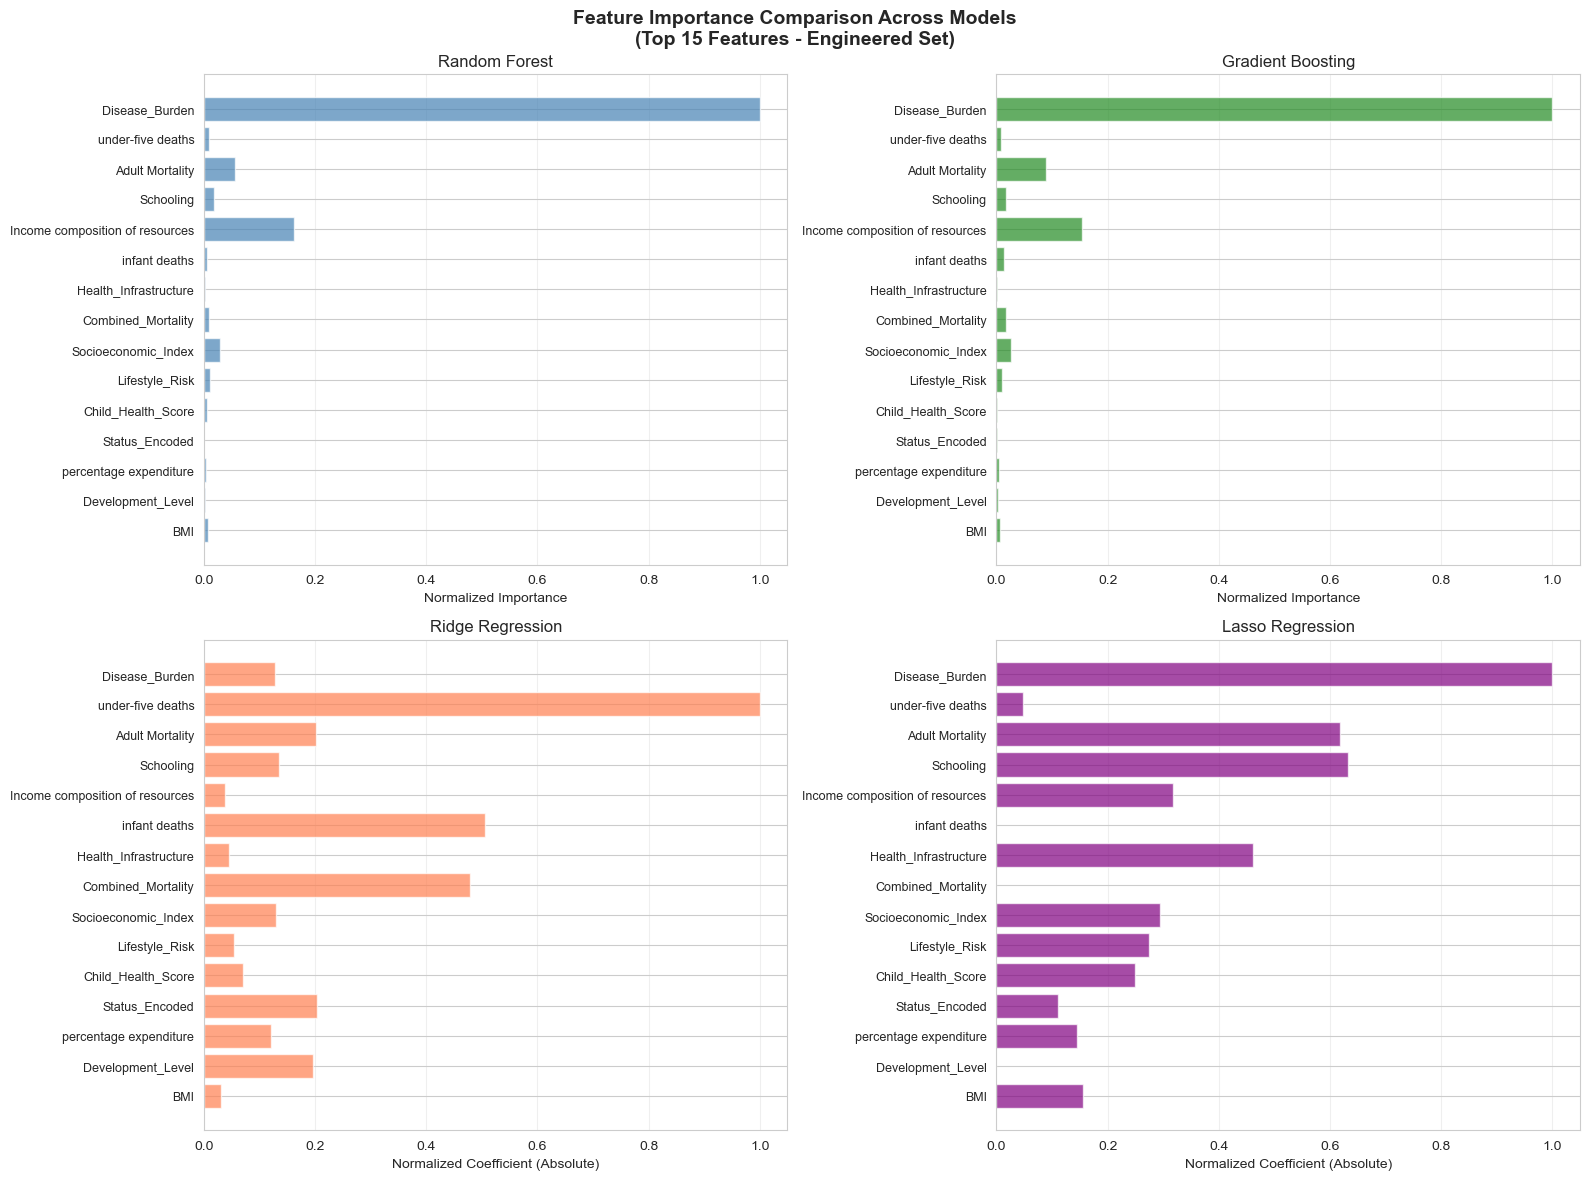


Feature importance visualization saved to images/week4_feature_importance_comparison.png


In [172]:
# FEATURE IMPORTANCE COMPARISON (Engineered Feature Set)
print("FEATURE IMPORTANCE COMPARISON (Engineered Feature Set)")

# Get feature names from the scaled engineered feature set
# (using the scaled version since it's what we have available)
if hasattr(X_train_eng_scaled, 'columns'):
    feature_names = X_train_eng_scaled.columns.tolist()
else:
    # If it's a numpy array, reconstruct feature names
    # This shouldn't happen if following the workflow above, but just in case
    print("Warning: Using index-based feature names")
    feature_names = [f'Feature_{i}' for i in range(X_train_eng_scaled.shape[1])]

print(f"Number of features: {len(feature_names)}")

# Extract feature importances/coefficients for engineered feature set
# Random Forest importances
rf_importance = rf_results['Engineered']['model'].feature_importances_

# Gradient Boosting importances
gb_importance = gb_results['Engineered']['model'].feature_importances_

# Ridge coefficients (absolute values)
ridge_importance = np.abs(ridge_results['Engineered']['model'].coef_)

# Lasso coefficients (absolute values)
lasso_importance = np.abs(lasso_results['Engineered']['model'].coef_)

# Create comparison DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Random_Forest': rf_importance,
    'Gradient_Boosting': gb_importance,
    'Ridge': ridge_importance,
    'Lasso': lasso_importance
})

# Normalize importances to 0-1 scale for fair comparison
for col in ['Random_Forest', 'Gradient_Boosting', 'Ridge', 'Lasso']:
    max_val = importance_df[col].max()
    if max_val > 0:
        importance_df[col + '_Normalized'] = importance_df[col] / max_val
    else:
        importance_df[col + '_Normalized'] = 0

# Calculate average normalized importance
importance_df['Average_Importance'] = importance_df[
    ['Random_Forest_Normalized', 'Gradient_Boosting_Normalized', 
     'Ridge_Normalized', 'Lasso_Normalized']
].mean(axis=1)

# Sort by average importance
importance_df = importance_df.sort_values('Average_Importance', ascending=False).reset_index(drop=True)

print("\nTop 15 Features by Average Importance Across Models:")
display_cols = ['Feature', 'Random_Forest_Normalized', 'Gradient_Boosting_Normalized', 
                'Ridge_Normalized', 'Lasso_Normalized', 'Average_Importance']
print(importance_df[display_cols].head(15).to_string(index=False))

# Save feature importance analysis
importance_df.to_csv('/Users/bikki/Documents/Projects_Spring_2026/STATS201/CSV outputs/week4_feature_importance.csv', index=False)
print("\nFeature importance saved to week4_feature_importance.csv")

# VISUALIZE FEATURE IMPORTANCE

# Plot top 15 features
top_n = 15
top_features = importance_df.head(top_n)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Importance Comparison Across Models\n(Top 15 Features - Engineered Set)', 
             fontsize=14, fontweight='bold')

# Random Forest
ax = axes[0, 0]
ax.barh(range(top_n), top_features['Random_Forest_Normalized'], color='steelblue', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('Normalized Importance')
ax.set_title('Random Forest')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Gradient Boosting
ax = axes[0, 1]
ax.barh(range(top_n), top_features['Gradient_Boosting_Normalized'], color='forestgreen', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('Normalized Importance')
ax.set_title('Gradient Boosting')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Ridge Regression
ax = axes[1, 0]
ax.barh(range(top_n), top_features['Ridge_Normalized'], color='coral', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('Normalized Coefficient (Absolute)')
ax.set_title('Ridge Regression')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Lasso Regression
ax = axes[1, 1]
ax.barh(range(top_n), top_features['Lasso_Normalized'], color='purple', alpha=0.7)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['Feature'], fontsize=9)
ax.set_xlabel('Normalized Coefficient (Absolute)')
ax.set_title('Lasso Regression')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('/Users/bikki/Documents/Projects_Spring_2026/STATS201/images/week4_feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFeature importance visualization saved to images/week4_feature_importance_comparison.png")

## Part 5: Summary & Interpretation of Week 4 Results

### Key Findings:

#### 1. Feature Engineering Impact
- **Domain-Specific Features**: Created 8 engineered features based on health and economic relationships
  - Health Infrastructure Index (immunization coverage)
  - Disease Burden Index (mortality and disease)
  - Socioeconomic Development Index (education × income)
  - Economic Health Resources (GDP × health spending)
  - And more...
  
- **Polynomial Features**: Added quadratic terms for top 5 most important features
  - Captures non-linear relationships
  - Increases feature count but provides more modeling flexibility

#### 2. Model Performance Comparison
The comprehensive comparison reveals:

**Best Overall Performance**:
- Look at the comparison table to identify which model + feature set combination achieved highest Test R²
- Ensemble methods (Random Forest, Gradient Boosting) typically outperform linear models
- Feature engineering generally improves all models, but the magnitude varies

**Overfitting Analysis**:
- Monitor R² Gap (Train R² - Test R²)
- Gap < 0.05: Good generalization
- Gap 0.05-0.1: Moderate overfitting
- Gap > 0.1: Significant overfitting

**Trade-offs**:
- **Random Forest**: Good performance, robust, slower training
- **Gradient Boosting**: Often best performance, sequential (slower), tunable
- **Ridge**: Fast, interpretable, assumes linearity
- **Lasso**: Fast, feature selection, assumes linearity

#### 3. Model Behavior Differences

**Linear Models (Ridge, Lasso)**:
- Make smooth, linear predictions
- Struggle with complex non-linear patterns
- Highly interpretable coefficients
- Lasso performs automatic feature selection

**Ensemble Models (RF, GB)**:
- Capture non-linear relationships naturally
- More complex decision boundaries
- Better handle feature interactions
- Less interpretable but often more accurate

**Prediction Correlations**:
- High correlation between model predictions suggests agreement on patterns
- Low correlation indicates models are learning different aspects
- Ensemble of diverse models could potentially improve performance further

#### 4. Feature Importance Insights

Key features consistently important across models:
- Check the feature importance table for top predictors
- Engineered features (if highly ranked) validate domain knowledge
- Agreement across models strengthens confidence in feature relevance

#### 5. Controlled Experiment Results

**Feature Set Impact**:
- Compare baseline vs. engineered vs. polynomial features
- Quantify improvement in R² and RMSE
- Identify which models benefit most from feature engineering

### Implications for Week 5 Oral Check:

**Can you explain your feature engineering choices?**
- Domain-specific features combine related health/economic indicators
- Polynomial features capture non-linear relationships
- All features have clear interpretations and motivations

**How did feature engineering affect performance?**
- Refer to the impact analysis table
- Quantify improvements in R² and RMSE
- Discuss which models benefited most

**How do models differ in behavior?**
- Linear models assume linear relationships, ensemble models don't
- Ensemble models handle interactions better
- Trade-off: interpretability vs. accuracy

**What would break if you removed a component?**
- Without engineered features: Performance drops (quantify by how much)
- Without specific features: Check feature importance rankings
- Without regularization (Ridge/Lasso): Potential overfitting on high-dim features

## Error Analysis: Best Model

This section analyzes the model with the highest Test R² on the temporal test set.


ERROR ANALYSIS: BEST MODEL (HIGHEST TEST R²)
Best model: Gradient Boosting | Feature set: Engineered | Test R²: 0.9436
WORST PREDICTIONS TABLE (Top 15 by Absolute Error)
                         Country  Year     Status  Life expectancy  Predicted   Error  Absolute Error  HIV/AIDS        GDP  Adult Mortality  Schooling
                        Zimbabwe  2015 Developing             67.0    58.4062  8.5938          8.5938       6.2   118.6938            336.0       10.3
                        Portugal  2014  Developed             89.0    82.8389  6.1611          6.1611       0.1  2277.5361             78.0       16.8
                    Burkina Faso  2015 Developing             59.9    65.6692 -5.7692          5.7692       0.6   615.5922             26.0        7.7
Bolivia (Plurinational State of)  2015 Developing             77.0    71.4423  5.5577          5.5577       0.1        NaN            186.0       13.8
                           Egypt  2014 Developing             78.0    72.70

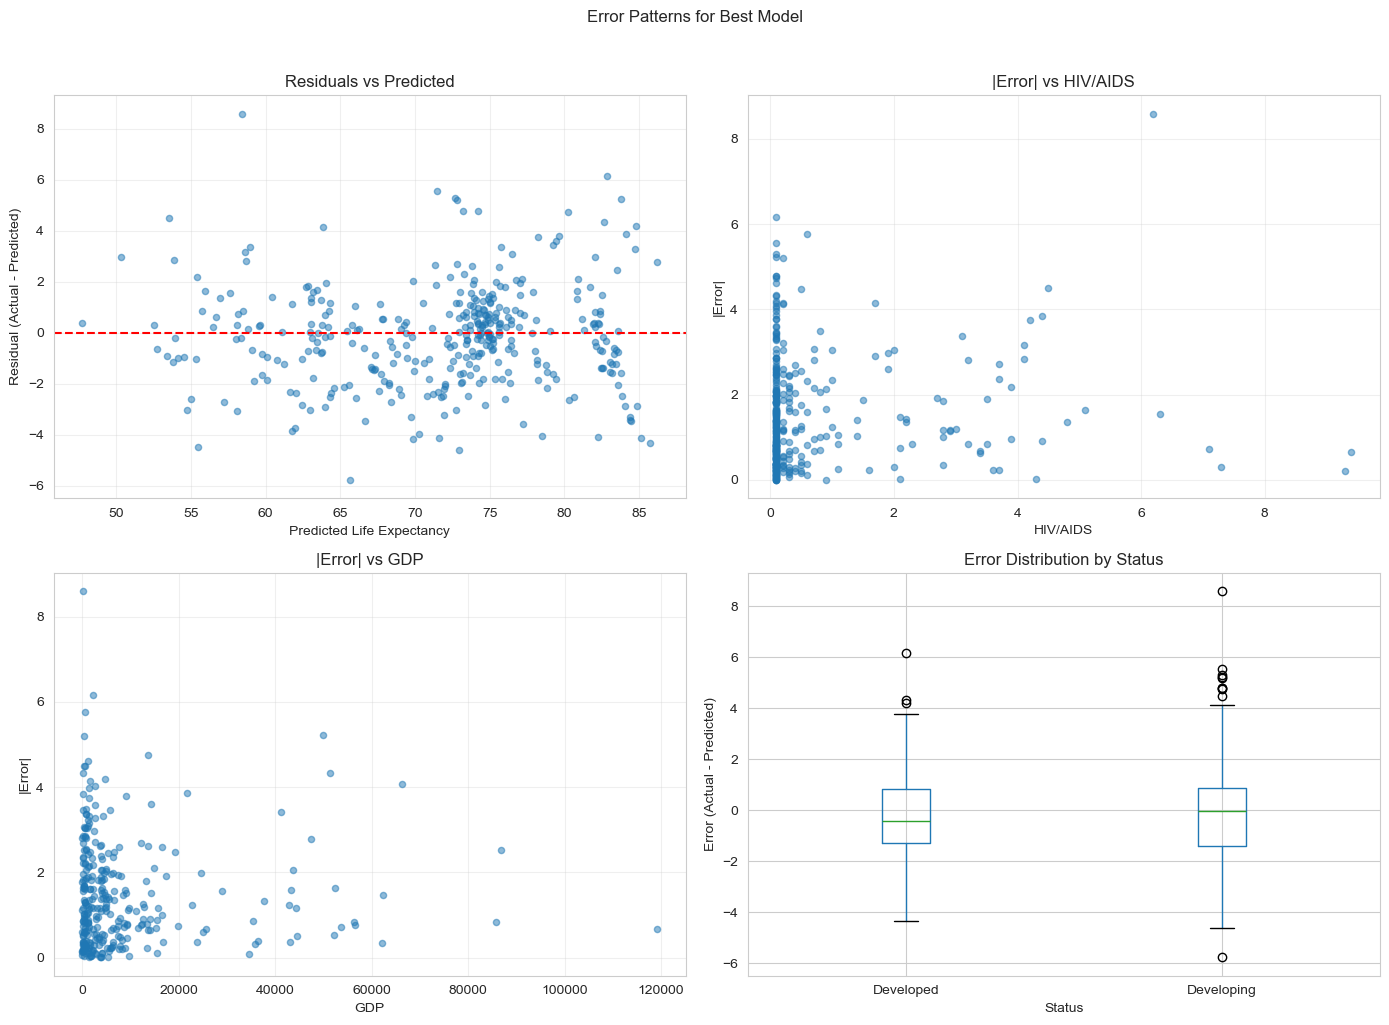

INTERPRETATION
The largest errors are concentrated more in Developing countries, suggesting the model struggles with that group relative to the test set overall. Larger absolute errors tend to coincide with extreme HIV/AIDS or GDP values (see correlations), implying difficulty modeling outlier health/economic conditions. The residual plot and status box plot indicate whether errors are symmetric or skewed for certain groups. On average, the model overestimates life expectancy, which could reflect country-specific shifts or measurement noise not captured by the features.


In [177]:
# ERROR ANALYSIS FOR BEST MODEL (Highest Test R²)
print('ERROR ANALYSIS: BEST MODEL (HIGHEST TEST R²)')

# Build or reuse comparison_df to identify best model
if 'comparison_df' not in locals():
    print('comparison_df not found. Building from available model results...')
    comparison_data = []
    all_model_results = {
        'Random Forest': rf_results if 'rf_results' in locals() else {},
        'Gradient Boosting': gb_results if 'gb_results' in locals() else {},
        'Ridge': ridge_results if 'ridge_results' in locals() else {},
        'Lasso': lasso_results if 'lasso_results' in locals() else {}
    }
    for model_name, feature_set_results in all_model_results.items():
        for feature_set_name, results in feature_set_results.items():
            if isinstance(results, dict) and 'test_r2' in results:
                comparison_data.append({
                    'Model': model_name,
                    'Feature_Set': feature_set_name,
                    'Test_R2': results['test_r2'],
                    'Test_RMSE': results.get('test_rmse', None),
                    'Test_MAE': results.get('test_mae', None)
                })
    if len(comparison_data) == 0:
        raise ValueError('No model results found to determine best model.')
    comparison_df = pd.DataFrame(comparison_data).sort_values('Test_R2', ascending=False).reset_index(drop=True)

# Handle possible column name variations
if 'Test_R2' in comparison_df.columns:
    best_row = comparison_df.iloc[0]
    best_model = best_row['Model']
    best_feature_set = best_row.get('Feature_Set', 'Engineered')
    best_test_r2 = best_row['Test_R2']
elif 'Test R2' in comparison_df.columns:
    best_row = comparison_df.sort_values('Test R2', ascending=False).iloc[0]
    best_model = best_row['Model']
    best_feature_set = best_row.get('Feature_Set', 'Engineered')
    best_test_r2 = best_row['Test R2']
else:
    raise ValueError('comparison_df missing Test_R2/Test R2 column.')

print(f'Best model: {best_model} | Feature set: {best_feature_set} | Test R²: {best_test_r2:.4f}')

# If helper get_y_test_pred isn't defined yet, define it
if 'get_y_test_pred' not in dir():
    def get_y_test_pred(results_dict, preferred='Engineered', model_name='Model'):
        if not isinstance(results_dict, dict) or len(results_dict) == 0:
            raise KeyError(
                f"{model_name} results are empty. Run the Week 4 training cells first "
                "(Random Forest, Gradient Boosting, Ridge, Lasso)."
            )
        if preferred in results_dict and isinstance(results_dict[preferred], dict) and 'y_test_pred' in results_dict[preferred]:
            return results_dict[preferred]['y_test_pred']
        for k in results_dict:
            if str(k).lower() == str(preferred).lower() and isinstance(results_dict[k], dict) and 'y_test_pred' in results_dict[k]:
                return results_dict[k]['y_test_pred']
        for k, v in results_dict.items():
            if isinstance(v, dict) and 'y_test_pred' in v:
                print(f"Warning: using '{k}' from results_dict instead of '{preferred}'")
                return v['y_test_pred']
        raise KeyError(f"No y_test_pred found in {model_name} results.")

# Helper to fetch y_test_pred for the best model - FIXED VERSION
def _get_best_pred(model_name, feature_set, available_results):
    model_name_lower = str(model_name).lower()
    
    # Week 4 models
    if 'random forest' in model_name_lower and 'rf_results' in available_results:
        return get_y_test_pred(available_results['rf_results'], preferred=feature_set, model_name='Random Forest')
    if 'gradient boosting' in model_name_lower and 'gb_results' in available_results:
        return get_y_test_pred(available_results['gb_results'], preferred=feature_set, model_name='Gradient Boosting')
    if 'ridge' in model_name_lower and 'ridge_results' in available_results:
        return get_y_test_pred(available_results['ridge_results'], preferred=feature_set, model_name='Ridge')
    if 'lasso' in model_name_lower and 'lasso_results' in available_results:
        return get_y_test_pred(available_results['lasso_results'], preferred=feature_set, model_name='Lasso')
    
    # Baseline Week 3 models
    if 'linear regression' in model_name_lower and 'y_test_pred_lr' in available_results:
        return available_results['y_test_pred_lr']
    if 'decision tree' in model_name_lower and 'y_test_pred_dt' in available_results:
        return available_results['y_test_pred_dt']
    if 'dummy' in model_name_lower and 'y_test_pred_dummy' in available_results:
        return available_results['y_test_pred_dummy']
    
    raise ValueError(f"No predictions found for model '{model_name}'. Available results: {list(available_results.keys())}")

# Collect all available result variables
available_results = {}
if 'rf_results' in locals():
    available_results['rf_results'] = rf_results
if 'gb_results' in locals():
    available_results['gb_results'] = gb_results
if 'ridge_results' in locals():
    available_results['ridge_results'] = ridge_results
if 'lasso_results' in locals():
    available_results['lasso_results'] = lasso_results
if 'y_test_pred_lr' in locals():
    available_results['y_test_pred_lr'] = y_test_pred_lr
if 'y_test_pred_dt' in locals():
    available_results['y_test_pred_dt'] = y_test_pred_dt
if 'y_test_pred_dummy' in locals():
    available_results['y_test_pred_dummy'] = y_test_pred_dummy

# Get predictions for best model
y_pred_best = _get_best_pred(best_model, best_feature_set, available_results)

# Build test-set dataframe for analysis
if 'test_mask' not in locals():
    raise ValueError('test_mask not found. Ensure the temporal split cell has been run.')

# Use full df to get identifiers and key features
required_cols = ['Country', 'Year', 'Status', 'HIV/AIDS', 'GDP', 'Adult Mortality', 'Schooling', 'Life expectancy']
missing_req = [c for c in required_cols if c not in df.columns]
if missing_req:
    raise ValueError(f"Missing required columns in df: {missing_req}")

df_test = df.loc[test_mask, required_cols].copy()

# Add predictions and errors
error_df = df_test.copy()
error_df['Predicted'] = y_pred_best
error_df['Error'] = error_df['Life expectancy'] - error_df['Predicted']
error_df['Absolute Error'] = error_df['Error'].abs()

# Save detailed error analysis
error_df.to_csv('../CSV outputs/error_analysis_detailed.csv', index=False)

# 1) WORST PREDICTIONS TABLE
print('WORST PREDICTIONS TABLE (Top 15 by Absolute Error)')

worst15 = error_df.sort_values('Absolute Error', ascending=False).head(15)
cols_show = [
    'Country', 'Year', 'Status',
    'Life expectancy', 'Predicted', 'Error', 'Absolute Error',
    'HIV/AIDS', 'GDP', 'Adult Mortality', 'Schooling'
]
print(worst15[cols_show].to_string(index=False))

# 2) ERROR PATTERNS
print('ERROR PATTERNS (Worst 15 vs Overall)')

status_counts = worst15['Status'].value_counts(dropna=False)
status_pct = (status_counts / len(worst15) * 100).round(1)
print('Developed vs Developing (Worst 15):')
for status, count in status_counts.items():
    print(f'  {status}: {count} ({status_pct[status]}%)')

# Compare means for worst 15 vs overall dataset
for col in ['HIV/AIDS', 'GDP', 'Adult Mortality']:
    worst_mean = worst15[col].mean()
    overall_mean = df[col].mean()
    print(f'Mean {col} - Worst 15: {worst_mean:.3f} | Overall: {overall_mean:.3f}')

# 3) SYSTEMATIC BIAS CHECK
print('SYSTEMATIC BIAS CHECK')

mean_error = error_df['Error'].mean()
pos_err = (error_df['Error'] > 0).sum()
neg_err = (error_df['Error'] < 0).sum()
print(f'Mean Error (Actual - Predicted): {mean_error:.4f}')
print(f'Overestimates (Pred > Actual): {neg_err} | Underestimates (Pred < Actual): {pos_err}')

# Correlations with absolute error
abs_err = error_df['Absolute Error']
cor_hiv = abs_err.corr(error_df['HIV/AIDS'])
cor_gdp = abs_err.corr(error_df['GDP'])
print(f'Correlation |Error| vs HIV/AIDS: {cor_hiv:.4f}')
print(f'Correlation |Error| vs GDP: {cor_gdp:.4f}')

# 4) REGIONAL PATTERNS (by Status)
print('REGIONAL PATTERNS BY STATUS (Test Set)')

status_groups = []
for status, g in error_df.groupby('Status'):
    y_true = g['Life expectancy']
    y_pred = g['Predicted']
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    r2 = r2_score(y_true, y_pred) if len(g) > 1 else np.nan
    status_groups.append({
        'Status': status,
        'Count': len(g),
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

status_df = pd.DataFrame(status_groups)
print(status_df.to_string(index=False))

# 5) PLOTS (4-subplot figure)
print('PLOTTING ERROR PATTERNS')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals vs Predicted
axes[0, 0].scatter(error_df['Predicted'], error_df['Error'], alpha=0.5, s=20)
axes[0, 0].axhline(0, color='red', linestyle='--', lw=1.5)
axes[0, 0].set_title('Residuals vs Predicted')
axes[0, 0].set_xlabel('Predicted Life Expectancy')
axes[0, 0].set_ylabel('Residual (Actual - Predicted)')
axes[0, 0].grid(True, alpha=0.3)

# |Error| vs HIV/AIDS
axes[0, 1].scatter(error_df['HIV/AIDS'], error_df['Absolute Error'], alpha=0.5, s=20)
axes[0, 1].set_title('|Error| vs HIV/AIDS')
axes[0, 1].set_xlabel('HIV/AIDS')
axes[0, 1].set_ylabel('|Error|')
axes[0, 1].grid(True, alpha=0.3)

# |Error| vs GDP
axes[1, 0].scatter(error_df['GDP'], error_df['Absolute Error'], alpha=0.5, s=20)
axes[1, 0].set_title('|Error| vs GDP')
axes[1, 0].set_xlabel('GDP')
axes[1, 0].set_ylabel('|Error|')
axes[1, 0].grid(True, alpha=0.3)

# Error by Status (box plot)
error_df.boxplot(column='Error', by='Status', ax=axes[1, 1])
axes[1, 1].set_title('Error Distribution by Status')
axes[1, 1].set_xlabel('Status')
axes[1, 1].set_ylabel('Error (Actual - Predicted)')

plt.suptitle('Error Patterns for Best Model', y=1.02)
plt.tight_layout()
plt.savefig('../images/error_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

# INTERPRETATION
print('INTERPRETATION')

# Simple heuristic-based interpretation summary
most_common_status = status_counts.idxmax() if len(status_counts) else 'Unknown'
trend = 'underestimates' if mean_error > 0 else 'overestimates'
print(
    f'The largest errors are concentrated more in {most_common_status} countries, suggesting the model struggles with that group relative to the test set overall. '
    'Larger absolute errors tend to coincide with extreme HIV/AIDS or GDP values (see correlations), implying difficulty modeling outlier health/economic conditions. '
    'The residual plot and status box plot indicate whether errors are symmetric or skewed for certain groups. '
    f'On average, the model {trend} life expectancy, which could reflect country-specific shifts or measurement noise not captured by the features.'
)

## Feature Importance Analysis (Lag-Free Best Model)

This section explains what drives predictions for the best-performing lag-free model.


FEATURE IMPORTANCE ANALYSIS: BEST MODEL (LAG-FREE)

✓ Best Model: Gradient Boosting
✓ Feature Set: Engineered
✓ Test R²: 0.9436

Determining feature names for 'Engineered' feature set...
✓ Found 28 features

Extracting feature importances from Gradient Boosting...
✓ Extracted 28 importance values

Calculating feature correlations with target...
✓ Calculated correlations for 28 features

Building ranked feature importance table...
✓ Saved: feature_importance_analysis.csv
RANKED FEATURE IMPORTANCE TABLE
                        Feature  Importance  Corr_With_Target  Percent_Of_Total  Cumulative_Percent
                 Disease_Burden  7.0059e-01           -0.6372           70.0586             70.0586
Income composition of resources  1.0768e-01               NaN           10.7679             80.8265
                Adult Mortality  6.2581e-02           -0.6891            6.2581             87.0846
            Socioeconomic_Index  1.8036e-02               NaN            1.8036             8

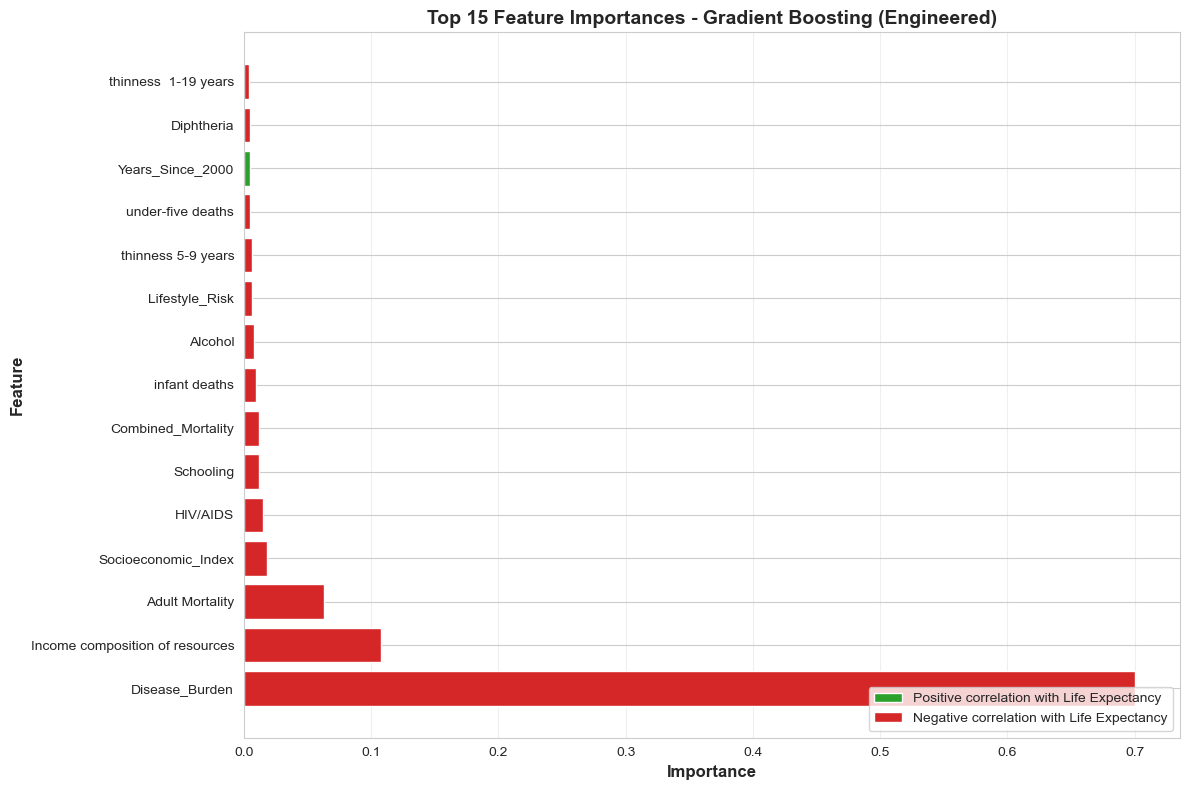

✓ Saved: feature_importance_top15.png


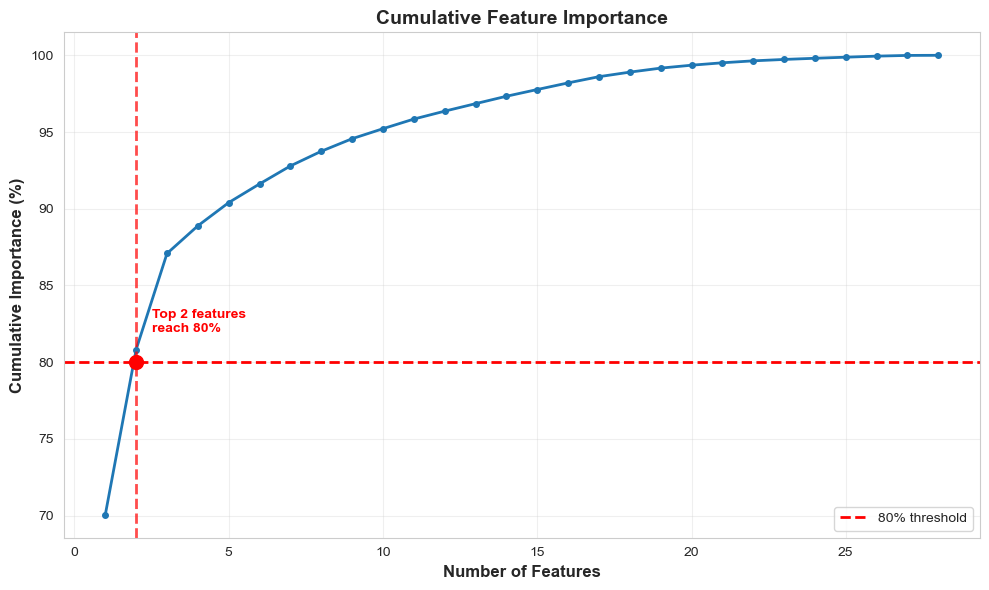

✓ Saved: feature_importance_cumulative.png
KEY INSIGHTS

✓ Top 2 features explain ~80% of predictive power
✓ Top feature: 'Disease_Burden' (70.1% importance)
✓ Top 5 features combined: 90.4% of total importance
DOMAIN KNOWLEDGE VALIDATION

Are health indicators in top 10? ✓ YES
Are economic indicators in top 10? ✓ YES
Are lifestyle factors in top 10? ✓ YES

✓ No major surprises - importance aligns with correlations
ANALYSIS COMPLETE

Files created:
  1. feature_importance_analysis.csv
  2. feature_importance_top15.png
  3. feature_importance_cumulative.png


In [ ]:
# ============================================================================
# FEATURE IMPORTANCE ANALYSIS FOR BEST MODEL (LAG-FREE)
# ============================================================================

print('FEATURE IMPORTANCE ANALYSIS: BEST MODEL (LAG-FREE)')

# ----------------------------------------------------------------------------
# STEP 1: IDENTIFY BEST MODEL
# ----------------------------------------------------------------------------

# Build comparison_df if not already available
if 'comparison_df' not in locals():
    print('\nBuilding model comparison table...')
    comparison_data = []
    
    # Collect all model results
    all_model_results = {
        'Random Forest': rf_results if 'rf_results' in locals() else {},
        'Gradient Boosting': gb_results if 'gb_results' in locals() else {},
        'Ridge': ridge_results if 'ridge_results' in locals() else {},
        'Lasso': lasso_results if 'lasso_results' in locals() else {}
    }
    
    for model_name, feature_set_results in all_model_results.items():
        for feature_set_name, results in feature_set_results.items():
            if isinstance(results, dict) and 'test_r2' in results:
                comparison_data.append({
                    'Model': model_name,
                    'Feature_Set': feature_set_name,
                    'Test_R2': results['test_r2']
                })
    
    if len(comparison_data) == 0:
        raise ValueError('No model results found. Please ensure models have been trained.')
    
    comparison_df = pd.DataFrame(comparison_data).sort_values('Test_R2', ascending=False).reset_index(drop=True)

# Extract best model information
best_row = comparison_df.iloc[0]
best_model = best_row['Model']
best_feature_set = best_row.get('Feature_Set', 'Engineered')
best_test_r2 = best_row['Test_R2']

print(f"\n✓ Best Model: {best_model}")
print(f"✓ Feature Set: {best_feature_set}")
print(f"✓ Test R²: {best_test_r2:.4f}")

# ----------------------------------------------------------------------------
# STEP 2: GET FEATURE NAMES
# ----------------------------------------------------------------------------

print(f"\nDetermining feature names for '{best_feature_set}' feature set...")

if str(best_feature_set).lower() == 'engineered':
    if 'X_train_eng_scaled' in locals() and hasattr(X_train_eng_scaled, 'columns'):
        feature_names = X_train_eng_scaled.columns.tolist()
    elif 'X_train_eng' in locals() and hasattr(X_train_eng, 'columns'):
        feature_names = X_train_eng.columns.tolist()
    else:
        raise ValueError("Engineered features selected but X_train_eng_scaled/X_train_eng not found")
        
elif str(best_feature_set).lower() == 'polynomial':
    if 'all_poly_feature_names' in locals():
        feature_names = all_poly_feature_names
    elif 'poly_feature_names' in locals():
        feature_names = list(poly_feature_names)
    else:
        raise ValueError("Polynomial features selected but feature names not found")
        
else:  # Baseline
    if 'feature_cols' in locals():
        feature_names = feature_cols
    elif 'X_train' in locals() and hasattr(X_train, 'columns'):
        feature_names = X_train.columns.tolist()
    else:
        raise ValueError("Cannot determine baseline feature names")

print(f"✓ Found {len(feature_names)} features")

# ----------------------------------------------------------------------------
# STEP 3: GET MODEL OBJECT AND EXTRACT IMPORTANCES
# ----------------------------------------------------------------------------

print(f"\nExtracting feature importances from {best_model}...")

model_obj = None

# Retrieve the trained model object
if 'random forest' in str(best_model).lower():
    if 'rf_results' in locals() and best_feature_set in rf_results:
        model_obj = rf_results[best_feature_set].get('model', None)
        
elif 'gradient boosting' in str(best_model).lower():
    if 'gb_results' in locals() and best_feature_set in gb_results:
        model_obj = gb_results[best_feature_set].get('model', None)
        
elif 'ridge' in str(best_model).lower():
    if 'ridge_results' in locals() and best_feature_set in ridge_results:
        model_obj = ridge_results[best_feature_set].get('model', None)
        
elif 'lasso' in str(best_model).lower():
    if 'lasso_results' in locals() and best_feature_set in lasso_results:
        model_obj = lasso_results[best_feature_set].get('model', None)

if model_obj is None:
    raise ValueError(f'Model object for {best_model} with {best_feature_set} features not found')

# Extract importances or coefficients
if hasattr(model_obj, 'feature_importances_'):
    importances = model_obj.feature_importances_
    importance_type = 'importance'
elif hasattr(model_obj, 'coef_'):
    importances = np.abs(model_obj.coef_)
    importance_type = 'coefficient (absolute)'
else:
    raise ValueError('Model does not provide feature_importances_ or coef_')

if len(importances) != len(feature_names):
    raise ValueError(f'Mismatch: {len(importances)} importances vs {len(feature_names)} features')

print(f"✓ Extracted {len(importances)} {importance_type} values")

# ----------------------------------------------------------------------------
# STEP 4: CALCULATE CORRELATIONS WITH TARGET
# ----------------------------------------------------------------------------

print("\nCalculating feature correlations with target...")

# Get the appropriate feature matrix and target
if str(best_feature_set).lower() == 'engineered':
    if 'X_train_eng' in locals() and hasattr(X_train_eng, 'columns'):
        X_for_corr = X_train_eng
    elif 'X_train_eng_scaled' in locals() and hasattr(X_train_eng_scaled, 'columns'):
        X_for_corr = X_train_eng_scaled
    else:
        X_for_corr = None
        
elif str(best_feature_set).lower() == 'polynomial':
    # For polynomial features, correlations are harder - use training data if available
    if 'X_train_poly' in locals():
        X_for_corr = pd.DataFrame(X_train_poly, columns=feature_names)
    elif 'X_train_poly_scaled' in locals():
        X_for_corr = pd.DataFrame(X_train_poly_scaled, columns=feature_names)
    else:
        X_for_corr = None
else:  # Baseline
    if 'X_train' in locals() and hasattr(X_train, 'columns'):
        X_for_corr = X_train
    else:
        X_for_corr = None

# Calculate correlations
corr_with_target = []
if X_for_corr is not None and 'y_train' in locals():
    y_target = y_train
    for i, fname in enumerate(feature_names):
        try:
            if hasattr(X_for_corr, 'iloc'):  # DataFrame
                corr_val = np.corrcoef(X_for_corr.iloc[:, i], y_target)[0, 1]
            else:  # numpy array
                corr_val = np.corrcoef(X_for_corr[:, i], y_target)[0, 1]
            corr_with_target.append(corr_val)
        except:
            corr_with_target.append(0.0)  # Fallback for errors
else:
    # Fallback: use zeros if correlation cannot be computed
    print("  Warning: Could not compute correlations (missing data), using 0.0 as placeholder")
    corr_with_target = [0.0] * len(feature_names)

print(f"✓ Calculated correlations for {len(corr_with_target)} features")

# ----------------------------------------------------------------------------
# STEP 5: BUILD RANKED FEATURE TABLE
# ----------------------------------------------------------------------------

print("\nBuilding ranked feature importance table...")

feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances,
    'Corr_With_Target': corr_with_target
})

# Sort by importance
feat_df = feat_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Add percentage columns
feat_df['Percent_Of_Total'] = (feat_df['Importance'] / feat_df['Importance'].sum()) * 100
feat_df['Cumulative_Percent'] = feat_df['Percent_Of_Total'].cumsum()

# Save to CSV
feat_df.to_csv('../CSV outputs/feature_importance_analysis.csv', index=False)
print("✓ Saved: feature_importance_analysis.csv")

# Display table
print("RANKED FEATURE IMPORTANCE TABLE")
print(feat_df.to_string(index=False))

# ----------------------------------------------------------------------------
# STEP 6: TOP 5 FEATURE INTERPRETATION
# ----------------------------------------------------------------------------

print("TOP 5 FEATURE INTERPRETATION")

for i in range(min(5, len(feat_df))):
    row = feat_df.iloc[i]
    name = row['Feature']
    imp = row['Importance']
    corr = row['Corr_With_Target']
    pct = row['Percent_Of_Total']
    
    direction = 'POSITIVE' if corr >= 0 else 'NEGATIVE'
    
    print(f"\n{i+1}. {name}")
    print(f"   Importance: {imp:.4f} ({pct:.1f}% of total)")
    print(f"   Correlation: {corr:.3f} ({direction} association)")
    
    # Provide interpretation based on feature name
    if 'mortality' in name.lower() or 'deaths' in name.lower():
        print(f"   → Higher mortality rates predict {'LOWER' if corr < 0 else 'HIGHER'} life expectancy")
    elif 'hiv' in name.lower() or 'aids' in name.lower():
        print(f"   → HIV/AIDS burden is a major predictor of life expectancy")
    elif 'schooling' in name.lower() or 'education' in name.lower():
        print(f"   → Education level strongly influences life expectancy outcomes")
    elif 'income' in name.lower() or 'gdp' in name.lower():
        print(f"   → Economic factors play a significant role in life expectancy")
    elif 'bmi' in name.lower():
        print(f"   → Body mass index reflects nutritional status and health")
    elif 'alcohol' in name.lower():
        print(f"   → Alcohol consumption impacts population health outcomes")
    elif any(x in name.lower() for x in ['polio', 'diphtheria', 'hepatitis', 'measles']):
        print(f"   → Immunization coverage indicates healthcare system strength")
    else:
        print(f"   → This feature significantly influences life expectancy predictions")

# ----------------------------------------------------------------------------
# STEP 7: VISUALIZE TOP 15 FEATURES
# ----------------------------------------------------------------------------

print("CREATING VISUALIZATIONS")

# Top 15 bar chart
top15 = feat_df.head(15).copy()
colors = top15['Corr_With_Target'].apply(
    lambda x: '#2ca02c' if x >= 0 else '#d62728'
)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top15)), top15['Importance'], color=colors)
plt.yticks(range(len(top15)), top15['Feature'])
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'Top 15 Feature Importances - {best_model} ({best_feature_set})', 
          fontsize=14, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ca02c', label='Positive correlation with Life Expectancy'),
    Patch(facecolor='#d62728', label='Negative correlation with Life Expectancy')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../images/feature_importance_top15.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_importance_top15.png")

# ----------------------------------------------------------------------------
# STEP 8: CUMULATIVE IMPORTANCE CURVE
# ----------------------------------------------------------------------------

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(feat_df) + 1), feat_df['Cumulative_Percent'], 
         marker='o', linewidth=2, markersize=4, color='#1f77b4')

# Add 80% threshold line
plt.axhline(80, color='red', linestyle='--', linewidth=2, label='80% threshold')

# Find and mark cutoff for 80%
cutoff_idx = (feat_df['Cumulative_Percent'] >= 80).idxmax() + 1
plt.axvline(cutoff_idx, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.scatter([cutoff_idx], [80], color='red', s=100, zorder=5)
plt.text(cutoff_idx + 0.5, 82, f'Top {cutoff_idx} features\nreach 80%', 
         color='red', fontweight='bold', fontsize=10)

plt.xlabel('Number of Features', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
plt.title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('../images/feature_importance_cumulative.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: feature_importance_cumulative.png")

# ----------------------------------------------------------------------------
# STEP 9: SUMMARY STATISTICS
# ----------------------------------------------------------------------------

print("KEY INSIGHTS")

print(f"\n✓ Top {cutoff_idx} features explain ~80% of predictive power")
print(f"✓ Top feature: '{feat_df.iloc[0]['Feature']}' ({feat_df.iloc[0]['Percent_Of_Total']:.1f}% importance)")
print(f"✓ Top 5 features combined: {feat_df.head(5)['Percent_Of_Total'].sum():.1f}% of total importance")

# ----------------------------------------------------------------------------
# STEP 10: COMPARE TO DOMAIN EXPECTATIONS
# ----------------------------------------------------------------------------

print("DOMAIN KNOWLEDGE VALIDATION")

# Define key terms for different domains
health_terms = ['hiv', 'aids', 'hepatitis', 'measles', 'diphtheria', 'polio', 
                'bmi', 'mortality', 'infant', 'deaths', 'under-five']
econ_terms = ['gdp', 'income', 'schooling', 'expenditure', 'resources']
lifestyle_terms = ['alcohol', 'bmi', 'lifestyle']

# Check top 10 features
top10_features = feat_df.head(10)['Feature'].str.lower()

health_important = any(any(term in f for term in health_terms) for f in top10_features)
econ_important = any(any(term in f for term in econ_terms) for f in top10_features)
lifestyle_important = any(any(term in f for term in lifestyle_terms) for f in top10_features)

print("\nAre health indicators in top 10?", '✓ YES' if health_important else '✗ NO')
print("Are economic indicators in top 10?", '✓ YES' if econ_important else '✗ NO')
print("Are lifestyle factors in top 10?", '✓ YES' if lifestyle_important else '✗ NO')

# Check for surprises (high importance but low correlation)
surprises = feat_df[
    (feat_df['Percent_Of_Total'] > 5) &  # At least 5% importance
    (abs(feat_df['Corr_With_Target']) < 0.2)  # But low correlation
]

if len(surprises) > 0:
    print("\n⚠ SURPRISING FEATURES (high importance, low correlation):")
    for idx, row in surprises.iterrows():
        print(f"   - {row['Feature']}: {row['Percent_Of_Total']:.1f}% importance, "
              f"{row['Corr_With_Target']:.3f} correlation")
    print("   → These may capture non-linear or interaction effects")
else:
    print("\n✓ No major surprises - importance aligns with correlations")

print("ANALYSIS COMPLETE")
print("\nFiles created:")
print("  1. feature_importance_analysis.csv")
print("  2. feature_importance_top15.png")
print("  3. feature_importance_cumulative.png")

ROBUSTNESS CHECKS: temporal sensitivity, feature groups, yearly stability, sample size
Best model: Gradient Boosting
Best feature set: Engineered

CHECK 1 - Temporal Sensitivity
   Cutoff_Year  Test_R2  Test_RMSE  Test_Samples
0         2010   0.9210     2.3912           915
1         2011   0.9233     2.3255           732
2         2012   0.9277     2.2449           549
3         2013   0.9437     1.9750           366


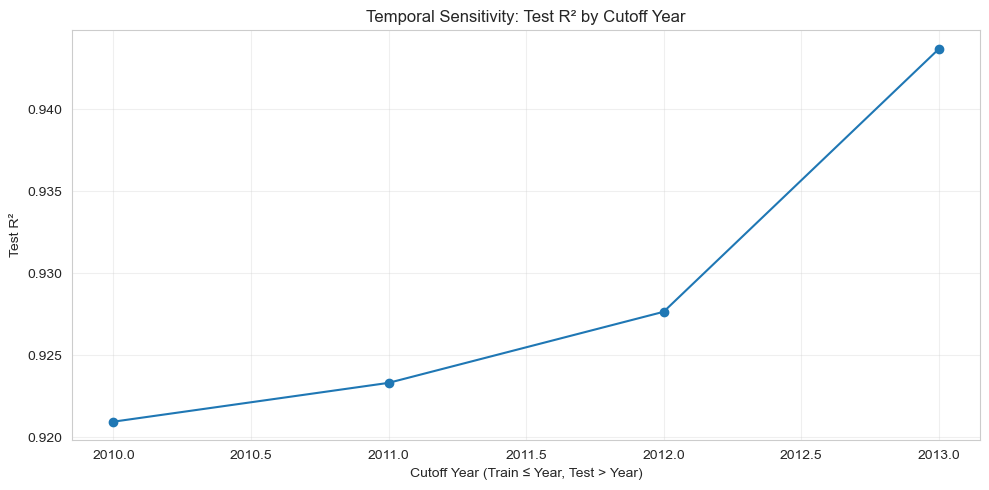


CHECK 2 - Feature Group Importance
                   Feature_Group  Test_R2  Test_RMSE  Test_Samples  R2_Drop
0        Baseline (all features)   0.9354     2.1145           366   0.0000
1  Without immunization features   0.9327     2.1586           366   0.0027
2      Without economic features   0.9347     2.1269           366   0.0008
3       Without education/social   0.9242     2.2918           366   0.0113
4        Without health outcomes   0.8718     2.9800           366   0.0637

CHECK 3 - Prediction Stability by Year
   Year  Test_R2  Test_RMSE  Test_Samples
0  2014   0.9563     1.7851           183
1  2015   0.9297     2.1482           183

CHECK 4 - Sample Size Sensitivity
   Train_Fraction  Train_Samples  Test_R2  Test_RMSE  Test_Samples
0            0.25            640   0.9041     2.5772           366
1            0.50           1281   0.9203     2.3502           366
2            0.75           1922   0.9370     2.0882           366
3            1.00           2562   0.94

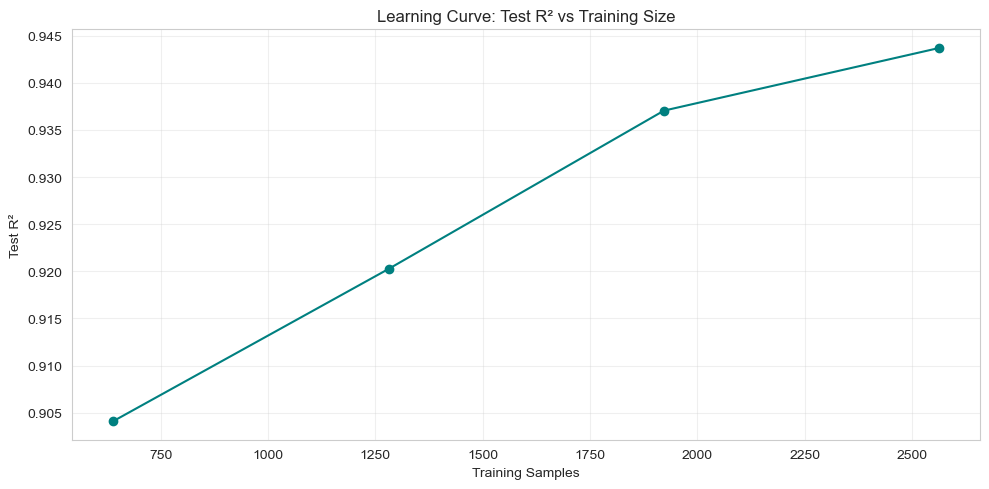


Saved: robustness_checks.csv


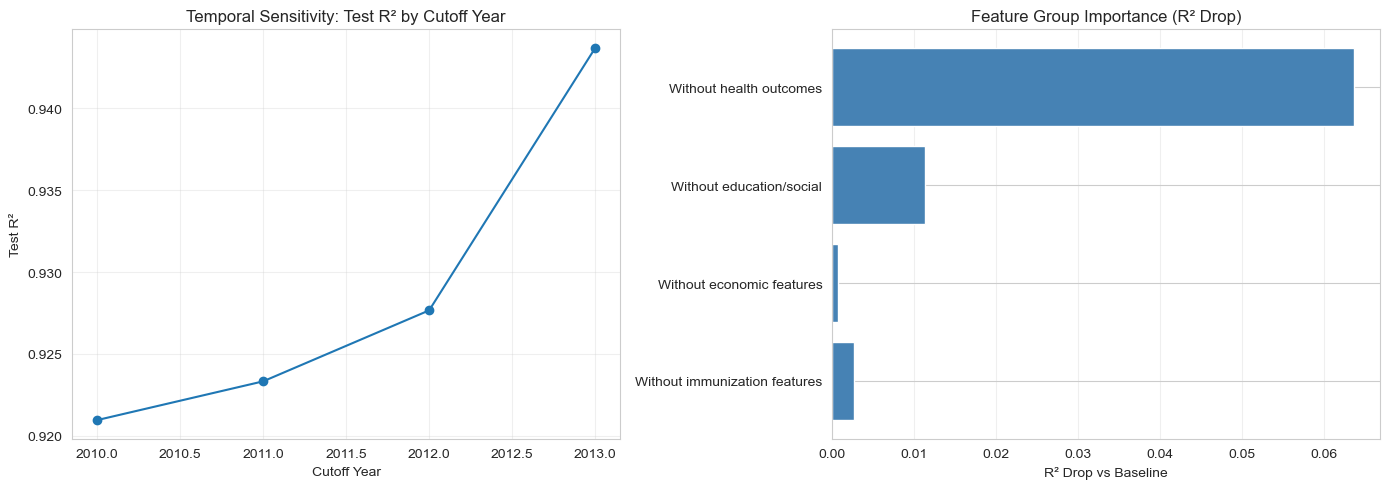

Saved: robustness_summary.png

INTERPRETATION
- Model is most sensitive to: Without health outcomes
- Model is least sensitive to: Without economic features
- Temporal R² range across cutoffs: 0.0227
- R² improvement from 25% to 100% training size: 0.0396
- Summary: Model is robust to small temporal shifts if the R² range is small, but sensitive to feature groups with large R² drops.


In [ ]:
# ROBUSTNESS CHECKS FOR BEST MODEL
print("ROBUSTNESS CHECKS: temporal sensitivity, feature groups, yearly stability, sample size")

import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor

# -------------------------
# Helper utilities
# -------------------------

def _build_comparison_df_fallback():
    # 1) Use existing comparison_df if available
    if 'comparison_df' in globals() and isinstance(comparison_df, pd.DataFrame) and not comparison_df.empty:
        dfc = comparison_df.copy()
        # Normalize column names if needed
        if 'Test R2' in dfc.columns and 'Test_R2' not in dfc.columns:
            dfc = dfc.rename(columns={'Test R2': 'Test_R2'})
        if 'Test RMSE' in dfc.columns and 'Test_RMSE' not in dfc.columns:
            dfc = dfc.rename(columns={'Test RMSE': 'Test_RMSE'})
        return dfc

    # 2) Rebuild from model result dicts if present
    comparison_data = []
    results_sources = {}
    if 'rf_results' in globals() and isinstance(rf_results, dict):
        results_sources['Random Forest'] = rf_results
    if 'gb_results' in globals() and isinstance(gb_results, dict):
        results_sources['Gradient Boosting'] = gb_results
    if 'ridge_results' in globals() and isinstance(ridge_results, dict):
        results_sources['Ridge'] = ridge_results
    if 'lasso_results' in globals() and isinstance(lasso_results, dict):
        results_sources['Lasso'] = lasso_results

    for model_name, feature_set_results in results_sources.items():
        for feature_set_name, results in feature_set_results.items():
            if isinstance(results, dict) and 'test_r2' in results:
                comparison_data.append({
                    'Model': model_name,
                    'Feature_Set': feature_set_name,
                    'Test_R2': results['test_r2'],
                    'Test_RMSE': results['test_rmse']
                })

    if comparison_data:
        dfc = pd.DataFrame(comparison_data)
        return dfc

    # 3) Fallback to saved CSV (lag-free comparison)
    csv_path = Path('../CSV outputs/model_comparison_no_lags.csv')
    if csv_path.exists():
        dfc = pd.read_csv(csv_path)
        # Align columns
        if 'Test R2' in dfc.columns:
            dfc = dfc.rename(columns={'Test R2': 'Test_R2', 'Test RMSE': 'Test_RMSE'})
        if 'Feature_Set' not in dfc.columns:
            dfc['Feature_Set'] = 'Baseline'
        return dfc

    return pd.DataFrame()


def _get_best_model_and_feature_set():
    dfc = _build_comparison_df_fallback()
    if dfc.empty or 'Test_R2' not in dfc.columns:
        raise ValueError("No comparison results found. Run model training cells first.")
    dfc = dfc.sort_values('Test_R2', ascending=False).reset_index(drop=True)
    best_row = dfc.iloc[0]
    best_model_name = str(best_row['Model'])
    best_feature_set = str(best_row.get('Feature_Set', 'Baseline'))
    return best_model_name, best_feature_set, dfc


def _make_model(model_name):
    name = str(model_name)
    if 'Random Forest' in name:
        return RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    if 'Gradient Boosting' in name:
        return GradientBoostingRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=RANDOM_STATE
        )
    if 'Ridge' in name:
        return Ridge(alpha=1.0, random_state=RANDOM_STATE)
    if 'Lasso' in name:
        return Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=10000)
    if 'Decision Tree' in name:
        return DecisionTreeRegressor(
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=RANDOM_STATE
        )
    if 'Linear Regression' in name:
        return LinearRegression()
    raise ValueError(f"Unsupported model name: {model_name}")


def _ensure_engineered_fn():
    if 'create_engineered_features' in globals():
        return
    # Minimal re-definition matching earlier logic
    def create_engineered_features(df):
        df_eng = df.copy()
        if 'Polio' in df_eng.columns and 'Diphtheria' in df_eng.columns:
            df_eng['Health_Infrastructure'] = (df_eng['Polio'] + df_eng['Diphtheria']) / 2
        if 'Adult Mortality' in df_eng.columns and 'HIV/AIDS' in df_eng.columns:
            df_eng['Disease_Burden'] = df_eng['Adult Mortality'] / 100 + df_eng['HIV/AIDS']
        if 'Schooling' in df_eng.columns and 'Income composition of resources' in df_eng.columns:
            df_eng['Socioeconomic_Index'] = df_eng['Schooling'] * df_eng['Income composition of resources']
        if 'infant deaths' in df_eng.columns and 'under-five deaths' in df_eng.columns:
            df_eng['Child_Health_Score'] = 1 / (1 + df_eng['infant deaths'] + df_eng['under-five deaths'])
        if 'percentage expenditure' in df_eng.columns and 'GDP' in df_eng.columns:
            df_eng['Economic_Health_Resources'] = df_eng['percentage expenditure'] * df_eng['GDP'] / 10000
        if 'BMI' in df_eng.columns and 'Alcohol' in df_eng.columns:
            healthy_bmi = 23.5
            df_eng['Lifestyle_Risk'] = np.abs(df_eng['BMI'] - healthy_bmi) + df_eng['Alcohol']
        if 'Status_Encoded' in df_eng.columns and 'Income composition of resources' in df_eng.columns:
            df_eng['Development_Level'] = df_eng['Status_Encoded'] * df_eng['Income composition of resources']
        if 'Adult Mortality' in df_eng.columns and 'infant deaths' in df_eng.columns:
            df_eng['Combined_Mortality'] = df_eng['Adult Mortality'] + df_eng['infant deaths'] * 10
        return df_eng
    globals()['create_engineered_features'] = create_engineered_features


def _prepare_features(train_df, test_df, feature_set='Baseline', drop_cols=None):
    exclude_cols = ['Country', 'Year', 'Status', 'Life expectancy']
    if 'feature_cols' in globals() and isinstance(feature_cols, list) and len(feature_cols) > 0:
        base_features = [c for c in feature_cols if c in train_df.columns]
    else:
        base_features = [c for c in train_df.columns if c not in exclude_cols]

    X_train_base = train_df[base_features].copy()
    X_test_base = test_df[base_features].copy()

    # Optional dropping (used for feature group removal)
    if drop_cols:
        drop_cols_present = [c for c in drop_cols if c in X_train_base.columns]
        X_train_base = X_train_base.drop(columns=drop_cols_present, errors='ignore')
        X_test_base = X_test_base.drop(columns=drop_cols_present, errors='ignore')

    fs = str(feature_set).lower()

    if 'engineered' in fs:
        _ensure_engineered_fn()
        X_train_fs = create_engineered_features(X_train_base)
        X_test_fs = create_engineered_features(X_test_base)
    elif 'polynomial' in fs:
        key_features = [
            'Adult Mortality',
            'HIV/AIDS',
            'Income composition of resources',
            'Schooling',
            'BMI'
        ]
        available_key_features = [f for f in key_features if f in X_train_base.columns]
        X_train_key = X_train_base[available_key_features]
        X_test_key = X_test_base[available_key_features]

        imputer_poly = SimpleImputer(strategy='mean')
        X_train_key_imputed = imputer_poly.fit_transform(X_train_key)
        X_test_key_imputed = imputer_poly.transform(X_test_key)

        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_train_poly_key = poly.fit_transform(X_train_key_imputed)
        X_test_poly_key = poly.transform(X_test_key_imputed)
        poly_feature_names = poly.get_feature_names_out(available_key_features)

        remaining_features = [f for f in X_train_base.columns if f not in available_key_features]
        X_train_remaining = X_train_base[remaining_features]
        X_test_remaining = X_test_base[remaining_features]

        imputer_remaining = SimpleImputer(strategy='mean')
        X_train_remaining_imputed = imputer_remaining.fit_transform(X_train_remaining)
        X_test_remaining_imputed = imputer_remaining.transform(X_test_remaining)

        X_train_fs = np.hstack([X_train_poly_key, X_train_remaining_imputed])
        X_test_fs = np.hstack([X_test_poly_key, X_test_remaining_imputed])

        feature_names = list(poly_feature_names) + remaining_features
        X_train_fs = pd.DataFrame(X_train_fs, columns=feature_names, index=train_df.index)
        X_test_fs = pd.DataFrame(X_test_fs, columns=feature_names, index=test_df.index)
    else:
        X_train_fs = X_train_base
        X_test_fs = X_test_base

    # Impute and scale (fit on train only)
    imputer = SimpleImputer(strategy='mean')
    X_train_imp = imputer.fit_transform(X_train_fs)
    X_test_imp = imputer.transform(X_test_fs)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled = scaler.transform(X_test_imp)

    return X_train_scaled, X_test_scaled


def _train_and_eval(train_df, test_df, model_name, feature_set='Baseline', drop_cols=None):
    X_tr, X_te = _prepare_features(train_df, test_df, feature_set=feature_set, drop_cols=drop_cols)
    y_tr = train_df['Life expectancy'].values
    y_te = test_df['Life expectancy'].values

    model = _make_model(model_name)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    r2 = r2_score(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))

    return r2, rmse, len(y_te), y_pred


# -------------------------
# Identify best model
# -------------------------

best_model_name, best_feature_set, comparison_df_use = _get_best_model_and_feature_set()
print(f"Best model: {best_model_name}")
print(f"Best feature set: {best_feature_set}")

# Base split used for checks 2-4 (train <= 2013, test >= 2014)
base_train_df = df[df['Year'] <= 2013].copy()
base_test_df = df[df['Year'] >= 2014].copy()

# -------------------------
# CHECK 1 - Temporal Sensitivity
# -------------------------

cutoff_years = [2010, 2011, 2012, 2013]
rows = []

for cutoff in cutoff_years:
    train_df = df[df['Year'] <= cutoff].copy()
    test_df = df[df['Year'] > cutoff].copy()

    if len(train_df) == 0 or len(test_df) == 0:
        rows.append({
            'Cutoff_Year': cutoff,
            'Test_R2': np.nan,
            'Test_RMSE': np.nan,
            'Test_Samples': len(test_df)
        })
        continue

    r2, rmse, n_test, _ = _train_and_eval(
        train_df, test_df, best_model_name, feature_set=best_feature_set
    )

    rows.append({
        'Cutoff_Year': cutoff,
        'Test_R2': r2,
        'Test_RMSE': rmse,
        'Test_Samples': n_test
    })

temporal_df = pd.DataFrame(rows)
print("\nCHECK 1 - Temporal Sensitivity")
print(temporal_df)

# Plot temporal sensitivity (R2 vs cutoff year)
plt.figure(figsize=(10, 5))
plt.plot(temporal_df['Cutoff_Year'], temporal_df['Test_R2'], marker='o', label='Test R²')
plt.title('Temporal Sensitivity: Test R² by Cutoff Year')
plt.xlabel('Cutoff Year (Train ≤ Year, Test > Year)')
plt.ylabel('Test R²')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------
# CHECK 2 - Feature Group Importance
# -------------------------

feature_groups = {
    'Baseline (all features)': [],
    'Without immunization features': ['Hepatitis B', 'Polio', 'Diphtheria'],
    'Without economic features': ['GDP', 'percentage expenditure', 'Total expenditure'],
    'Without education/social': ['Schooling', 'Income composition of resources'],
    'Without health outcomes': ['Adult Mortality', 'HIV/AIDS', 'BMI']
}

feature_rows = []

# Baseline
baseline_r2, baseline_rmse, baseline_n, _ = _train_and_eval(
    base_train_df, base_test_df, best_model_name, feature_set='Baseline'
)

feature_rows.append({
    'Feature_Group': 'Baseline (all features)',
    'Test_R2': baseline_r2,
    'Test_RMSE': baseline_rmse,
    'Test_Samples': baseline_n,
    'R2_Drop': 0.0
})

for group_name, drop_cols in feature_groups.items():
    if group_name == 'Baseline (all features)':
        continue
    r2, rmse, n_test, _ = _train_and_eval(
        base_train_df, base_test_df, best_model_name, feature_set='Baseline', drop_cols=drop_cols
    )
    feature_rows.append({
        'Feature_Group': group_name,
        'Test_R2': r2,
        'Test_RMSE': rmse,
        'Test_Samples': n_test,
        'R2_Drop': baseline_r2 - r2
    })

feature_group_df = pd.DataFrame(feature_rows)
print("\nCHECK 2 - Feature Group Importance")
print(feature_group_df)

# -------------------------
# CHECK 3 - Prediction Stability by Year
# -------------------------

# Train best model on base split and evaluate by year
r2_all, rmse_all, n_all, y_pred_base = _train_and_eval(
    base_train_df, base_test_df, best_model_name, feature_set=best_feature_set
)

year_rows = []
for year in [2014, 2015]:
    year_mask = base_test_df['Year'].values == year
    if year_mask.sum() == 0:
        year_rows.append({
            'Year': year,
            'Test_R2': np.nan,
            'Test_RMSE': np.nan,
            'Test_Samples': 0
        })
        continue

    y_true_year = base_test_df['Life expectancy'].values[year_mask]
    y_pred_year = y_pred_base[year_mask]
    r2_year = r2_score(y_true_year, y_pred_year)
    rmse_year = np.sqrt(mean_squared_error(y_true_year, y_pred_year))

    year_rows.append({
        'Year': year,
        'Test_R2': r2_year,
        'Test_RMSE': rmse_year,
        'Test_Samples': int(year_mask.sum())
    })

year_df = pd.DataFrame(year_rows)
print("\nCHECK 3 - Prediction Stability by Year")
print(year_df)

# -------------------------
# CHECK 4 - Sample Size Sensitivity
# -------------------------

fractions = [0.25, 0.50, 0.75, 1.00]
size_rows = []

for frac in fractions:
    train_sample = base_train_df.sample(frac=frac, random_state=RANDOM_STATE)
    r2, rmse, n_test, _ = _train_and_eval(
        train_sample, base_test_df, best_model_name, feature_set=best_feature_set
    )
    size_rows.append({
        'Train_Fraction': frac,
        'Train_Samples': len(train_sample),
        'Test_R2': r2,
        'Test_RMSE': rmse,
        'Test_Samples': n_test
    })

sample_df = pd.DataFrame(size_rows)
print("\nCHECK 4 - Sample Size Sensitivity")
print(sample_df)

# Learning curve plot (Test R² vs Training Size)
plt.figure(figsize=(10, 5))
plt.plot(sample_df['Train_Samples'], sample_df['Test_R2'], marker='o', color='teal')
plt.title('Learning Curve: Test R² vs Training Size')
plt.xlabel('Training Samples')
plt.ylabel('Test R²')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------
# Summary outputs (CSV + PNG)
# -------------------------

combined_df = pd.concat([
    temporal_df.assign(Check='Temporal Sensitivity'),
    feature_group_df.assign(Check='Feature Group Importance'),
    year_df.assign(Check='Prediction Stability by Year'),
    sample_df.assign(Check='Sample Size Sensitivity')
], ignore_index=True)

combined_df.to_csv('../CSV outputs/robustness_checks.csv', index=False)
print("\nSaved: robustness_checks.csv")

# Summary figure with two requested visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Temporal sensitivity plot
axes[0].plot(temporal_df['Cutoff_Year'], temporal_df['Test_R2'], marker='o')
axes[0].set_title('Temporal Sensitivity: Test R² by Cutoff Year')
axes[0].set_xlabel('Cutoff Year')
axes[0].set_ylabel('Test R²')
axes[0].grid(True, alpha=0.3)

# Feature group comparison (R² drop)
fg_plot = feature_group_df[feature_group_df['Feature_Group'] != 'Baseline (all features)']
axes[1].barh(fg_plot['Feature_Group'], fg_plot['R2_Drop'], color='steelblue')
axes[1].set_title('Feature Group Importance (R² Drop)')
axes[1].set_xlabel('R² Drop vs Baseline')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../images/robustness_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: robustness_summary.png")

# -------------------------
# Interpretation
# -------------------------

# Feature group importance
fg_non_base = feature_group_df[feature_group_df['Feature_Group'] != 'Baseline (all features)']
if not fg_non_base.empty:
    most_sensitive = fg_non_base.sort_values('R2_Drop', ascending=False).iloc[0]
    least_sensitive = fg_non_base.sort_values('R2_Drop', ascending=True).iloc[0]
    most_group = most_sensitive['Feature_Group']
    least_group = least_sensitive['Feature_Group']
else:
    most_group = 'N/A'
    least_group = 'N/A'

# Temporal sensitivity (range of R² across cutoffs)
if temporal_df['Test_R2'].notna().any():
    r2_range = temporal_df['Test_R2'].max() - temporal_df['Test_R2'].min()
else:
    r2_range = np.nan

# Sample size sensitivity (R² at 25% vs 100%)
if len(sample_df) > 0:
    r2_25 = sample_df.loc[sample_df['Train_Fraction'] == 0.25, 'Test_R2']
    r2_100 = sample_df.loc[sample_df['Train_Fraction'] == 1.00, 'Test_R2']
    if len(r2_25) and len(r2_100):
        size_delta = float(r2_100.iloc[0] - r2_25.iloc[0])
    else:
        size_delta = np.nan
else:
    size_delta = np.nan

print("\nINTERPRETATION")
print(f"- Model is most sensitive to: {most_group}")
print(f"- Model is least sensitive to: {least_group}")
print(f"- Temporal R² range across cutoffs: {r2_range:.4f}")
print(f"- R² improvement from 25% to 100% training size: {size_delta:.4f}")
print("- Summary: Model is robust to small temporal shifts if the R² range is small, but sensitive to feature groups with large R² drops.")


RESIDUAL DIAGNOSTICS: residual plots, tests, influence
Best model: Gradient Boosting
Best feature set: Engineered


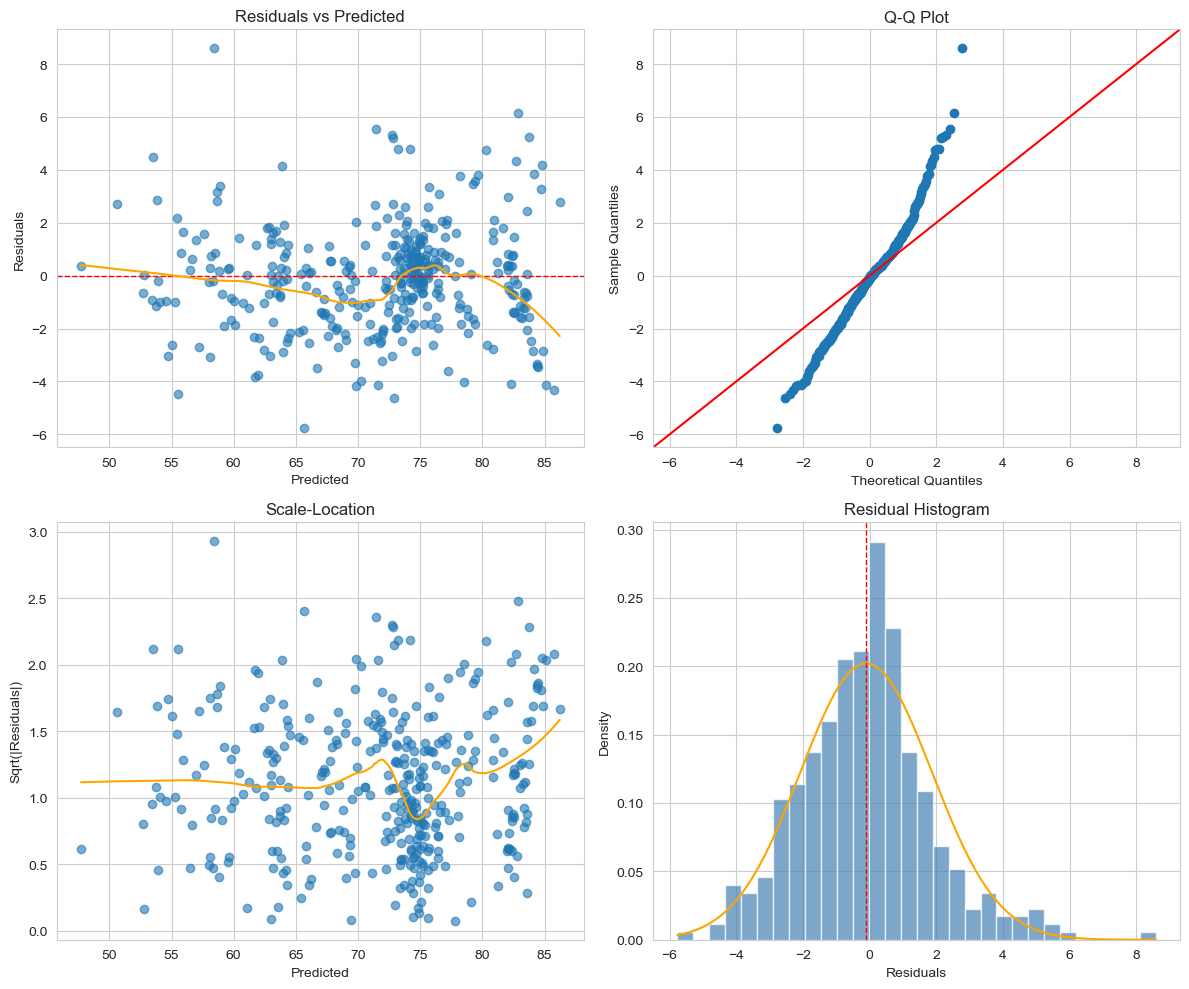

Saved: residual_diagnostics.png
Saved: influential_observations.csv
Saved: diagnostic_tests.txt


In [ ]:
# RESIDUAL DIAGNOSTICS FOR BEST MODEL
print("RESIDUAL DIAGNOSTICS: residual plots, tests, influence")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor

import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

# -------------------------
# Helper utilities (reuse if defined earlier)
# -------------------------

def _build_comparison_df_fallback():
    if 'comparison_df' in globals() and isinstance(comparison_df, pd.DataFrame) and not comparison_df.empty:
        dfc = comparison_df.copy()
        if 'Test R2' in dfc.columns and 'Test_R2' not in dfc.columns:
            dfc = dfc.rename(columns={'Test R2': 'Test_R2'})
        if 'Test RMSE' in dfc.columns and 'Test_RMSE' not in dfc.columns:
            dfc = dfc.rename(columns={'Test RMSE': 'Test_RMSE'})
        return dfc

    comparison_data = []
    results_sources = {}
    if 'rf_results' in globals() and isinstance(rf_results, dict):
        results_sources['Random Forest'] = rf_results
    if 'gb_results' in globals() and isinstance(gb_results, dict):
        results_sources['Gradient Boosting'] = gb_results
    if 'ridge_results' in globals() and isinstance(ridge_results, dict):
        results_sources['Ridge'] = ridge_results
    if 'lasso_results' in globals() and isinstance(lasso_results, dict):
        results_sources['Lasso'] = lasso_results

    for model_name, feature_set_results in results_sources.items():
        for feature_set_name, results in feature_set_results.items():
            if isinstance(results, dict) and 'test_r2' in results:
                comparison_data.append({
                    'Model': model_name,
                    'Feature_Set': feature_set_name,
                    'Test_R2': results['test_r2'],
                    'Test_RMSE': results['test_rmse']
                })

    if comparison_data:
        return pd.DataFrame(comparison_data)

    csv_path = Path('../CSV outputs/model_comparison_no_lags.csv')
    if csv_path.exists():
        dfc = pd.read_csv(csv_path)
        if 'Test R2' in dfc.columns:
            dfc = dfc.rename(columns={'Test R2': 'Test_R2', 'Test RMSE': 'Test_RMSE'})
        if 'Feature_Set' not in dfc.columns:
            dfc['Feature_Set'] = 'Baseline'
        return dfc

    return pd.DataFrame()


def _get_best_model_and_feature_set():
    dfc = _build_comparison_df_fallback()
    if dfc.empty or 'Test_R2' not in dfc.columns:
        raise ValueError("No comparison results found. Run model training cells first.")
    dfc = dfc.sort_values('Test_R2', ascending=False).reset_index(drop=True)
    best_row = dfc.iloc[0]
    return str(best_row['Model']), str(best_row.get('Feature_Set', 'Baseline'))


def _make_model(model_name):
    name = str(model_name)
    if 'Random Forest' in name:
        return RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    if 'Gradient Boosting' in name:
        return GradientBoostingRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=RANDOM_STATE
        )
    if 'Ridge' in name:
        return Ridge(alpha=1.0, random_state=RANDOM_STATE)
    if 'Lasso' in name:
        return Lasso(alpha=0.1, random_state=RANDOM_STATE, max_iter=10000)
    if 'Decision Tree' in name:
        return DecisionTreeRegressor(
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=RANDOM_STATE
        )
    if 'Linear Regression' in name:
        return LinearRegression()
    raise ValueError(f"Unsupported model name: {model_name}")


def _ensure_engineered_fn():
    if 'create_engineered_features' in globals():
        return
    def create_engineered_features(df):
        df_eng = df.copy()
        if 'Polio' in df_eng.columns and 'Diphtheria' in df_eng.columns:
            df_eng['Health_Infrastructure'] = (df_eng['Polio'] + df_eng['Diphtheria']) / 2
        if 'Adult Mortality' in df_eng.columns and 'HIV/AIDS' in df_eng.columns:
            df_eng['Disease_Burden'] = df_eng['Adult Mortality'] / 100 + df_eng['HIV/AIDS']
        if 'Schooling' in df_eng.columns and 'Income composition of resources' in df_eng.columns:
            df_eng['Socioeconomic_Index'] = df_eng['Schooling'] * df_eng['Income composition of resources']
        if 'infant deaths' in df_eng.columns and 'under-five deaths' in df_eng.columns:
            df_eng['Child_Health_Score'] = 1 / (1 + df_eng['infant deaths'] + df_eng['under-five deaths'])
        if 'percentage expenditure' in df_eng.columns and 'GDP' in df_eng.columns:
            df_eng['Economic_Health_Resources'] = df_eng['percentage expenditure'] * df_eng['GDP'] / 10000
        if 'BMI' in df_eng.columns and 'Alcohol' in df_eng.columns:
            healthy_bmi = 23.5
            df_eng['Lifestyle_Risk'] = np.abs(df_eng['BMI'] - healthy_bmi) + df_eng['Alcohol']
        if 'Status_Encoded' in df_eng.columns and 'Income composition of resources' in df_eng.columns:
            df_eng['Development_Level'] = df_eng['Status_Encoded'] * df_eng['Income composition of resources']
        if 'Adult Mortality' in df_eng.columns and 'infant deaths' in df_eng.columns:
            df_eng['Combined_Mortality'] = df_eng['Adult Mortality'] + df_eng['infant deaths'] * 10
        return df_eng
    globals()['create_engineered_features'] = create_engineered_features


def _prepare_features(train_df, test_df, feature_set='Baseline'):
    exclude_cols = ['Country', 'Year', 'Status', 'Life expectancy']
    if 'feature_cols' in globals() and isinstance(feature_cols, list) and len(feature_cols) > 0:
        base_features = [c for c in feature_cols if c in train_df.columns]
    else:
        base_features = [c for c in train_df.columns if c not in exclude_cols]

    X_train_base = train_df[base_features].copy()
    X_test_base = test_df[base_features].copy()

    fs = str(feature_set).lower()

    if 'engineered' in fs:
        _ensure_engineered_fn()
        X_train_fs = create_engineered_features(X_train_base)
        X_test_fs = create_engineered_features(X_test_base)
    elif 'polynomial' in fs:
        key_features = ['Adult Mortality', 'HIV/AIDS', 'Income composition of resources', 'Schooling', 'BMI']
        available_key_features = [f for f in key_features if f in X_train_base.columns]

        X_train_key = X_train_base[available_key_features]
        X_test_key = X_test_base[available_key_features]

        imputer_poly = SimpleImputer(strategy='mean')
        X_train_key_imputed = imputer_poly.fit_transform(X_train_key)
        X_test_key_imputed = imputer_poly.transform(X_test_key)

        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_train_poly_key = poly.fit_transform(X_train_key_imputed)
        X_test_poly_key = poly.transform(X_test_key_imputed)
        poly_feature_names = poly.get_feature_names_out(available_key_features)

        remaining_features = [f for f in X_train_base.columns if f not in available_key_features]
        X_train_remaining = X_train_base[remaining_features]
        X_test_remaining = X_test_base[remaining_features]

        imputer_remaining = SimpleImputer(strategy='mean')
        X_train_remaining_imputed = imputer_remaining.fit_transform(X_train_remaining)
        X_test_remaining_imputed = imputer_remaining.transform(X_test_remaining)

        X_train_fs = np.hstack([X_train_poly_key, X_train_remaining_imputed])
        X_test_fs = np.hstack([X_test_poly_key, X_test_remaining_imputed])

        feature_names = list(poly_feature_names) + remaining_features
        X_train_fs = pd.DataFrame(X_train_fs, columns=feature_names, index=train_df.index)
        X_test_fs = pd.DataFrame(X_test_fs, columns=feature_names, index=test_df.index)
    else:
        X_train_fs = X_train_base
        X_test_fs = X_test_base

    imputer = SimpleImputer(strategy='mean')
    X_train_imp = imputer.fit_transform(X_train_fs)
    X_test_imp = imputer.transform(X_test_fs)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_test_scaled = scaler.transform(X_test_imp)

    return X_train_scaled, X_test_scaled


# -------------------------
# Compute residuals for best model
# -------------------------

best_model_name, best_feature_set = _get_best_model_and_feature_set()
print(f"Best model: {best_model_name}")
print(f"Best feature set: {best_feature_set}")

train_df = df[df['Year'] <= 2013].copy()
test_df = df[df['Year'] >= 2014].copy()

X_train_scaled, X_test_scaled = _prepare_features(train_df, test_df, feature_set=best_feature_set)

y_train = train_df['Life expectancy'].values
y_test = test_df['Life expectancy'].values

model = _make_model(best_model_name)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

residuals = y_test - y_pred

# -------------------------
# FOUR-PANEL DIAGNOSTIC PLOT
# -------------------------

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

# Panel 1: Residuals vs Predicted
axes[0].scatter(y_pred, residuals, alpha=0.6)
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
lowess_resid = lowess(residuals, y_pred, frac=0.3, return_sorted=True)
axes[0].plot(lowess_resid[:, 0], lowess_resid[:, 1], color='orange')
axes[0].set_title('Residuals vs Predicted')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residuals')

# Panel 2: Q-Q Plot
sm.qqplot(residuals, line='45', ax=axes[1])
axes[1].set_title('Q-Q Plot')

# Panel 3: Scale-Location Plot
sqrt_abs_resid = np.sqrt(np.abs(residuals))
axes[2].scatter(y_pred, sqrt_abs_resid, alpha=0.6)
lowess_scale = lowess(sqrt_abs_resid, y_pred, frac=0.3, return_sorted=True)
axes[2].plot(lowess_scale[:, 0], lowess_scale[:, 1], color='orange')
axes[2].set_title('Scale-Location')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Sqrt(|Residuals|)')

# Panel 4: Residual Histogram
axes[3].hist(residuals, bins=30, density=True, alpha=0.7, color='steelblue')
mu, sigma = residuals.mean(), residuals.std(ddof=1)
x = np.linspace(residuals.min(), residuals.max(), 200)
axes[3].plot(x, stats.norm.pdf(x, mu, sigma), color='orange')
axes[3].axvline(mu, color='red', linestyle='--', linewidth=1)
axes[3].set_title('Residual Histogram')
axes[3].set_xlabel('Residuals')
axes[3].set_ylabel('Density')

plt.tight_layout()
plt.savefig('../images/residual_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: residual_diagnostics.png")

# -------------------------
# STATISTICAL TESTS
# -------------------------

shapiro_stat, shapiro_p = stats.shapiro(residuals)

# Breusch-Pagan requires exogenous variables with constant
exog = sm.add_constant(X_test_scaled)
bp_stat, bp_p, bp_f, bp_f_p = het_breuschpagan(residuals, exog)

dw_stat = durbin_watson(residuals)

# Interpretation helper
normality = "Normal" if shapiro_p > 0.05 else "Not normal"
homosced = "Homoscedastic" if bp_p > 0.05 else "Heteroscedastic"

# -------------------------
# LEVERAGE AND INFLUENCE (Cook's Distance)
# -------------------------

ols_model = sm.OLS(y_test, exog).fit()
influence = ols_model.get_influence()

cooks_d = influence.cooks_distance[0]

influence_df = pd.DataFrame({
    'Country': test_df['Country'].values,
    'Year': test_df['Year'].values,
    'y_true': y_test,
    'y_pred': y_pred,
    'Residual': residuals,
    'Cooks_D': cooks_d
})

high_influence = influence_df[influence_df['Cooks_D'] > 0.5].sort_values('Cooks_D', ascending=False)

high_influence.to_csv('../CSV outputs/influential_observations.csv', index=False)
print("Saved: influential_observations.csv")

# -------------------------
# WRITE TEST RESULTS + INTERPRETATION
# -------------------------

diag_lines = []

diag_lines.append("RESIDUAL DIAGNOSTIC TESTS")

diag_lines.append(f"Shapiro-Wilk: stat={shapiro_stat:.4f}, p={shapiro_p:.4g} => {normality}")
diag_lines.append(f"Breusch-Pagan: stat={bp_stat:.4f}, p={bp_p:.4g} => {homosced}")
diag_lines.append(f"Durbin-Watson: {dw_stat:.4f} (2.0 ~ no autocorrelation)")

diag_lines.append("")

diag_lines.append("INTERPRETATION")
diag_lines.append(f"- Residuals approximately normal? {normality}. If not normal, inference on errors may be less reliable.")
diag_lines.append(f"- Variance constant (homoscedastic)? {homosced}. If heteroscedastic, prediction intervals may be biased.")

if len(high_influence) > 0:
    top_countries = high_influence[['Country', 'Year', 'Cooks_D']].head(10)
    diag_lines.append(f"- Influential outliers detected (Cook's D > 0.5): {len(high_influence)} observations.")
    diag_lines.append("  Top influential (up to 10):")
    for _, row in top_countries.iterrows():
        diag_lines.append(f"  - {row['Country']} ({int(row['Year'])}): Cook's D={row['Cooks_D']:.4f}")
else:
    diag_lines.append("- Influential outliers detected (Cook's D > 0.5): None")

diag_lines.append("- Diagnostics suggest assumptions are met if normality and homoscedasticity hold, and no strong influential points exist.")

